In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from PIL import Image
from tqdm import tqdm

### explor the dataset

Description of dataset:
Car Damage Detection ([CarDD](https://cardd-ustc.github.io)), the first public large-scale dataset designed for vision-based car damage detection and segmentation. CarDD contains 4,000 high-resolution car damage images (2816 train | 810 val | 374 test)  with over 9,000 well-annotated instances of six damage categories.


In [ ]:
# for example the the test train files

annFile = './drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO/annotations/instances_train2017.json'
img_dir = './drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO/train2017'

In [ ]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=3.35s)
creating index...
index created!


In [ ]:
# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

print("")
print("")
print("----------------")
print("")
# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(coco.cats.values()):
    category_map.update({ele['id']:ele['name']})
    print(category_map)

Category ID: 1, Category Name: dent
Category ID: 2, Category Name: scratch
Category ID: 3, Category Name: crack
Category ID: 4, Category Name: glass shatter
Category ID: 5, Category Name: lamp broken
Category ID: 6, Category Name: tire flat


----------------

{1: 'dent'}
{1: 'dent', 2: 'scratch'}
{1: 'dent', 2: 'scratch', 3: 'crack'}
{1: 'dent', 2: 'scratch', 3: 'crack', 4: 'glass shatter'}
{1: 'dent', 2: 'scratch', 3: 'crack', 4: 'glass shatter', 5: 'lamp broken'}
{1: 'dent', 2: 'scratch', 3: 'crack', 4: 'glass shatter', 5: 'lamp broken', 6: 'tire flat'}


Image details 
 {'id': 2910, 'width': 1000, 'height': 750, 'file_name': '002910.jpg', 'license': 0}
Damages are: ['dent', 'scratch']


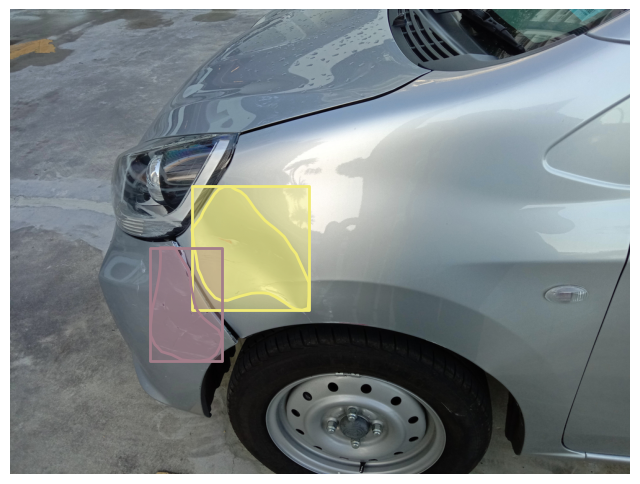

In [ ]:
# get all images containing 'dent' category, select one at random
catIds = coco.getCatIds(catNms=['dent'])
imgIds = coco.getImgIds(catIds=catIds )
random_img_id = random.choice(imgIds)

# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)


#Create a list of damage types in the image
damages = []
for region in anns:
    damages.append(category_map[region['category_id']])

print("Damages are:", damages)

#Plot Damages
I = io.imread(img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('off')
coco.showAnns(anns, draw_bbox=True )


In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.6.0+cu124
12.4


## MMDetection

In [ ]:
!pip install mmengine mmcv==2.1.0
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.4/471.4 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.7/452.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 24.8 MB/s eta 0:00:00
  Created wheel for mmcv: filename=mmcv-2.1.0-cp311-cp311-linux_x86_64.whl size=38291407 sha256=a05a2a86f7d0071dc61f93e5f632252b270301e5575c6b9d130f08c2d27ca8b6
  Stored in directory: /root/.cache/pip/wheels/57/22/96/9bcbfeaa838c1b705a4b2ac082539767fbcc79fa07ec01abcd
Successfully built mmcv
Cloning into 'mmdetection'...
remote: Enumerating objects: 38023, done.
remote: Total 38023 (delta 0), reused 0 (delta 0), pack-reused 38023 (from 1)
Receiving objects: 100% (38023/38023), 63.19 MiB | 33.86 MiB/s, done.
Resolving deltas: 100% (26217/26217), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Preparing metadata 

In [ ]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)

torch version: 2.6.0+cu124 cuda: True
mmdetection: 3.3.0
mmcv: 2.1.0
mmengine: 0.10.7


In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import cv2
import random
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import os
import seaborn as sns
from matplotlib import colors
from rich.pretty import pprint
import PIL
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from tqdm import tqdm
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from mmengine import Config
from mmengine.runner import set_random_seed
import mmcv
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector
from mmengine.structures import InstanceData

In [ ]:
%cd ..

/content


In [ ]:
content = '''
# Copyright (c) OpenMMLab. All rights reserved.
import copy
import os.path as osp
from typing import List, Union

from mmengine.fileio import get_local_path

from mmdet.registry import DATASETS
from .api_wrappers import COCO
from .base_det_dataset import BaseDetDataset


@DATASETS.register_module()
class CocoDataset(BaseDetDataset):
    """Dataset for COCO."""

    METAINFO = {
        'classes':
        ('dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat',),
        # palette is a list of color tuples, which is used for visualization.
        'palette':
        [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
         (0, 60, 100)]
    }
    COCOAPI = COCO
    # ann_id is unique in coco dataset.
    ANN_ID_UNIQUE = True

    def load_data_list(self) -> List[dict]:
        """Load annotations from an annotation file named as ``self.ann_file``

        Returns:
            List[dict]: A list of annotation.
        """  # noqa: E501
        with get_local_path(
                self.ann_file, backend_args=self.backend_args) as local_path:
            self.coco = self.COCOAPI(local_path)
        # The order of returned `cat_ids` will not
        # change with the order of the `classes`
        self.cat_ids = self.coco.get_cat_ids(
            cat_names=self.metainfo['classes'])
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.cat_img_map = copy.deepcopy(self.coco.cat_img_map)

        img_ids = self.coco.get_img_ids()
        data_list = []
        total_ann_ids = []
        for img_id in img_ids:
            raw_img_info = self.coco.load_imgs([img_id])[0]
            raw_img_info['img_id'] = img_id

            ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
            raw_ann_info = self.coco.load_anns(ann_ids)
            total_ann_ids.extend(ann_ids)

            parsed_data_info = self.parse_data_info({
                'raw_ann_info':
                raw_ann_info,
                'raw_img_info':
                raw_img_info
            })
            data_list.append(parsed_data_info)
        if self.ANN_ID_UNIQUE:
            assert len(set(total_ann_ids)) == len(
                total_ann_ids
            ), f"Annotation ids in '{self.ann_file}' are not unique!"

        del self.coco

        return data_list

    def parse_data_info(self, raw_data_info: dict) -> Union[dict, List[dict]]:
        """Parse raw annotation to target format.

        Args:
            raw_data_info (dict): Raw data information load from ``ann_file``

        Returns:
            Union[dict, List[dict]]: Parsed annotation.
        """
        img_info = raw_data_info['raw_img_info']
        ann_info = raw_data_info['raw_ann_info']

        data_info = {}

        # TODO: need to change data_prefix['img'] to data_prefix['img_path']
        img_path = osp.join(self.data_prefix['img'], img_info['file_name'])
        if self.data_prefix.get('seg', None):
            seg_map_path = osp.join(
                self.data_prefix['seg'],
                img_info['file_name'].rsplit('.', 1)[0] + self.seg_map_suffix)
        else:
            seg_map_path = None
        data_info['img_path'] = img_path
        data_info['img_id'] = img_info['img_id']
        data_info['seg_map_path'] = seg_map_path
        data_info['height'] = img_info['height']
        data_info['width'] = img_info['width']

        if self.return_classes:
            data_info['text'] = self.metainfo['classes']
            data_info['caption_prompt'] = self.caption_prompt
            data_info['custom_entities'] = True

        instances = []
        for i, ann in enumerate(ann_info):
            instance = {}

            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            inter_w = max(0, min(x1 + w, img_info['width']) - max(x1, 0))
            inter_h = max(0, min(y1 + h, img_info['height']) - max(y1, 0))
            if inter_w * inter_h == 0:
                continue
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            if ann['category_id'] not in self.cat_ids:
                continue
            bbox = [x1, y1, x1 + w, y1 + h]

            if ann.get('iscrowd', False):
                instance['ignore_flag'] = 1
            else:
                instance['ignore_flag'] = 0
            instance['bbox'] = bbox
            instance['bbox_label'] = self.cat2label[ann['category_id']]

            if ann.get('segmentation', None):
                instance['mask'] = ann['segmentation']

            instances.append(instance)
        data_info['instances'] = instances
        return data_info

    def filter_data(self) -> List[dict]:
        """Filter annotations according to filter_cfg.

        Returns:
            List[dict]: Filtered results.
        """
        if self.test_mode:
            return self.data_list

        if self.filter_cfg is None:
            return self.data_list

        filter_empty_gt = self.filter_cfg.get('filter_empty_gt', False)
        min_size = self.filter_cfg.get('min_size', 0)

        # obtain images that contain annotation
        ids_with_ann = set(data_info['img_id'] for data_info in self.data_list)
        # obtain images that contain annotations of the required categories
        ids_in_cat = set()
        for i, class_id in enumerate(self.cat_ids):
            ids_in_cat |= set(self.cat_img_map[class_id])
        # merge the image id sets of the two conditions and use the merged set
        # to filter out images if self.filter_empty_gt=True
        ids_in_cat &= ids_with_ann

        valid_data_infos = []
        for i, data_info in enumerate(self.data_list):
            img_id = data_info['img_id']
            width = data_info['width']
            height = data_info['height']
            if filter_empty_gt and img_id not in ids_in_cat:
                continue
            if min(width, height) >= min_size:
                valid_data_infos.append(data_info)

        return valid_data_infos
'''
with open('./mmdetection/mmdet/datasets/coco.py', 'w') as f:
    f.write(content.strip())

### Customizing the model configuration
DCN+ involves two key techniques:
-  multi-scale learning that can be used to handle the scale diversity of objects and focal loss to enforce the model to focus on hard categories. They randomly resize the height of each training image in the range of [640, 1200] while keeping the width as 1333.
- The model will be optimized by minimizing the sum of the focal loss,the L1loss,and the cross-entropy loss. For focal loss, they use the α-balanced version to control the importance of different categories. They tried multiple combinations of α and γ and chose the best one (α=0.50 and γ=2.0) for the study of combined effect with multi-scale learning.

In [ ]:
# Below code is loading a model configuration file from MMDetection using the Config class.
cfg = Config.fromfile('mmdetection/configs/dcn/mask-rcnn_r101-dconv-c3-c5_fpn_1x_coco.py')

Below script is customizing and saving a full training configuration for an object detection + instance segmentation model using MMDetection. Let's go through it step by step.
- Load a pre-defined model config (DCN + Mask R-CNN + ResNet-101 + FPN)
- Adapt it to a custom dataset called CARDd (car damage detection)
-   Modify training pipeline, number of classes, and losses
-   Set evaluation, checkpointing, and visualization options
-    Save everything into a new config file dcn_plus_cfg.py

In [ ]:
cfg.load_from = 'https://download.openmmlab.com/mmdetection/v2.0/dcn/mask_rcnn_r101_fpn_dconv_c3-c5_1x_coco/mask_rcnn_r101_fpn_dconv_c3-c5_1x_coco_20200216-a71f5bce.pth'
cfg.data_root = './drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO'

classes = ('dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat',)
n_classes = len(classes)

# Set up working dir to save files and logs.
cfg.work_dir = './drive/MyDrive/damage_detection/dcn_plus_output'

cfg.metainfo = {
    'classes': classes,
    'palette': [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
         (0, 60, 100)]
}

# Modify some of the model's properties
cfg.model.backbone.stage_with_dcn = (True, True, True, True)
cfg.model.roi_head.bbox_head.num_classes = n_classes
cfg.model.roi_head.mask_head.num_classes = n_classes
cfg.model.roi_head.bbox_head.loss_cls = dict(type='FocalLoss', use_sigmoid=True, gamma=2.0, alpha=0.5, loss_weight=1.0)

cfg.train_dataloader.dataset.ann_file = 'annotations/instances_train2017.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train2017/'

cfg.val_dataloader.dataset.ann_file = 'annotations/instances_val2017.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'val2017/'

cfg.test_dataloader.dataset.ann_file = 'annotations/instances_test2017.json'
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix.img = 'test2017/'

cfg.val_evaluator = {'type': 'CocoMetric',
 'ann_file': '/content/drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO/annotations/instances_val2017.json',
 'metric': ['bbox','segm'],
 'classwise': True,
 'format_only': False,
 'backend_args': None}

cfg.test_evaluator = {'type': 'CocoMetric',
 'ann_file': '/content/drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO/annotations/instances_test2017.json',
 'metric': ['bbox','segm'],
 'classwise': True,
 'format_only': False,
 'backend_args': None}

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=[(1333, 640), (1333, 1200)], multiscale_mode='range', keep_ratio=False, backend='pillow'),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PackDetInputs')
]

# Schedule the training
cfg.train_cfg.max_epochs = 24
cfg.optim_wrapper.optimizer.lr = 0.005
cfg.param_scheduler[1] = dict(type= 'MultiStepLR', begin= 0, end= 24, by_epoch= True,
                              milestones= [16, 22], gamma= 0.1)

# We can set the evaluation interval
cfg.train_cfg.val_interval = 1

# We can set the checkpoint saving interval
cfg.default_hooks.checkpoint.interval = 1
cfg.default_hooks.logger.interval = 50

# Set seed thus the results are more reproducible
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------

config= './drive/MyDrive/damage_detection/dcn_plus_cfg.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

# Train
- To train using 1 gpu run:!python mmdetection/tools/train.py dcn_plus_cfg.py
- To perform distributed training using 2 gpus run the following:

In [ ]:
!bash mmdetection/tools/dist_train.sh './drive/MyDrive/damage_detection/dcn_plus_cfg.py' 1

/usr/local/lib/python3.11/dist-packages/torch/distributed/launch.py:208: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  main()


/usr/local/lib/python3.11/dist-packages/mmengine/utils/dl_utils/setup_env.py:46: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mmengine/utils/dl_utils/setup_env.py:56: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(


2025-07-15 11:35:55.504938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


E0000 00:00:1752579355.525862   58369 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752579355.532222   58369 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


07/15 11:35:58 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 497809488
    GPU 0: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.6.0+cu124
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.5
  - Built with CUDA Runtime 12.4
  - NVCC archit

07/15 11:35:58 - mmengine - INFO - Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
backend_args = None
data_root = './drive/MyDrive/damage_detection/CarDD_release/CarDD_COCO'
dataset_type = 'CocoDataset'
default_hooks = dict(
    checkpoint=dict(interval=1, type='CheckpointHook'),
    logger=dict(interval=50, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='DetVisualizationHook'))
default_scope = 'mmdet'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
launcher = 'pytorch'
load_from = 'https://download.openmmlab.com/mmdetection/v2.0/dcn/mask_rcnn_r101_fpn_dconv_c3-c5_1x_coco/mask_rcnn_r101_fpn_dconv_c3-c5_1x_coco_20200216-a71f5bce.pth'
log_level = 'INFO'
log_processor = dict(by_epoch=True, type='LogProcessor', window_size=50)
metainfo = dict

07/15 11:36:00 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(BELOW_NORMAL) LoggerHook                         
(LOW         ) ParamSchedulerHook                 
(VERY_LOW    ) CheckpointHook

Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
07/15 11:36:02 - mmengine - INFO - load model from: torchvision://resnet101
07/15 11:36:02 - mmengine - INFO - Loads checkpoint by torchvision backend from path: torchvision://resnet101
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
 38% 64.4M/171M [00:00<00:00, 255MB/s]

100% 171M/171M [00:00<00:00, 274MB/s]


07/15 11:36:03 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer1.0.conv2.conv_offset.weight, layer1.0.conv2.conv_offset.bias, layer1.1.conv2.conv_offset.weight, layer1.1.conv2.conv_offset.bias, layer1.2.conv2.conv_offset.weight, layer1.2.conv2.conv_offset.bias, layer2.0.conv2.conv_offset.weight, layer2.0.conv2.conv_offset.bias, layer2.1.conv2.conv_offset.weight, layer2.1.conv2.conv_offset.bias, layer2.2.conv2.conv_offset.weight, layer2.2.conv2.conv_offset.bias, layer2.3.conv2.conv_offset.weight, layer2.3.conv2.conv_offset.bias, layer3.0.conv2.conv_offset.weight, layer3.0.conv2.conv_offset.bias, layer3.1.conv2.conv_offset.weight, layer3.1.conv2.conv_offset.bias, layer3.2.conv2.conv_offset.weight, layer3.2.conv2.conv_offset.bias, layer3.3.conv2.conv_offset.weight, layer3.3.conv2.conv_offset.bias, layer3.4.conv2.conv_offset.weight, layer3.4.conv2.conv_offset.bias, 

 19% 47.5M/247M [00:02<00:07, 29.6MB/s]

 24% 59.2M/247M [00:02<00:06, 30.0MB/s]

 34% 83.2M/247M [00:03<00:05, 29.5MB/s]

 53% 131M/247M [00:05<00:04, 29.9MB/s]

 58% 143M/247M [00:05<00:03, 30.3MB/s]

 67% 166M/247M [00:06<00:02, 28.3MB/s]

 88% 217M/247M [00:08<00:01, 30.2MB/s]

 93% 229M/247M [00:08<00:00, 30.1MB/s]

100% 247M/247M [00:09<00:00, 28.5MB/s]


The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([7, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([7]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([24, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([24]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits.bias: copying a param with shape torch.Size([8

07/15 11:36:36 - mmengine - INFO - Epoch(train)  [1][  50/1408]  lr: 4.9549e-04  eta: 4:22:25  time: 0.4666  data_time: 0.1401  memory: 5506  loss: 1.5786  loss_rpn_cls: 0.0766  loss_rpn_bbox: 0.0281  loss_cls: 0.3013  acc: 94.0430  loss_bbox: 0.1355  loss_mask: 1.0372


07/15 11:36:56 - mmengine - INFO - Epoch(train)  [1][ 100/1408]  lr: 9.9599e-04  eta: 4:02:26  time: 0.3969  data_time: 0.1274  memory: 5506  loss: 0.8352  loss_rpn_cls: 0.0556  loss_rpn_bbox: 0.0343  loss_cls: 0.0584  acc: 96.2891  loss_bbox: 0.1660  loss_mask: 0.5210


07/15 11:37:20 - mmengine - INFO - Epoch(train)  [1][ 150/1408]  lr: 1.4965e-03  eta: 4:09:33  time: 0.4718  data_time: 0.2025  memory: 5506  loss: 0.7255  loss_rpn_cls: 0.0400  loss_rpn_bbox: 0.0297  loss_cls: 0.0536  acc: 98.1445  loss_bbox: 0.1654  loss_mask: 0.4368


07/15 11:37:39 - mmengine - INFO - Epoch(train)  [1][ 200/1408]  lr: 1.9970e-03  eta: 3:59:23  time: 0.3750  data_time: 0.1089  memory: 5506  loss: 0.6277  loss_rpn_cls: 0.0393  loss_rpn_bbox: 0.0225  loss_cls: 0.0485  acc: 96.0938  loss_bbox: 0.1591  loss_mask: 0.3582


07/15 11:37:56 - mmengine - INFO - Epoch(train)  [1][ 250/1408]  lr: 2.4975e-03  eta: 3:50:07  time: 0.3480  data_time: 0.0771  memory: 5506  loss: 0.6301  loss_rpn_cls: 0.0315  loss_rpn_bbox: 0.0241  loss_cls: 0.0500  acc: 98.2422  loss_bbox: 0.1737  loss_mask: 0.3508


07/15 11:38:15 - mmengine - INFO - Epoch(train)  [1][ 300/1408]  lr: 2.9980e-03  eta: 3:46:06  time: 0.3720  data_time: 0.1080  memory: 5506  loss: 0.6405  loss_rpn_cls: 0.0300  loss_rpn_bbox: 0.0224  loss_cls: 0.0504  acc: 97.5586  loss_bbox: 0.1712  loss_mask: 0.3664


07/15 11:38:35 - mmengine - INFO - Epoch(train)  [1][ 350/1408]  lr: 3.4985e-03  eta: 3:45:53  time: 0.4066  data_time: 0.1435  memory: 5506  loss: 0.6020  loss_rpn_cls: 0.0267  loss_rpn_bbox: 0.0276  loss_cls: 0.0445  acc: 94.6289  loss_bbox: 0.1346  loss_mask: 0.3686


07/15 11:38:52 - mmengine - INFO - Epoch(train)  [1][ 400/1408]  lr: 3.9990e-03  eta: 3:41:24  time: 0.3458  data_time: 0.0797  memory: 5519  loss: 0.6552  loss_rpn_cls: 0.0281  loss_rpn_bbox: 0.0285  loss_cls: 0.0492  acc: 90.2344  loss_bbox: 0.1545  loss_mask: 0.3949


07/15 11:39:12 - mmengine - INFO - Epoch(train)  [1][ 450/1408]  lr: 4.4995e-03  eta: 3:40:34  time: 0.3896  data_time: 0.1221  memory: 5506  loss: 0.6234  loss_rpn_cls: 0.0358  loss_rpn_bbox: 0.0287  loss_cls: 0.0458  acc: 95.2148  loss_bbox: 0.1371  loss_mask: 0.3760


07/15 11:39:31 - mmengine - INFO - Epoch(train)  [1][ 500/1408]  lr: 5.0000e-03  eta: 3:39:30  time: 0.3836  data_time: 0.1190  memory: 5506  loss: 0.6099  loss_rpn_cls: 0.0300  loss_rpn_bbox: 0.0246  loss_cls: 0.0426  acc: 96.2891  loss_bbox: 0.1198  loss_mask: 0.3929


07/15 11:39:49 - mmengine - INFO - Epoch(train)  [1][ 550/1408]  lr: 5.0000e-03  eta: 3:37:52  time: 0.3697  data_time: 0.1050  memory: 5506  loss: 0.6104  loss_rpn_cls: 0.0395  loss_rpn_bbox: 0.0295  loss_cls: 0.0429  acc: 93.5547  loss_bbox: 0.1256  loss_mask: 0.3729


07/15 11:40:09 - mmengine - INFO - Epoch(train)  [1][ 600/1408]  lr: 5.0000e-03  eta: 3:37:27  time: 0.3913  data_time: 0.1241  memory: 5507  loss: 0.5606  loss_rpn_cls: 0.0262  loss_rpn_bbox: 0.0278  loss_cls: 0.0450  acc: 97.9492  loss_bbox: 0.1298  loss_mask: 0.3318


07/15 11:40:28 - mmengine - INFO - Epoch(train)  [1][ 650/1408]  lr: 5.0000e-03  eta: 3:36:34  time: 0.3800  data_time: 0.1126  memory: 5548  loss: 0.6575  loss_rpn_cls: 0.0342  loss_rpn_bbox: 0.0292  loss_cls: 0.0455  acc: 92.2852  loss_bbox: 0.1365  loss_mask: 0.4121


07/15 11:40:47 - mmengine - INFO - Epoch(train)  [1][ 700/1408]  lr: 5.0000e-03  eta: 3:35:59  time: 0.3857  data_time: 0.1205  memory: 5506  loss: 0.5973  loss_rpn_cls: 0.0295  loss_rpn_bbox: 0.0251  loss_cls: 0.0471  acc: 98.1445  loss_bbox: 0.1338  loss_mask: 0.3617


07/15 11:41:07 - mmengine - INFO - Epoch(train)  [1][ 750/1408]  lr: 5.0000e-03  eta: 3:36:04  time: 0.4026  data_time: 0.1361  memory: 5506  loss: 0.5407  loss_rpn_cls: 0.0226  loss_rpn_bbox: 0.0226  loss_cls: 0.0416  acc: 97.5586  loss_bbox: 0.1334  loss_mask: 0.3205


07/15 11:41:28 - mmengine - INFO - Epoch(train)  [1][ 800/1408]  lr: 5.0000e-03  eta: 3:36:32  time: 0.4156  data_time: 0.1483  memory: 5506  loss: 0.5796  loss_rpn_cls: 0.0376  loss_rpn_bbox: 0.0289  loss_cls: 0.0436  acc: 98.6328  loss_bbox: 0.1391  loss_mask: 0.3304


07/15 11:42:06 - mmengine - INFO - Epoch(train)  [1][ 850/1408]  lr: 5.0000e-03  eta: 3:48:10  time: 0.7640  data_time: 0.4978  memory: 5506  loss: 0.5471  loss_rpn_cls: 0.0276  loss_rpn_bbox: 0.0271  loss_cls: 0.0385  acc: 97.7539  loss_bbox: 0.1249  loss_mask: 0.3290


07/15 11:42:24 - mmengine - INFO - Epoch(train)  [1][ 900/1408]  lr: 5.0000e-03  eta: 3:46:12  time: 0.3627  data_time: 0.0958  memory: 5506  loss: 0.5031  loss_rpn_cls: 0.0237  loss_rpn_bbox: 0.0206  loss_cls: 0.0399  acc: 94.0430  loss_bbox: 0.1226  loss_mask: 0.2963


07/15 11:42:44 - mmengine - INFO - Epoch(train)  [1][ 950/1408]  lr: 5.0000e-03  eta: 3:45:28  time: 0.3989  data_time: 0.1327  memory: 5506  loss: 0.5266  loss_rpn_cls: 0.0203  loss_rpn_bbox: 0.0213  loss_cls: 0.0439  acc: 96.4844  loss_bbox: 0.1329  loss_mask: 0.3083


07/15 11:43:05 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 11:43:05 - mmengine - INFO - Epoch(train)  [1][1000/1408]  lr: 5.0000e-03  eta: 3:45:21  time: 0.4205  data_time: 0.1540  memory: 5506  loss: 0.5251  loss_rpn_cls: 0.0201  loss_rpn_bbox: 0.0228  loss_cls: 0.0414  acc: 95.1172  loss_bbox: 0.1352  loss_mask: 0.3056


07/15 11:43:22 - mmengine - INFO - Epoch(train)  [1][1050/1408]  lr: 5.0000e-03  eta: 3:42:46  time: 0.3258  data_time: 0.0589  memory: 5506  loss: 0.5663  loss_rpn_cls: 0.0283  loss_rpn_bbox: 0.0293  loss_cls: 0.0432  acc: 93.3594  loss_bbox: 0.1341  loss_mask: 0.3314


07/15 11:43:41 - mmengine - INFO - Epoch(train)  [1][1100/1408]  lr: 5.0000e-03  eta: 3:41:46  time: 0.3822  data_time: 0.1176  memory: 5506  loss: 0.5090  loss_rpn_cls: 0.0266  loss_rpn_bbox: 0.0212  loss_cls: 0.0392  acc: 98.7305  loss_bbox: 0.1220  loss_mask: 0.3001


07/15 11:43:57 - mmengine - INFO - Epoch(train)  [1][1150/1408]  lr: 5.0000e-03  eta: 3:39:35  time: 0.3288  data_time: 0.0617  memory: 5506  loss: 0.5631  loss_rpn_cls: 0.0279  loss_rpn_bbox: 0.0237  loss_cls: 0.0446  acc: 93.5547  loss_bbox: 0.1351  loss_mask: 0.3319


07/15 11:44:15 - mmengine - INFO - Epoch(train)  [1][1200/1408]  lr: 5.0000e-03  eta: 3:38:23  time: 0.3653  data_time: 0.1010  memory: 5506  loss: 0.5356  loss_rpn_cls: 0.0217  loss_rpn_bbox: 0.0209  loss_cls: 0.0435  acc: 93.8477  loss_bbox: 0.1254  loss_mask: 0.3241


07/15 11:44:35 - mmengine - INFO - Epoch(train)  [1][1250/1408]  lr: 5.0000e-03  eta: 3:37:36  time: 0.3820  data_time: 0.1164  memory: 5506  loss: 0.5264  loss_rpn_cls: 0.0316  loss_rpn_bbox: 0.0285  loss_cls: 0.0388  acc: 91.7969  loss_bbox: 0.1229  loss_mask: 0.3047


07/15 11:45:00 - mmengine - INFO - Epoch(train)  [1][1300/1408]  lr: 5.0000e-03  eta: 3:39:27  time: 0.5059  data_time: 0.2415  memory: 5506  loss: 0.5375  loss_rpn_cls: 0.0367  loss_rpn_bbox: 0.0298  loss_cls: 0.0420  acc: 94.7266  loss_bbox: 0.1262  loss_mask: 0.3029


07/15 11:45:20 - mmengine - INFO - Epoch(train)  [1][1350/1408]  lr: 5.0000e-03  eta: 3:38:56  time: 0.3958  data_time: 0.1289  memory: 5506  loss: 0.5698  loss_rpn_cls: 0.0395  loss_rpn_bbox: 0.0317  loss_cls: 0.0425  acc: 95.1172  loss_bbox: 0.1317  loss_mask: 0.3243


07/15 11:45:42 - mmengine - INFO - Epoch(train)  [1][1400/1408]  lr: 5.0000e-03  eta: 3:39:15  time: 0.4391  data_time: 0.1722  memory: 5536  loss: 0.5191  loss_rpn_cls: 0.0242  loss_rpn_bbox: 0.0205  loss_cls: 0.0410  acc: 98.0469  loss_bbox: 0.1312  loss_mask: 0.3022


07/15 11:45:45 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 11:45:45 - mmengine - INFO - Saving checkpoint at 1 epochs


07/15 11:46:06 - mmengine - INFO - Epoch(val)  [1][ 50/810]    eta: 0:04:40  time: 0.3687  data_time: 0.1726  memory: 5064  


07/15 11:46:15 - mmengine - INFO - Epoch(val)  [1][100/810]    eta: 0:03:15  time: 0.1811  data_time: 0.0060  memory: 1791  


07/15 11:46:25 - mmengine - INFO - Epoch(val)  [1][150/810]    eta: 0:02:45  time: 0.2023  data_time: 0.0200  memory: 1792  


07/15 11:46:34 - mmengine - INFO - Epoch(val)  [1][200/810]    eta: 0:02:22  time: 0.1826  data_time: 0.0057  memory: 2080  


07/15 11:46:46 - mmengine - INFO - Epoch(val)  [1][250/810]    eta: 0:02:11  time: 0.2436  data_time: 0.0767  memory: 1881  


07/15 11:46:56 - mmengine - INFO - Epoch(val)  [1][300/810]    eta: 0:01:56  time: 0.1959  data_time: 0.0071  memory: 1951  


07/15 11:47:06 - mmengine - INFO - Epoch(val)  [1][350/810]    eta: 0:01:43  time: 0.2052  data_time: 0.0079  memory: 1900  


07/15 11:47:19 - mmengine - INFO - Epoch(val)  [1][400/810]    eta: 0:01:33  time: 0.2515  data_time: 0.0615  memory: 1791  


07/15 11:47:30 - mmengine - INFO - Epoch(val)  [1][450/810]    eta: 0:01:21  time: 0.2151  data_time: 0.0308  memory: 1947  


07/15 11:47:40 - mmengine - INFO - Epoch(val)  [1][500/810]    eta: 0:01:09  time: 0.2091  data_time: 0.0138  memory: 2081  


07/15 11:47:53 - mmengine - INFO - Epoch(val)  [1][550/810]    eta: 0:00:59  time: 0.2474  data_time: 0.0406  memory: 2004  


07/15 11:48:03 - mmengine - INFO - Epoch(val)  [1][600/810]    eta: 0:00:47  time: 0.2152  data_time: 0.0043  memory: 2080  


07/15 11:48:13 - mmengine - INFO - Epoch(val)  [1][650/810]    eta: 0:00:35  time: 0.1858  data_time: 0.0286  memory: 1791  


07/15 11:48:23 - mmengine - INFO - Epoch(val)  [1][700/810]    eta: 0:00:24  time: 0.2068  data_time: 0.0358  memory: 1821  


07/15 11:48:34 - mmengine - INFO - Epoch(val)  [1][750/810]    eta: 0:00:13  time: 0.2205  data_time: 0.0273  memory: 1849  


07/15 11:48:44 - mmengine - INFO - Epoch(val)  [1][800/810]    eta: 0:00:02  time: 0.1916  data_time: 0.0377  memory: 1791  


07/15 11:48:49 - mmengine - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=2.72s).
Accumulating evaluation results...


DONE (t=1.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.528
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.077
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.170
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.223
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.613
07/15 11:48:53 

Loading and preparing results...


DONE (t=1.07s)
creating index...
index created!


Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=3.12s).
Accumulating evaluation results...
DONE (t=1.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.519
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.577
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.577
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.577
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.183
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 11:49:14 - mmengine - INFO - Epoch(train)  [2][  50/1408]  lr: 5.0000e-03  eta: 3:36:43  time: 0.2846  data_time: 0.0133  memory: 5555  loss: 0.4948  loss_rpn_cls: 0.0233  loss_rpn_bbox: 0.0192  loss_cls: 0.0406  acc: 92.1875  loss_bbox: 0.1323  loss_mask: 0.2794


07/15 11:49:28 - mmengine - INFO - Epoch(train)  [2][ 100/1408]  lr: 5.0000e-03  eta: 3:34:12  time: 0.2792  data_time: 0.0114  memory: 5507  loss: 0.4949  loss_rpn_cls: 0.0189  loss_rpn_bbox: 0.0198  loss_cls: 0.0369  acc: 96.5820  loss_bbox: 0.1249  loss_mask: 0.2943


07/15 11:49:42 - mmengine - INFO - Epoch(train)  [2][ 150/1408]  lr: 5.0000e-03  eta: 3:31:48  time: 0.2787  data_time: 0.0115  memory: 5506  loss: 0.4631  loss_rpn_cls: 0.0198  loss_rpn_bbox: 0.0174  loss_cls: 0.0373  acc: 96.7773  loss_bbox: 0.1197  loss_mask: 0.2689


07/15 11:49:56 - mmengine - INFO - Epoch(train)  [2][ 200/1408]  lr: 5.0000e-03  eta: 3:29:41  time: 0.2869  data_time: 0.0127  memory: 5506  loss: 0.4981  loss_rpn_cls: 0.0253  loss_rpn_bbox: 0.0214  loss_cls: 0.0378  acc: 96.9727  loss_bbox: 0.1266  loss_mask: 0.2869


07/15 11:50:10 - mmengine - INFO - Epoch(train)  [2][ 250/1408]  lr: 5.0000e-03  eta: 3:27:34  time: 0.2795  data_time: 0.0122  memory: 5507  loss: 0.4901  loss_rpn_cls: 0.0217  loss_rpn_bbox: 0.0235  loss_cls: 0.0383  acc: 96.3867  loss_bbox: 0.1338  loss_mask: 0.2728


07/15 11:50:24 - mmengine - INFO - Epoch(train)  [2][ 300/1408]  lr: 5.0000e-03  eta: 3:25:34  time: 0.2803  data_time: 0.0120  memory: 5630  loss: 0.5300  loss_rpn_cls: 0.0181  loss_rpn_bbox: 0.0237  loss_cls: 0.0414  acc: 96.8750  loss_bbox: 0.1395  loss_mask: 0.3072


07/15 11:50:38 - mmengine - INFO - Epoch(train)  [2][ 350/1408]  lr: 5.0000e-03  eta: 3:23:41  time: 0.2820  data_time: 0.0124  memory: 5598  loss: 0.5118  loss_rpn_cls: 0.0213  loss_rpn_bbox: 0.0259  loss_cls: 0.0412  acc: 97.7539  loss_bbox: 0.1336  loss_mask: 0.2899


07/15 11:50:52 - mmengine - INFO - Epoch(train)  [2][ 400/1408]  lr: 5.0000e-03  eta: 3:21:50  time: 0.2776  data_time: 0.0122  memory: 5506  loss: 0.5244  loss_rpn_cls: 0.0162  loss_rpn_bbox: 0.0220  loss_cls: 0.0442  acc: 95.5078  loss_bbox: 0.1338  loss_mask: 0.3083


07/15 11:51:06 - mmengine - INFO - Epoch(train)  [2][ 450/1408]  lr: 5.0000e-03  eta: 3:20:05  time: 0.2785  data_time: 0.0120  memory: 5506  loss: 0.5291  loss_rpn_cls: 0.0205  loss_rpn_bbox: 0.0232  loss_cls: 0.0444  acc: 93.6523  loss_bbox: 0.1425  loss_mask: 0.2986


07/15 11:51:20 - mmengine - INFO - Epoch(train)  [2][ 500/1408]  lr: 5.0000e-03  eta: 3:18:25  time: 0.2785  data_time: 0.0122  memory: 5506  loss: 0.4911  loss_rpn_cls: 0.0212  loss_rpn_bbox: 0.0213  loss_cls: 0.0372  acc: 97.9492  loss_bbox: 0.1244  loss_mask: 0.2869


07/15 11:51:34 - mmengine - INFO - Epoch(train)  [2][ 550/1408]  lr: 5.0000e-03  eta: 3:16:47  time: 0.2761  data_time: 0.0108  memory: 5506  loss: 0.4446  loss_rpn_cls: 0.0127  loss_rpn_bbox: 0.0182  loss_cls: 0.0327  acc: 98.5352  loss_bbox: 0.1083  loss_mask: 0.2726


07/15 11:51:45 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 11:51:48 - mmengine - INFO - Epoch(train)  [2][ 600/1408]  lr: 5.0000e-03  eta: 3:15:14  time: 0.2774  data_time: 0.0117  memory: 5599  loss: 0.4863  loss_rpn_cls: 0.0181  loss_rpn_bbox: 0.0222  loss_cls: 0.0383  acc: 98.3398  loss_bbox: 0.1277  loss_mask: 0.2799


07/15 11:52:01 - mmengine - INFO - Epoch(train)  [2][ 650/1408]  lr: 5.0000e-03  eta: 3:13:46  time: 0.2775  data_time: 0.0117  memory: 5630  loss: 0.4940  loss_rpn_cls: 0.0176  loss_rpn_bbox: 0.0204  loss_cls: 0.0402  acc: 93.8477  loss_bbox: 0.1267  loss_mask: 0.2890


07/15 11:52:15 - mmengine - INFO - Epoch(train)  [2][ 700/1408]  lr: 5.0000e-03  eta: 3:12:21  time: 0.2779  data_time: 0.0117  memory: 5507  loss: 0.4762  loss_rpn_cls: 0.0212  loss_rpn_bbox: 0.0252  loss_cls: 0.0358  acc: 96.7773  loss_bbox: 0.1154  loss_mask: 0.2786


07/15 11:52:29 - mmengine - INFO - Epoch(train)  [2][ 750/1408]  lr: 5.0000e-03  eta: 3:11:00  time: 0.2786  data_time: 0.0120  memory: 5506  loss: 0.5004  loss_rpn_cls: 0.0183  loss_rpn_bbox: 0.0243  loss_cls: 0.0359  acc: 98.9258  loss_bbox: 0.1264  loss_mask: 0.2954


07/15 11:52:43 - mmengine - INFO - Epoch(train)  [2][ 800/1408]  lr: 5.0000e-03  eta: 3:09:44  time: 0.2815  data_time: 0.0128  memory: 5799  loss: 0.5048  loss_rpn_cls: 0.0260  loss_rpn_bbox: 0.0247  loss_cls: 0.0398  acc: 96.7773  loss_bbox: 0.1365  loss_mask: 0.2777


07/15 11:52:57 - mmengine - INFO - Epoch(train)  [2][ 850/1408]  lr: 5.0000e-03  eta: 3:08:31  time: 0.2814  data_time: 0.0124  memory: 5506  loss: 0.5190  loss_rpn_cls: 0.0192  loss_rpn_bbox: 0.0292  loss_cls: 0.0399  acc: 84.4727  loss_bbox: 0.1431  loss_mask: 0.2876


07/15 11:53:11 - mmengine - INFO - Epoch(train)  [2][ 900/1408]  lr: 5.0000e-03  eta: 3:07:19  time: 0.2792  data_time: 0.0128  memory: 5668  loss: 0.4874  loss_rpn_cls: 0.0219  loss_rpn_bbox: 0.0258  loss_cls: 0.0426  acc: 97.7539  loss_bbox: 0.1368  loss_mask: 0.2602


07/15 11:53:25 - mmengine - INFO - Epoch(train)  [2][ 950/1408]  lr: 5.0000e-03  eta: 3:06:09  time: 0.2795  data_time: 0.0123  memory: 5507  loss: 0.5039  loss_rpn_cls: 0.0158  loss_rpn_bbox: 0.0252  loss_cls: 0.0390  acc: 97.6562  loss_bbox: 0.1363  loss_mask: 0.2877


07/15 11:53:39 - mmengine - INFO - Epoch(train)  [2][1000/1408]  lr: 5.0000e-03  eta: 3:05:01  time: 0.2773  data_time: 0.0126  memory: 5506  loss: 0.4642  loss_rpn_cls: 0.0192  loss_rpn_bbox: 0.0191  loss_cls: 0.0367  acc: 96.7773  loss_bbox: 0.1291  loss_mask: 0.2601


07/15 11:53:53 - mmengine - INFO - Epoch(train)  [2][1050/1408]  lr: 5.0000e-03  eta: 3:03:55  time: 0.2791  data_time: 0.0120  memory: 5579  loss: 0.5405  loss_rpn_cls: 0.0232  loss_rpn_bbox: 0.0212  loss_cls: 0.0444  acc: 94.7266  loss_bbox: 0.1457  loss_mask: 0.3060


07/15 11:54:07 - mmengine - INFO - Epoch(train)  [2][1100/1408]  lr: 5.0000e-03  eta: 3:02:51  time: 0.2776  data_time: 0.0121  memory: 5590  loss: 0.4601  loss_rpn_cls: 0.0173  loss_rpn_bbox: 0.0219  loss_cls: 0.0380  acc: 98.0469  loss_bbox: 0.1308  loss_mask: 0.2521


07/15 11:54:21 - mmengine - INFO - Epoch(train)  [2][1150/1408]  lr: 5.0000e-03  eta: 3:01:49  time: 0.2774  data_time: 0.0120  memory: 5506  loss: 0.4746  loss_rpn_cls: 0.0183  loss_rpn_bbox: 0.0181  loss_cls: 0.0421  acc: 91.3086  loss_bbox: 0.1392  loss_mask: 0.2569


07/15 11:54:35 - mmengine - INFO - Epoch(train)  [2][1200/1408]  lr: 5.0000e-03  eta: 3:00:48  time: 0.2768  data_time: 0.0115  memory: 5507  loss: 0.4443  loss_rpn_cls: 0.0175  loss_rpn_bbox: 0.0238  loss_cls: 0.0325  acc: 97.6562  loss_bbox: 0.1190  loss_mask: 0.2515


07/15 11:54:49 - mmengine - INFO - Epoch(train)  [2][1250/1408]  lr: 5.0000e-03  eta: 2:59:52  time: 0.2810  data_time: 0.0127  memory: 5506  loss: 0.5198  loss_rpn_cls: 0.0188  loss_rpn_bbox: 0.0244  loss_cls: 0.0405  acc: 97.1680  loss_bbox: 0.1401  loss_mask: 0.2960


07/15 11:55:03 - mmengine - INFO - Epoch(train)  [2][1300/1408]  lr: 5.0000e-03  eta: 2:58:56  time: 0.2798  data_time: 0.0121  memory: 5507  loss: 0.5094  loss_rpn_cls: 0.0183  loss_rpn_bbox: 0.0206  loss_cls: 0.0408  acc: 95.8008  loss_bbox: 0.1466  loss_mask: 0.2831


07/15 11:55:17 - mmengine - INFO - Epoch(train)  [2][1350/1408]  lr: 5.0000e-03  eta: 2:58:01  time: 0.2783  data_time: 0.0115  memory: 5511  loss: 0.4631  loss_rpn_cls: 0.0148  loss_rpn_bbox: 0.0194  loss_cls: 0.0356  acc: 97.0703  loss_bbox: 0.1281  loss_mask: 0.2651


07/15 11:55:31 - mmengine - INFO - Epoch(train)  [2][1400/1408]  lr: 5.0000e-03  eta: 2:57:08  time: 0.2794  data_time: 0.0118  memory: 5506  loss: 0.4738  loss_rpn_cls: 0.0222  loss_rpn_bbox: 0.0181  loss_cls: 0.0376  acc: 92.3828  loss_bbox: 0.1174  loss_mask: 0.2786


07/15 11:55:33 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 11:55:33 - mmengine - INFO - Saving checkpoint at 2 epochs


07/15 11:55:40 - mmengine - INFO - Epoch(val)  [2][ 50/810]    eta: 0:01:27  time: 0.1145  data_time: 0.0055  memory: 5405  


07/15 11:55:46 - mmengine - INFO - Epoch(val)  [2][100/810]    eta: 0:01:20  time: 0.1118  data_time: 0.0123  memory: 1638  


07/15 11:55:52 - mmengine - INFO - Epoch(val)  [2][150/810]    eta: 0:01:14  time: 0.1126  data_time: 0.0051  memory: 1698  


07/15 11:55:57 - mmengine - INFO - Epoch(val)  [2][200/810]    eta: 0:01:07  time: 0.1061  data_time: 0.0052  memory: 1791  


07/15 11:56:02 - mmengine - INFO - Epoch(val)  [2][250/810]    eta: 0:01:01  time: 0.1007  data_time: 0.0046  memory: 1761  


07/15 11:56:07 - mmengine - INFO - Epoch(val)  [2][300/810]    eta: 0:00:55  time: 0.1081  data_time: 0.0049  memory: 1869  


07/15 11:56:14 - mmengine - INFO - Epoch(val)  [2][350/810]    eta: 0:00:51  time: 0.1269  data_time: 0.0056  memory: 1698  


07/15 11:56:20 - mmengine - INFO - Epoch(val)  [2][400/810]    eta: 0:00:46  time: 0.1236  data_time: 0.0063  memory: 1700  


07/15 11:56:26 - mmengine - INFO - Epoch(val)  [2][450/810]    eta: 0:00:40  time: 0.1106  data_time: 0.0048  memory: 1622  


07/15 11:56:32 - mmengine - INFO - Epoch(val)  [2][500/810]    eta: 0:00:35  time: 0.1246  data_time: 0.0054  memory: 1791  


07/15 11:56:38 - mmengine - INFO - Epoch(val)  [2][550/810]    eta: 0:00:29  time: 0.1270  data_time: 0.0056  memory: 1698  


07/15 11:56:44 - mmengine - INFO - Epoch(val)  [2][600/810]    eta: 0:00:24  time: 0.1196  data_time: 0.0049  memory: 1698  


07/15 11:56:49 - mmengine - INFO - Epoch(val)  [2][650/810]    eta: 0:00:18  time: 0.0912  data_time: 0.0045  memory: 1648  


07/15 11:56:54 - mmengine - INFO - Epoch(val)  [2][700/810]    eta: 0:00:12  time: 0.1109  data_time: 0.0052  memory: 1698  


07/15 11:57:00 - mmengine - INFO - Epoch(val)  [2][750/810]    eta: 0:00:06  time: 0.1202  data_time: 0.0053  memory: 1791  


07/15 11:57:05 - mmengine - INFO - Epoch(val)  [2][800/810]    eta: 0:00:01  time: 0.0974  data_time: 0.0046  memory: 1698  


07/15 11:57:07 - mmengine - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.48s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.589
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.066
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.427
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.615
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

Loading and preparing results...


DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=1.96s).
Accumulating evaluation results...


DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.583
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.606
07/15 11:57:14 

07/15 11:57:28 - mmengine - INFO - Epoch(train)  [3][  50/1408]  lr: 5.0000e-03  eta: 2:56:10  time: 0.2814  data_time: 0.0125  memory: 5506  loss: 0.4536  loss_rpn_cls: 0.0123  loss_rpn_bbox: 0.0203  loss_cls: 0.0340  acc: 95.9961  loss_bbox: 0.1206  loss_mask: 0.2664


07/15 11:57:42 - mmengine - INFO - Epoch(train)  [3][ 100/1408]  lr: 5.0000e-03  eta: 2:55:22  time: 0.2833  data_time: 0.0133  memory: 5527  loss: 0.5039  loss_rpn_cls: 0.0171  loss_rpn_bbox: 0.0228  loss_cls: 0.0431  acc: 90.1367  loss_bbox: 0.1488  loss_mask: 0.2720


07/15 11:57:56 - mmengine - INFO - Epoch(train)  [3][ 150/1408]  lr: 5.0000e-03  eta: 2:54:33  time: 0.2791  data_time: 0.0123  memory: 5730  loss: 0.4734  loss_rpn_cls: 0.0166  loss_rpn_bbox: 0.0170  loss_cls: 0.0386  acc: 92.6758  loss_bbox: 0.1420  loss_mask: 0.2593


07/15 11:58:06 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 11:58:10 - mmengine - INFO - Epoch(train)  [3][ 200/1408]  lr: 5.0000e-03  eta: 2:53:45  time: 0.2788  data_time: 0.0123  memory: 5529  loss: 0.4463  loss_rpn_cls: 0.0154  loss_rpn_bbox: 0.0182  loss_cls: 0.0383  acc: 89.5508  loss_bbox: 0.1305  loss_mask: 0.2439


07/15 11:58:24 - mmengine - INFO - Epoch(train)  [3][ 250/1408]  lr: 5.0000e-03  eta: 2:52:57  time: 0.2778  data_time: 0.0118  memory: 5506  loss: 0.4511  loss_rpn_cls: 0.0143  loss_rpn_bbox: 0.0196  loss_cls: 0.0333  acc: 93.8477  loss_bbox: 0.1175  loss_mask: 0.2665


07/15 11:58:38 - mmengine - INFO - Epoch(train)  [3][ 300/1408]  lr: 5.0000e-03  eta: 2:52:13  time: 0.2835  data_time: 0.0125  memory: 5680  loss: 0.4563  loss_rpn_cls: 0.0157  loss_rpn_bbox: 0.0205  loss_cls: 0.0358  acc: 98.0469  loss_bbox: 0.1255  loss_mask: 0.2589


07/15 11:58:52 - mmengine - INFO - Epoch(train)  [3][ 350/1408]  lr: 5.0000e-03  eta: 2:51:29  time: 0.2793  data_time: 0.0128  memory: 5506  loss: 0.4348  loss_rpn_cls: 0.0205  loss_rpn_bbox: 0.0211  loss_cls: 0.0340  acc: 97.4609  loss_bbox: 0.1187  loss_mask: 0.2404


07/15 11:59:06 - mmengine - INFO - Epoch(train)  [3][ 400/1408]  lr: 5.0000e-03  eta: 2:50:45  time: 0.2799  data_time: 0.0123  memory: 5506  loss: 0.4535  loss_rpn_cls: 0.0132  loss_rpn_bbox: 0.0187  loss_cls: 0.0374  acc: 99.5117  loss_bbox: 0.1241  loss_mask: 0.2601


07/15 11:59:20 - mmengine - INFO - Epoch(train)  [3][ 450/1408]  lr: 5.0000e-03  eta: 2:50:04  time: 0.2823  data_time: 0.0125  memory: 5507  loss: 0.4713  loss_rpn_cls: 0.0182  loss_rpn_bbox: 0.0231  loss_cls: 0.0386  acc: 96.6797  loss_bbox: 0.1362  loss_mask: 0.2552


07/15 11:59:34 - mmengine - INFO - Epoch(train)  [3][ 500/1408]  lr: 5.0000e-03  eta: 2:49:21  time: 0.2780  data_time: 0.0122  memory: 5506  loss: 0.4618  loss_rpn_cls: 0.0156  loss_rpn_bbox: 0.0177  loss_cls: 0.0378  acc: 96.6797  loss_bbox: 0.1354  loss_mask: 0.2554


07/15 11:59:48 - mmengine - INFO - Epoch(train)  [3][ 550/1408]  lr: 5.0000e-03  eta: 2:48:41  time: 0.2810  data_time: 0.0130  memory: 5511  loss: 0.4688  loss_rpn_cls: 0.0152  loss_rpn_bbox: 0.0183  loss_cls: 0.0385  acc: 98.4375  loss_bbox: 0.1410  loss_mask: 0.2558


07/15 12:00:02 - mmengine - INFO - Epoch(train)  [3][ 600/1408]  lr: 5.0000e-03  eta: 2:48:01  time: 0.2801  data_time: 0.0129  memory: 5506  loss: 0.4607  loss_rpn_cls: 0.0140  loss_rpn_bbox: 0.0154  loss_cls: 0.0389  acc: 91.6992  loss_bbox: 0.1285  loss_mask: 0.2639


07/15 12:00:16 - mmengine - INFO - Epoch(train)  [3][ 650/1408]  lr: 5.0000e-03  eta: 2:47:20  time: 0.2769  data_time: 0.0123  memory: 5506  loss: 0.4280  loss_rpn_cls: 0.0157  loss_rpn_bbox: 0.0164  loss_cls: 0.0328  acc: 96.3867  loss_bbox: 0.1104  loss_mask: 0.2527


07/15 12:00:30 - mmengine - INFO - Epoch(train)  [3][ 700/1408]  lr: 5.0000e-03  eta: 2:46:42  time: 0.2810  data_time: 0.0131  memory: 5539  loss: 0.4525  loss_rpn_cls: 0.0185  loss_rpn_bbox: 0.0216  loss_cls: 0.0369  acc: 98.2422  loss_bbox: 0.1233  loss_mask: 0.2522


07/15 12:00:44 - mmengine - INFO - Epoch(train)  [3][ 750/1408]  lr: 5.0000e-03  eta: 2:46:04  time: 0.2788  data_time: 0.0125  memory: 5551  loss: 0.4418  loss_rpn_cls: 0.0140  loss_rpn_bbox: 0.0169  loss_cls: 0.0335  acc: 94.3359  loss_bbox: 0.1231  loss_mask: 0.2543


07/15 12:00:58 - mmengine - INFO - Epoch(train)  [3][ 800/1408]  lr: 5.0000e-03  eta: 2:45:26  time: 0.2784  data_time: 0.0123  memory: 5932  loss: 0.4342  loss_rpn_cls: 0.0163  loss_rpn_bbox: 0.0162  loss_cls: 0.0362  acc: 98.0469  loss_bbox: 0.1276  loss_mask: 0.2379


07/15 12:01:12 - mmengine - INFO - Epoch(train)  [3][ 850/1408]  lr: 5.0000e-03  eta: 2:44:50  time: 0.2803  data_time: 0.0126  memory: 5506  loss: 0.4447  loss_rpn_cls: 0.0146  loss_rpn_bbox: 0.0192  loss_cls: 0.0372  acc: 96.1914  loss_bbox: 0.1273  loss_mask: 0.2464


07/15 12:01:26 - mmengine - INFO - Epoch(train)  [3][ 900/1408]  lr: 5.0000e-03  eta: 2:44:13  time: 0.2793  data_time: 0.0112  memory: 5506  loss: 0.4196  loss_rpn_cls: 0.0167  loss_rpn_bbox: 0.0237  loss_cls: 0.0318  acc: 95.4102  loss_bbox: 0.1074  loss_mask: 0.2400


07/15 12:01:40 - mmengine - INFO - Epoch(train)  [3][ 950/1408]  lr: 5.0000e-03  eta: 2:43:37  time: 0.2782  data_time: 0.0114  memory: 5506  loss: 0.4358  loss_rpn_cls: 0.0116  loss_rpn_bbox: 0.0166  loss_cls: 0.0332  acc: 94.9219  loss_bbox: 0.1237  loss_mask: 0.2507


07/15 12:01:54 - mmengine - INFO - Epoch(train)  [3][1000/1408]  lr: 5.0000e-03  eta: 2:43:02  time: 0.2787  data_time: 0.0124  memory: 5506  loss: 0.4215  loss_rpn_cls: 0.0150  loss_rpn_bbox: 0.0293  loss_cls: 0.0356  acc: 96.0938  loss_bbox: 0.1255  loss_mask: 0.2162


07/15 12:02:08 - mmengine - INFO - Epoch(train)  [3][1050/1408]  lr: 5.0000e-03  eta: 2:42:27  time: 0.2775  data_time: 0.0120  memory: 5506  loss: 0.4304  loss_rpn_cls: 0.0147  loss_rpn_bbox: 0.0233  loss_cls: 0.0368  acc: 95.8984  loss_bbox: 0.1246  loss_mask: 0.2311


07/15 12:02:22 - mmengine - INFO - Epoch(train)  [3][1100/1408]  lr: 5.0000e-03  eta: 2:41:52  time: 0.2783  data_time: 0.0120  memory: 5801  loss: 0.4664  loss_rpn_cls: 0.0184  loss_rpn_bbox: 0.0217  loss_cls: 0.0336  acc: 95.1172  loss_bbox: 0.1148  loss_mask: 0.2778


07/15 12:02:36 - mmengine - INFO - Epoch(train)  [3][1150/1408]  lr: 5.0000e-03  eta: 2:41:19  time: 0.2794  data_time: 0.0128  memory: 5573  loss: 0.5121  loss_rpn_cls: 0.0168  loss_rpn_bbox: 0.0245  loss_cls: 0.0433  acc: 93.1641  loss_bbox: 0.1565  loss_mask: 0.2711


07/15 12:02:45 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:02:50 - mmengine - INFO - Epoch(train)  [3][1200/1408]  lr: 5.0000e-03  eta: 2:40:44  time: 0.2756  data_time: 0.0108  memory: 5506  loss: 0.4106  loss_rpn_cls: 0.0119  loss_rpn_bbox: 0.0176  loss_cls: 0.0275  acc: 96.0938  loss_bbox: 0.0981  loss_mask: 0.2555


07/15 12:03:04 - mmengine - INFO - Epoch(train)  [3][1250/1408]  lr: 5.0000e-03  eta: 2:40:12  time: 0.2801  data_time: 0.0120  memory: 5506  loss: 0.4406  loss_rpn_cls: 0.0126  loss_rpn_bbox: 0.0199  loss_cls: 0.0360  acc: 97.7539  loss_bbox: 0.1267  loss_mask: 0.2454


07/15 12:03:18 - mmengine - INFO - Epoch(train)  [3][1300/1408]  lr: 5.0000e-03  eta: 2:39:41  time: 0.2807  data_time: 0.0119  memory: 5694  loss: 0.4426  loss_rpn_cls: 0.0111  loss_rpn_bbox: 0.0201  loss_cls: 0.0359  acc: 95.3125  loss_bbox: 0.1306  loss_mask: 0.2449


07/15 12:03:31 - mmengine - INFO - Epoch(train)  [3][1350/1408]  lr: 5.0000e-03  eta: 2:39:09  time: 0.2783  data_time: 0.0121  memory: 5506  loss: 0.4445  loss_rpn_cls: 0.0146  loss_rpn_bbox: 0.0197  loss_cls: 0.0372  acc: 95.5078  loss_bbox: 0.1266  loss_mask: 0.2464


07/15 12:03:45 - mmengine - INFO - Epoch(train)  [3][1400/1408]  lr: 5.0000e-03  eta: 2:38:37  time: 0.2791  data_time: 0.0122  memory: 5506  loss: 0.4801  loss_rpn_cls: 0.0158  loss_rpn_bbox: 0.0194  loss_cls: 0.0374  acc: 93.3594  loss_bbox: 0.1382  loss_mask: 0.2692


07/15 12:03:48 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 12:03:48 - mmengine - INFO - Saving checkpoint at 3 epochs


07/15 12:03:56 - mmengine - INFO - Epoch(val)  [3][ 50/810]    eta: 0:01:44  time: 0.1373  data_time: 0.0055  memory: 5166  


07/15 12:04:02 - mmengine - INFO - Epoch(val)  [3][100/810]    eta: 0:01:31  time: 0.1194  data_time: 0.0048  memory: 1714  


07/15 12:04:09 - mmengine - INFO - Epoch(val)  [3][150/810]    eta: 0:01:24  time: 0.1262  data_time: 0.0052  memory: 1791  


07/15 12:04:15 - mmengine - INFO - Epoch(val)  [3][200/810]    eta: 0:01:17  time: 0.1248  data_time: 0.0044  memory: 1849  


07/15 12:04:21 - mmengine - INFO - Epoch(val)  [3][250/810]    eta: 0:01:09  time: 0.1157  data_time: 0.0046  memory: 1791  


07/15 12:04:27 - mmengine - INFO - Epoch(val)  [3][300/810]    eta: 0:01:03  time: 0.1242  data_time: 0.0047  memory: 1869  


07/15 12:04:33 - mmengine - INFO - Epoch(val)  [3][350/810]    eta: 0:00:57  time: 0.1315  data_time: 0.0051  memory: 1791  


07/15 12:04:40 - mmengine - INFO - Epoch(val)  [3][400/810]    eta: 0:00:51  time: 0.1321  data_time: 0.0055  memory: 1791  


07/15 12:04:46 - mmengine - INFO - Epoch(val)  [3][450/810]    eta: 0:00:45  time: 0.1164  data_time: 0.0044  memory: 1700  


07/15 12:04:53 - mmengine - INFO - Epoch(val)  [3][500/810]    eta: 0:00:39  time: 0.1393  data_time: 0.0053  memory: 1828  


07/15 12:05:00 - mmengine - INFO - Epoch(val)  [3][550/810]    eta: 0:00:33  time: 0.1371  data_time: 0.0051  memory: 1791  


07/15 12:05:06 - mmengine - INFO - Epoch(val)  [3][600/810]    eta: 0:00:26  time: 0.1354  data_time: 0.0051  memory: 1700  


07/15 12:05:11 - mmengine - INFO - Epoch(val)  [3][650/810]    eta: 0:00:20  time: 0.0937  data_time: 0.0044  memory: 1791  


07/15 12:05:16 - mmengine - INFO - Epoch(val)  [3][700/810]    eta: 0:00:13  time: 0.1059  data_time: 0.0053  memory: 1698  


07/15 12:05:22 - mmengine - INFO - Epoch(val)  [3][750/810]    eta: 0:00:07  time: 0.1185  data_time: 0.0050  memory: 1791  


07/15 12:05:27 - mmengine - INFO - Epoch(val)  [3][800/810]    eta: 0:00:01  time: 0.0967  data_time: 0.0046  memory: 1791  


07/15 12:05:30 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.59s).
Accumulating evaluation results...


DONE (t=0.77s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.592
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.097
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.649
07/15 12:05:33 

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=2.09s).
Accumulating evaluation results...


DONE (t=0.76s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.581
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.173
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.605
07/15 12:05:37 

07/15 12:05:51 - mmengine - INFO - Epoch(train)  [4][  50/1408]  lr: 5.0000e-03  eta: 2:38:03  time: 0.2811  data_time: 0.0133  memory: 5506  loss: 0.4091  loss_rpn_cls: 0.0104  loss_rpn_bbox: 0.0151  loss_cls: 0.0336  acc: 98.9258  loss_bbox: 0.1197  loss_mask: 0.2303


07/15 12:06:05 - mmengine - INFO - Epoch(train)  [4][ 100/1408]  lr: 5.0000e-03  eta: 2:37:33  time: 0.2813  data_time: 0.0133  memory: 5506  loss: 0.4599  loss_rpn_cls: 0.0125  loss_rpn_bbox: 0.0181  loss_cls: 0.0397  acc: 94.0430  loss_bbox: 0.1426  loss_mask: 0.2471


07/15 12:06:19 - mmengine - INFO - Epoch(train)  [4][ 150/1408]  lr: 5.0000e-03  eta: 2:37:03  time: 0.2807  data_time: 0.0120  memory: 5506  loss: 0.4024  loss_rpn_cls: 0.0105  loss_rpn_bbox: 0.0159  loss_cls: 0.0307  acc: 97.2656  loss_bbox: 0.1168  loss_mask: 0.2285


07/15 12:06:33 - mmengine - INFO - Epoch(train)  [4][ 200/1408]  lr: 5.0000e-03  eta: 2:36:33  time: 0.2782  data_time: 0.0116  memory: 5506  loss: 0.3851  loss_rpn_cls: 0.0118  loss_rpn_bbox: 0.0157  loss_cls: 0.0315  acc: 99.3164  loss_bbox: 0.1128  loss_mask: 0.2133


07/15 12:06:47 - mmengine - INFO - Epoch(train)  [4][ 250/1408]  lr: 5.0000e-03  eta: 2:36:05  time: 0.2808  data_time: 0.0126  memory: 5534  loss: 0.4445  loss_rpn_cls: 0.0114  loss_rpn_bbox: 0.0168  loss_cls: 0.0358  acc: 88.0859  loss_bbox: 0.1303  loss_mask: 0.2503


07/15 12:07:01 - mmengine - INFO - Epoch(train)  [4][ 300/1408]  lr: 5.0000e-03  eta: 2:35:36  time: 0.2788  data_time: 0.0117  memory: 5506  loss: 0.3987  loss_rpn_cls: 0.0111  loss_rpn_bbox: 0.0163  loss_cls: 0.0324  acc: 97.6562  loss_bbox: 0.1124  loss_mask: 0.2264


07/15 12:07:15 - mmengine - INFO - Epoch(train)  [4][ 350/1408]  lr: 5.0000e-03  eta: 2:35:07  time: 0.2809  data_time: 0.0122  memory: 5544  loss: 0.4036  loss_rpn_cls: 0.0115  loss_rpn_bbox: 0.0184  loss_cls: 0.0326  acc: 98.5352  loss_bbox: 0.1110  loss_mask: 0.2301


07/15 12:07:29 - mmengine - INFO - Epoch(train)  [4][ 400/1408]  lr: 5.0000e-03  eta: 2:34:39  time: 0.2777  data_time: 0.0123  memory: 5506  loss: 0.3815  loss_rpn_cls: 0.0133  loss_rpn_bbox: 0.0162  loss_cls: 0.0297  acc: 98.1445  loss_bbox: 0.1064  loss_mask: 0.2159


07/15 12:07:43 - mmengine - INFO - Epoch(train)  [4][ 450/1408]  lr: 5.0000e-03  eta: 2:34:11  time: 0.2805  data_time: 0.0123  memory: 5699  loss: 0.4293  loss_rpn_cls: 0.0118  loss_rpn_bbox: 0.0220  loss_cls: 0.0347  acc: 99.5117  loss_bbox: 0.1256  loss_mask: 0.2352


07/15 12:07:57 - mmengine - INFO - Epoch(train)  [4][ 500/1408]  lr: 5.0000e-03  eta: 2:33:43  time: 0.2777  data_time: 0.0123  memory: 5507  loss: 0.4553  loss_rpn_cls: 0.0135  loss_rpn_bbox: 0.0184  loss_cls: 0.0380  acc: 98.7305  loss_bbox: 0.1337  loss_mask: 0.2518


07/15 12:08:11 - mmengine - INFO - Epoch(train)  [4][ 550/1408]  lr: 5.0000e-03  eta: 2:33:16  time: 0.2815  data_time: 0.0135  memory: 5559  loss: 0.4757  loss_rpn_cls: 0.0149  loss_rpn_bbox: 0.0241  loss_cls: 0.0384  acc: 95.5078  loss_bbox: 0.1462  loss_mask: 0.2521


07/15 12:08:25 - mmengine - INFO - Epoch(train)  [4][ 600/1408]  lr: 5.0000e-03  eta: 2:32:50  time: 0.2814  data_time: 0.0133  memory: 5638  loss: 0.4116  loss_rpn_cls: 0.0135  loss_rpn_bbox: 0.0215  loss_cls: 0.0339  acc: 97.3633  loss_bbox: 0.1188  loss_mask: 0.2239


07/15 12:08:39 - mmengine - INFO - Epoch(train)  [4][ 650/1408]  lr: 5.0000e-03  eta: 2:32:22  time: 0.2780  data_time: 0.0126  memory: 5610  loss: 0.4126  loss_rpn_cls: 0.0147  loss_rpn_bbox: 0.0221  loss_cls: 0.0302  acc: 95.9961  loss_bbox: 0.1143  loss_mask: 0.2312


07/15 12:08:53 - mmengine - INFO - Epoch(train)  [4][ 700/1408]  lr: 5.0000e-03  eta: 2:31:56  time: 0.2796  data_time: 0.0120  memory: 5610  loss: 0.4112  loss_rpn_cls: 0.0133  loss_rpn_bbox: 0.0170  loss_cls: 0.0312  acc: 97.2656  loss_bbox: 0.1162  loss_mask: 0.2335


07/15 12:09:07 - mmengine - INFO - Epoch(train)  [4][ 750/1408]  lr: 5.0000e-03  eta: 2:31:30  time: 0.2799  data_time: 0.0121  memory: 5533  loss: 0.3837  loss_rpn_cls: 0.0086  loss_rpn_bbox: 0.0164  loss_cls: 0.0266  acc: 96.6797  loss_bbox: 0.0976  loss_mask: 0.2345


07/15 12:09:14 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:09:21 - mmengine - INFO - Epoch(train)  [4][ 800/1408]  lr: 5.0000e-03  eta: 2:31:04  time: 0.2819  data_time: 0.0136  memory: 5506  loss: 0.4799  loss_rpn_cls: 0.0174  loss_rpn_bbox: 0.0195  loss_cls: 0.0418  acc: 94.2383  loss_bbox: 0.1387  loss_mask: 0.2626


07/15 12:09:35 - mmengine - INFO - Epoch(train)  [4][ 850/1408]  lr: 5.0000e-03  eta: 2:30:38  time: 0.2779  data_time: 0.0121  memory: 5506  loss: 0.4390  loss_rpn_cls: 0.0126  loss_rpn_bbox: 0.0172  loss_cls: 0.0321  acc: 94.1406  loss_bbox: 0.1166  loss_mask: 0.2606


07/15 12:09:49 - mmengine - INFO - Epoch(train)  [4][ 900/1408]  lr: 5.0000e-03  eta: 2:30:11  time: 0.2763  data_time: 0.0118  memory: 5506  loss: 0.3770  loss_rpn_cls: 0.0107  loss_rpn_bbox: 0.0186  loss_cls: 0.0283  acc: 97.3633  loss_bbox: 0.1095  loss_mask: 0.2099


07/15 12:10:03 - mmengine - INFO - Epoch(train)  [4][ 950/1408]  lr: 5.0000e-03  eta: 2:29:47  time: 0.2824  data_time: 0.0125  memory: 5865  loss: 0.3937  loss_rpn_cls: 0.0105  loss_rpn_bbox: 0.0179  loss_cls: 0.0304  acc: 99.7070  loss_bbox: 0.1132  loss_mask: 0.2217


07/15 12:10:17 - mmengine - INFO - Epoch(train)  [4][1000/1408]  lr: 5.0000e-03  eta: 2:29:22  time: 0.2788  data_time: 0.0129  memory: 5613  loss: 0.4497  loss_rpn_cls: 0.0114  loss_rpn_bbox: 0.0157  loss_cls: 0.0394  acc: 96.7773  loss_bbox: 0.1451  loss_mask: 0.2380


07/15 12:10:31 - mmengine - INFO - Epoch(train)  [4][1050/1408]  lr: 5.0000e-03  eta: 2:28:57  time: 0.2810  data_time: 0.0123  memory: 5689  loss: 0.4094  loss_rpn_cls: 0.0110  loss_rpn_bbox: 0.0181  loss_cls: 0.0329  acc: 98.6328  loss_bbox: 0.1220  loss_mask: 0.2254


07/15 12:10:45 - mmengine - INFO - Epoch(train)  [4][1100/1408]  lr: 5.0000e-03  eta: 2:28:32  time: 0.2792  data_time: 0.0128  memory: 5853  loss: 0.4467  loss_rpn_cls: 0.0121  loss_rpn_bbox: 0.0213  loss_cls: 0.0350  acc: 93.7500  loss_bbox: 0.1281  loss_mask: 0.2503


07/15 12:10:59 - mmengine - INFO - Epoch(train)  [4][1150/1408]  lr: 5.0000e-03  eta: 2:28:08  time: 0.2817  data_time: 0.0128  memory: 5506  loss: 0.4120  loss_rpn_cls: 0.0124  loss_rpn_bbox: 0.0208  loss_cls: 0.0327  acc: 91.5039  loss_bbox: 0.1195  loss_mask: 0.2266


07/15 12:11:13 - mmengine - INFO - Epoch(train)  [4][1200/1408]  lr: 5.0000e-03  eta: 2:27:44  time: 0.2813  data_time: 0.0124  memory: 5506  loss: 0.4182  loss_rpn_cls: 0.0095  loss_rpn_bbox: 0.0193  loss_cls: 0.0358  acc: 97.8516  loss_bbox: 0.1277  loss_mask: 0.2259


07/15 12:11:28 - mmengine - INFO - Epoch(train)  [4][1250/1408]  lr: 5.0000e-03  eta: 2:27:23  time: 0.2890  data_time: 0.0126  memory: 5584  loss: 0.4060  loss_rpn_cls: 0.0103  loss_rpn_bbox: 0.0179  loss_cls: 0.0335  acc: 92.5781  loss_bbox: 0.1192  loss_mask: 0.2251


07/15 12:11:42 - mmengine - INFO - Epoch(train)  [4][1300/1408]  lr: 5.0000e-03  eta: 2:26:59  time: 0.2807  data_time: 0.0127  memory: 5611  loss: 0.4378  loss_rpn_cls: 0.0152  loss_rpn_bbox: 0.0182  loss_cls: 0.0369  acc: 96.2891  loss_bbox: 0.1248  loss_mask: 0.2427


07/15 12:11:56 - mmengine - INFO - Epoch(train)  [4][1350/1408]  lr: 5.0000e-03  eta: 2:26:35  time: 0.2800  data_time: 0.0124  memory: 5324  loss: 0.4298  loss_rpn_cls: 0.0099  loss_rpn_bbox: 0.0183  loss_cls: 0.0334  acc: 89.3555  loss_bbox: 0.1220  loss_mask: 0.2462


07/15 12:12:10 - mmengine - INFO - Epoch(train)  [4][1400/1408]  lr: 5.0000e-03  eta: 2:26:12  time: 0.2808  data_time: 0.0128  memory: 5574  loss: 0.4389  loss_rpn_cls: 0.0156  loss_rpn_bbox: 0.0201  loss_cls: 0.0356  acc: 98.4375  loss_bbox: 0.1338  loss_mask: 0.2338


07/15 12:12:12 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 12:12:12 - mmengine - INFO - Saving checkpoint at 4 epochs


07/15 12:12:20 - mmengine - INFO - Epoch(val)  [4][ 50/810]    eta: 0:01:42  time: 0.1344  data_time: 0.0054  memory: 5506  


07/15 12:12:27 - mmengine - INFO - Epoch(val)  [4][100/810]    eta: 0:01:31  time: 0.1238  data_time: 0.0049  memory: 1704  


07/15 12:12:33 - mmengine - INFO - Epoch(val)  [4][150/810]    eta: 0:01:25  time: 0.1304  data_time: 0.0048  memory: 1791  


07/15 12:12:40 - mmengine - INFO - Epoch(val)  [4][200/810]    eta: 0:01:19  time: 0.1320  data_time: 0.0045  memory: 1791  


07/15 12:12:45 - mmengine - INFO - Epoch(val)  [4][250/810]    eta: 0:01:11  time: 0.1172  data_time: 0.0044  memory: 1791  


07/15 12:12:52 - mmengine - INFO - Epoch(val)  [4][300/810]    eta: 0:01:05  time: 0.1298  data_time: 0.0047  memory: 1869  


07/15 12:12:59 - mmengine - INFO - Epoch(val)  [4][350/810]    eta: 0:01:00  time: 0.1458  data_time: 0.0051  memory: 1791  


07/15 12:13:07 - mmengine - INFO - Epoch(val)  [4][400/810]    eta: 0:00:54  time: 0.1449  data_time: 0.0055  memory: 1791  


07/15 12:13:13 - mmengine - INFO - Epoch(val)  [4][450/810]    eta: 0:00:47  time: 0.1316  data_time: 0.0046  memory: 1700  


07/15 12:13:21 - mmengine - INFO - Epoch(val)  [4][500/810]    eta: 0:00:41  time: 0.1480  data_time: 0.0053  memory: 2042  


07/15 12:13:28 - mmengine - INFO - Epoch(val)  [4][550/810]    eta: 0:00:35  time: 0.1495  data_time: 0.0051  memory: 1791  


07/15 12:13:35 - mmengine - INFO - Epoch(val)  [4][600/810]    eta: 0:00:28  time: 0.1318  data_time: 0.0047  memory: 1704  


07/15 12:13:40 - mmengine - INFO - Epoch(val)  [4][650/810]    eta: 0:00:21  time: 0.0998  data_time: 0.0043  memory: 1791  


07/15 12:13:46 - mmengine - INFO - Epoch(val)  [4][700/810]    eta: 0:00:14  time: 0.1225  data_time: 0.0049  memory: 1698  


07/15 12:13:52 - mmengine - INFO - Epoch(val)  [4][750/810]    eta: 0:00:07  time: 0.1304  data_time: 0.0047  memory: 1849  


07/15 12:13:58 - mmengine - INFO - Epoch(val)  [4][800/810]    eta: 0:00:01  time: 0.1057  data_time: 0.0044  memory: 1698  


07/15 12:14:01 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.43s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.68s).
Accumulating evaluation results...


DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.642
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.698
07/15 12:14:04 

DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.84s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.634
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.256
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 12:14:08 - mmengine - INFO - Epoch(val) [4][810/810]    coco/dent_precision: 0.2410  coco/scratch_precision: 0.2340  coco/crack_precision: 0.0640  coco/glass shatter_precision: 0.8980  coco/lamp broken_precision: 0.5620  coco/tire flat_precision: 0.8410  coco/bbox_mAP: 0.4720  coco/bbox_mAP_50: 0.6420  coco/bbox_mAP_75: 0.4990  coco/bbox_mAP_s: 0.1130  coco/bbox_mAP_m: 0.1180  coco/bbox_mAP_l: 0.4800  coco/segm_mAP: 0.4730  coco/segm_mAP_50: 0.6340  coco/segm_mAP_75: 0.4840  coco/segm_mAP_s: 0.0430  coco/segm_mAP_m: 0.1010  coco/segm_mAP_l: 0.4980  data_time: 0.0048  time: 0.1298


07/15 12:14:23 - mmengine - INFO - Epoch(train)  [5][  50/1408]  lr: 5.0000e-03  eta: 2:25:46  time: 0.2834  data_time: 0.0138  memory: 5552  loss: 0.3818  loss_rpn_cls: 0.0075  loss_rpn_bbox: 0.0135  loss_cls: 0.0286  acc: 97.0703  loss_bbox: 0.1115  loss_mask: 0.2208


07/15 12:14:37 - mmengine - INFO - Epoch(train)  [5][ 100/1408]  lr: 5.0000e-03  eta: 2:25:24  time: 0.2847  data_time: 0.0139  memory: 5506  loss: 0.4381  loss_rpn_cls: 0.0115  loss_rpn_bbox: 0.0212  loss_cls: 0.0366  acc: 96.2891  loss_bbox: 0.1389  loss_mask: 0.2298


07/15 12:14:51 - mmengine - INFO - Epoch(train)  [5][ 150/1408]  lr: 5.0000e-03  eta: 2:25:01  time: 0.2795  data_time: 0.0128  memory: 5506  loss: 0.3749  loss_rpn_cls: 0.0102  loss_rpn_bbox: 0.0155  loss_cls: 0.0322  acc: 98.4375  loss_bbox: 0.1161  loss_mask: 0.2008


07/15 12:15:05 - mmengine - INFO - Epoch(train)  [5][ 200/1408]  lr: 5.0000e-03  eta: 2:24:38  time: 0.2813  data_time: 0.0127  memory: 5736  loss: 0.3958  loss_rpn_cls: 0.0107  loss_rpn_bbox: 0.0160  loss_cls: 0.0338  acc: 93.8477  loss_bbox: 0.1210  loss_mask: 0.2144


07/15 12:15:19 - mmengine - INFO - Epoch(train)  [5][ 250/1408]  lr: 5.0000e-03  eta: 2:24:16  time: 0.2826  data_time: 0.0126  memory: 5626  loss: 0.3703  loss_rpn_cls: 0.0096  loss_rpn_bbox: 0.0191  loss_cls: 0.0302  acc: 95.6055  loss_bbox: 0.1136  loss_mask: 0.1978


07/15 12:15:33 - mmengine - INFO - Epoch(train)  [5][ 300/1408]  lr: 5.0000e-03  eta: 2:23:54  time: 0.2813  data_time: 0.0122  memory: 5603  loss: 0.4033  loss_rpn_cls: 0.0105  loss_rpn_bbox: 0.0170  loss_cls: 0.0330  acc: 96.5820  loss_bbox: 0.1226  loss_mask: 0.2201


07/15 12:15:47 - mmengine - INFO - Epoch(train)  [5][ 350/1408]  lr: 5.0000e-03  eta: 2:23:32  time: 0.2821  data_time: 0.0138  memory: 5553  loss: 0.4158  loss_rpn_cls: 0.0087  loss_rpn_bbox: 0.0160  loss_cls: 0.0357  acc: 95.0195  loss_bbox: 0.1280  loss_mask: 0.2275


07/15 12:15:52 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:16:01 - mmengine - INFO - Epoch(train)  [5][ 400/1408]  lr: 5.0000e-03  eta: 2:23:09  time: 0.2797  data_time: 0.0120  memory: 5811  loss: 0.3736  loss_rpn_cls: 0.0105  loss_rpn_bbox: 0.0172  loss_cls: 0.0295  acc: 95.8984  loss_bbox: 0.1113  loss_mask: 0.2051


07/15 12:16:15 - mmengine - INFO - Epoch(train)  [5][ 450/1408]  lr: 5.0000e-03  eta: 2:22:46  time: 0.2770  data_time: 0.0116  memory: 5506  loss: 0.3792  loss_rpn_cls: 0.0096  loss_rpn_bbox: 0.0183  loss_cls: 0.0307  acc: 93.5547  loss_bbox: 0.1113  loss_mask: 0.2093


07/15 12:16:29 - mmengine - INFO - Epoch(train)  [5][ 500/1408]  lr: 5.0000e-03  eta: 2:22:24  time: 0.2795  data_time: 0.0120  memory: 5618  loss: 0.3518  loss_rpn_cls: 0.0097  loss_rpn_bbox: 0.0182  loss_cls: 0.0277  acc: 94.5312  loss_bbox: 0.1049  loss_mask: 0.1913


07/15 12:16:43 - mmengine - INFO - Epoch(train)  [5][ 550/1408]  lr: 5.0000e-03  eta: 2:22:03  time: 0.2816  data_time: 0.0131  memory: 5586  loss: 0.4061  loss_rpn_cls: 0.0084  loss_rpn_bbox: 0.0167  loss_cls: 0.0326  acc: 97.8516  loss_bbox: 0.1306  loss_mask: 0.2178


07/15 12:16:57 - mmengine - INFO - Epoch(train)  [5][ 600/1408]  lr: 5.0000e-03  eta: 2:21:41  time: 0.2780  data_time: 0.0118  memory: 5719  loss: 0.3771  loss_rpn_cls: 0.0074  loss_rpn_bbox: 0.0147  loss_cls: 0.0285  acc: 97.1680  loss_bbox: 0.1121  loss_mask: 0.2144


07/15 12:17:11 - mmengine - INFO - Epoch(train)  [5][ 650/1408]  lr: 5.0000e-03  eta: 2:21:20  time: 0.2833  data_time: 0.0126  memory: 5583  loss: 0.4130  loss_rpn_cls: 0.0107  loss_rpn_bbox: 0.0190  loss_cls: 0.0324  acc: 95.4102  loss_bbox: 0.1226  loss_mask: 0.2284


07/15 12:17:25 - mmengine - INFO - Epoch(train)  [5][ 700/1408]  lr: 5.0000e-03  eta: 2:20:59  time: 0.2821  data_time: 0.0128  memory: 5542  loss: 0.4596  loss_rpn_cls: 0.0115  loss_rpn_bbox: 0.0193  loss_cls: 0.0374  acc: 92.7734  loss_bbox: 0.1412  loss_mask: 0.2502


07/15 12:17:39 - mmengine - INFO - Epoch(train)  [5][ 750/1408]  lr: 5.0000e-03  eta: 2:20:37  time: 0.2793  data_time: 0.0126  memory: 5506  loss: 0.3984  loss_rpn_cls: 0.0093  loss_rpn_bbox: 0.0166  loss_cls: 0.0314  acc: 94.4336  loss_bbox: 0.1185  loss_mask: 0.2226


07/15 12:17:53 - mmengine - INFO - Epoch(train)  [5][ 800/1408]  lr: 5.0000e-03  eta: 2:20:15  time: 0.2789  data_time: 0.0120  memory: 5580  loss: 0.3612  loss_rpn_cls: 0.0092  loss_rpn_bbox: 0.0146  loss_cls: 0.0284  acc: 94.7266  loss_bbox: 0.1072  loss_mask: 0.2017


07/15 12:18:07 - mmengine - INFO - Epoch(train)  [5][ 850/1408]  lr: 5.0000e-03  eta: 2:19:54  time: 0.2785  data_time: 0.0122  memory: 5629  loss: 0.3647  loss_rpn_cls: 0.0099  loss_rpn_bbox: 0.0151  loss_cls: 0.0298  acc: 93.4570  loss_bbox: 0.1103  loss_mask: 0.1997


07/15 12:18:21 - mmengine - INFO - Epoch(train)  [5][ 900/1408]  lr: 5.0000e-03  eta: 2:19:33  time: 0.2796  data_time: 0.0127  memory: 5607  loss: 0.3888  loss_rpn_cls: 0.0091  loss_rpn_bbox: 0.0191  loss_cls: 0.0299  acc: 94.9219  loss_bbox: 0.1087  loss_mask: 0.2220


07/15 12:18:35 - mmengine - INFO - Epoch(train)  [5][ 950/1408]  lr: 5.0000e-03  eta: 2:19:11  time: 0.2785  data_time: 0.0128  memory: 5506  loss: 0.4459  loss_rpn_cls: 0.0119  loss_rpn_bbox: 0.0207  loss_cls: 0.0354  acc: 91.2109  loss_bbox: 0.1424  loss_mask: 0.2356


07/15 12:18:49 - mmengine - INFO - Epoch(train)  [5][1000/1408]  lr: 5.0000e-03  eta: 2:18:51  time: 0.2803  data_time: 0.0131  memory: 5507  loss: 0.4224  loss_rpn_cls: 0.0156  loss_rpn_bbox: 0.0176  loss_cls: 0.0328  acc: 95.8008  loss_bbox: 0.1243  loss_mask: 0.2321


07/15 12:19:03 - mmengine - INFO - Epoch(train)  [5][1050/1408]  lr: 5.0000e-03  eta: 2:18:30  time: 0.2822  data_time: 0.0128  memory: 5506  loss: 0.4084  loss_rpn_cls: 0.0103  loss_rpn_bbox: 0.0151  loss_cls: 0.0308  acc: 97.3633  loss_bbox: 0.1158  loss_mask: 0.2363


07/15 12:19:17 - mmengine - INFO - Epoch(train)  [5][1100/1408]  lr: 5.0000e-03  eta: 2:18:10  time: 0.2807  data_time: 0.0129  memory: 5520  loss: 0.4020  loss_rpn_cls: 0.0094  loss_rpn_bbox: 0.0167  loss_cls: 0.0326  acc: 96.3867  loss_bbox: 0.1152  loss_mask: 0.2281


07/15 12:19:31 - mmengine - INFO - Epoch(train)  [5][1150/1408]  lr: 5.0000e-03  eta: 2:17:49  time: 0.2792  data_time: 0.0126  memory: 5506  loss: 0.3626  loss_rpn_cls: 0.0098  loss_rpn_bbox: 0.0158  loss_cls: 0.0268  acc: 95.8008  loss_bbox: 0.1006  loss_mask: 0.2097


07/15 12:19:45 - mmengine - INFO - Epoch(train)  [5][1200/1408]  lr: 5.0000e-03  eta: 2:17:29  time: 0.2797  data_time: 0.0125  memory: 5530  loss: 0.3911  loss_rpn_cls: 0.0096  loss_rpn_bbox: 0.0153  loss_cls: 0.0309  acc: 96.8750  loss_bbox: 0.1124  loss_mask: 0.2230


07/15 12:19:59 - mmengine - INFO - Epoch(train)  [5][1250/1408]  lr: 5.0000e-03  eta: 2:17:08  time: 0.2798  data_time: 0.0136  memory: 5788  loss: 0.3966  loss_rpn_cls: 0.0110  loss_rpn_bbox: 0.0199  loss_cls: 0.0310  acc: 95.1172  loss_bbox: 0.1139  loss_mask: 0.2208


07/15 12:20:13 - mmengine - INFO - Epoch(train)  [5][1300/1408]  lr: 5.0000e-03  eta: 2:16:48  time: 0.2815  data_time: 0.0129  memory: 5598  loss: 0.4020  loss_rpn_cls: 0.0086  loss_rpn_bbox: 0.0185  loss_cls: 0.0315  acc: 95.7031  loss_bbox: 0.1229  loss_mask: 0.2204


07/15 12:20:27 - mmengine - INFO - Epoch(train)  [5][1350/1408]  lr: 5.0000e-03  eta: 2:16:28  time: 0.2824  data_time: 0.0133  memory: 5658  loss: 0.4391  loss_rpn_cls: 0.0155  loss_rpn_bbox: 0.0220  loss_cls: 0.0366  acc: 94.3359  loss_bbox: 0.1281  loss_mask: 0.2369


07/15 12:20:32 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:20:41 - mmengine - INFO - Epoch(train)  [5][1400/1408]  lr: 5.0000e-03  eta: 2:16:08  time: 0.2787  data_time: 0.0124  memory: 5506  loss: 0.3787  loss_rpn_cls: 0.0119  loss_rpn_bbox: 0.0183  loss_cls: 0.0338  acc: 94.5312  loss_bbox: 0.1122  loss_mask: 0.2026


07/15 12:20:44 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 12:20:44 - mmengine - INFO - Saving checkpoint at 5 epochs


07/15 12:20:51 - mmengine - INFO - Epoch(val)  [5][ 50/810]    eta: 0:01:24  time: 0.1118  data_time: 0.0053  memory: 5610  


07/15 12:20:57 - mmengine - INFO - Epoch(val)  [5][100/810]    eta: 0:01:23  time: 0.1231  data_time: 0.0230  memory: 1698  


07/15 12:21:03 - mmengine - INFO - Epoch(val)  [5][150/810]    eta: 0:01:16  time: 0.1109  data_time: 0.0049  memory: 1700  


07/15 12:21:08 - mmengine - INFO - Epoch(val)  [5][200/810]    eta: 0:01:08  time: 0.1052  data_time: 0.0047  memory: 1791  


07/15 12:21:13 - mmengine - INFO - Epoch(val)  [5][250/810]    eta: 0:01:01  time: 0.0977  data_time: 0.0044  memory: 1733  


07/15 12:21:18 - mmengine - INFO - Epoch(val)  [5][300/810]    eta: 0:00:56  time: 0.1111  data_time: 0.0048  memory: 1869  


07/15 12:21:24 - mmengine - INFO - Epoch(val)  [5][350/810]    eta: 0:00:51  time: 0.1217  data_time: 0.0051  memory: 1698  


07/15 12:21:30 - mmengine - INFO - Epoch(val)  [5][400/810]    eta: 0:00:46  time: 0.1200  data_time: 0.0055  memory: 1700  


07/15 12:21:36 - mmengine - INFO - Epoch(val)  [5][450/810]    eta: 0:00:40  time: 0.1029  data_time: 0.0046  memory: 1614  


07/15 12:21:42 - mmengine - INFO - Epoch(val)  [5][500/810]    eta: 0:00:35  time: 0.1342  data_time: 0.0055  memory: 2067  


07/15 12:21:48 - mmengine - INFO - Epoch(val)  [5][550/810]    eta: 0:00:29  time: 0.1143  data_time: 0.0054  memory: 1791  


07/15 12:21:53 - mmengine - INFO - Epoch(val)  [5][600/810]    eta: 0:00:23  time: 0.1062  data_time: 0.0050  memory: 1698  


07/15 12:21:57 - mmengine - INFO - Epoch(val)  [5][650/810]    eta: 0:00:17  time: 0.0832  data_time: 0.0045  memory: 1700  


07/15 12:22:02 - mmengine - INFO - Epoch(val)  [5][700/810]    eta: 0:00:12  time: 0.0921  data_time: 0.0050  memory: 1698  


07/15 12:22:07 - mmengine - INFO - Epoch(val)  [5][750/810]    eta: 0:00:06  time: 0.1024  data_time: 0.0051  memory: 1791  


07/15 12:22:12 - mmengine - INFO - Epoch(val)  [5][800/810]    eta: 0:00:01  time: 0.0873  data_time: 0.0047  memory: 1698  


07/15 12:22:14 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.50s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.473
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.665
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

Loading and preparing results...


DONE (t=0.46s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=1.90s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.650
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.494
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.493
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 12:22:34 - mmengine - INFO - Epoch(train)  [6][  50/1408]  lr: 5.0000e-03  eta: 2:15:46  time: 0.2844  data_time: 0.0139  memory: 5506  loss: 0.4059  loss_rpn_cls: 0.0089  loss_rpn_bbox: 0.0168  loss_cls: 0.0307  acc: 97.0703  loss_bbox: 0.1197  loss_mask: 0.2298


07/15 12:22:48 - mmengine - INFO - Epoch(train)  [6][ 100/1408]  lr: 5.0000e-03  eta: 2:15:26  time: 0.2797  data_time: 0.0122  memory: 5506  loss: 0.3367  loss_rpn_cls: 0.0078  loss_rpn_bbox: 0.0128  loss_cls: 0.0260  acc: 94.9219  loss_bbox: 0.1008  loss_mask: 0.1894


07/15 12:23:02 - mmengine - INFO - Epoch(train)  [6][ 150/1408]  lr: 5.0000e-03  eta: 2:15:06  time: 0.2806  data_time: 0.0128  memory: 5506  loss: 0.3868  loss_rpn_cls: 0.0094  loss_rpn_bbox: 0.0161  loss_cls: 0.0314  acc: 97.1680  loss_bbox: 0.1169  loss_mask: 0.2129


07/15 12:23:16 - mmengine - INFO - Epoch(train)  [6][ 200/1408]  lr: 5.0000e-03  eta: 2:14:46  time: 0.2808  data_time: 0.0124  memory: 5802  loss: 0.3694  loss_rpn_cls: 0.0087  loss_rpn_bbox: 0.0205  loss_cls: 0.0298  acc: 91.4062  loss_bbox: 0.1031  loss_mask: 0.2073


07/15 12:23:30 - mmengine - INFO - Epoch(train)  [6][ 250/1408]  lr: 5.0000e-03  eta: 2:14:27  time: 0.2814  data_time: 0.0132  memory: 5506  loss: 0.3824  loss_rpn_cls: 0.0084  loss_rpn_bbox: 0.0171  loss_cls: 0.0322  acc: 97.1680  loss_bbox: 0.1257  loss_mask: 0.1989


07/15 12:23:44 - mmengine - INFO - Epoch(train)  [6][ 300/1408]  lr: 5.0000e-03  eta: 2:14:07  time: 0.2777  data_time: 0.0123  memory: 5510  loss: 0.3883  loss_rpn_cls: 0.0079  loss_rpn_bbox: 0.0185  loss_cls: 0.0294  acc: 94.0430  loss_bbox: 0.1158  loss_mask: 0.2167


07/15 12:23:58 - mmengine - INFO - Epoch(train)  [6][ 350/1408]  lr: 5.0000e-03  eta: 2:13:48  time: 0.2821  data_time: 0.0143  memory: 5506  loss: 0.3613  loss_rpn_cls: 0.0083  loss_rpn_bbox: 0.0143  loss_cls: 0.0266  acc: 96.6797  loss_bbox: 0.1056  loss_mask: 0.2066


07/15 12:24:13 - mmengine - INFO - Epoch(train)  [6][ 400/1408]  lr: 5.0000e-03  eta: 2:13:29  time: 0.2811  data_time: 0.0140  memory: 5527  loss: 0.4120  loss_rpn_cls: 0.0278  loss_rpn_bbox: 0.0197  loss_cls: 0.0352  acc: 87.0117  loss_bbox: 0.1244  loss_mask: 0.2049


07/15 12:24:27 - mmengine - INFO - Epoch(train)  [6][ 450/1408]  lr: 5.0000e-03  eta: 2:13:09  time: 0.2804  data_time: 0.0124  memory: 5506  loss: 0.3518  loss_rpn_cls: 0.0088  loss_rpn_bbox: 0.0141  loss_cls: 0.0301  acc: 94.1406  loss_bbox: 0.1069  loss_mask: 0.1918


07/15 12:24:41 - mmengine - INFO - Epoch(train)  [6][ 500/1408]  lr: 5.0000e-03  eta: 2:12:50  time: 0.2813  data_time: 0.0125  memory: 5506  loss: 0.3649  loss_rpn_cls: 0.0086  loss_rpn_bbox: 0.0143  loss_cls: 0.0290  acc: 97.8516  loss_bbox: 0.1043  loss_mask: 0.2087


07/15 12:24:55 - mmengine - INFO - Epoch(train)  [6][ 550/1408]  lr: 5.0000e-03  eta: 2:12:31  time: 0.2818  data_time: 0.0132  memory: 5785  loss: 0.3692  loss_rpn_cls: 0.0096  loss_rpn_bbox: 0.0175  loss_cls: 0.0296  acc: 98.3398  loss_bbox: 0.1148  loss_mask: 0.1977


07/15 12:25:09 - mmengine - INFO - Epoch(train)  [6][ 600/1408]  lr: 5.0000e-03  eta: 2:12:12  time: 0.2775  data_time: 0.0123  memory: 5506  loss: 0.3857  loss_rpn_cls: 0.0079  loss_rpn_bbox: 0.0158  loss_cls: 0.0297  acc: 98.8281  loss_bbox: 0.1078  loss_mask: 0.2245


07/15 12:25:23 - mmengine - INFO - Epoch(train)  [6][ 650/1408]  lr: 5.0000e-03  eta: 2:11:53  time: 0.2817  data_time: 0.0128  memory: 5506  loss: 0.4062  loss_rpn_cls: 0.0098  loss_rpn_bbox: 0.0170  loss_cls: 0.0325  acc: 96.6797  loss_bbox: 0.1128  loss_mask: 0.2340


07/15 12:25:37 - mmengine - INFO - Epoch(train)  [6][ 700/1408]  lr: 5.0000e-03  eta: 2:11:34  time: 0.2798  data_time: 0.0124  memory: 5602  loss: 0.3639  loss_rpn_cls: 0.0074  loss_rpn_bbox: 0.0152  loss_cls: 0.0303  acc: 97.0703  loss_bbox: 0.1134  loss_mask: 0.1976


07/15 12:25:51 - mmengine - INFO - Epoch(train)  [6][ 750/1408]  lr: 5.0000e-03  eta: 2:11:15  time: 0.2812  data_time: 0.0122  memory: 5506  loss: 0.3812  loss_rpn_cls: 0.0077  loss_rpn_bbox: 0.0208  loss_cls: 0.0276  acc: 91.3086  loss_bbox: 0.1066  loss_mask: 0.2186


07/15 12:26:05 - mmengine - INFO - Epoch(train)  [6][ 800/1408]  lr: 5.0000e-03  eta: 2:10:56  time: 0.2822  data_time: 0.0127  memory: 5519  loss: 0.3260  loss_rpn_cls: 0.0063  loss_rpn_bbox: 0.0165  loss_cls: 0.0250  acc: 95.6055  loss_bbox: 0.0967  loss_mask: 0.1815


07/15 12:26:19 - mmengine - INFO - Epoch(train)  [6][ 850/1408]  lr: 5.0000e-03  eta: 2:10:38  time: 0.2817  data_time: 0.0130  memory: 5564  loss: 0.3586  loss_rpn_cls: 0.0094  loss_rpn_bbox: 0.0201  loss_cls: 0.0277  acc: 98.5352  loss_bbox: 0.1096  loss_mask: 0.1919


07/15 12:26:33 - mmengine - INFO - Epoch(train)  [6][ 900/1408]  lr: 5.0000e-03  eta: 2:10:19  time: 0.2832  data_time: 0.0132  memory: 5847  loss: 0.3900  loss_rpn_cls: 0.0091  loss_rpn_bbox: 0.0190  loss_cls: 0.0307  acc: 95.8008  loss_bbox: 0.1199  loss_mask: 0.2113


07/15 12:26:47 - mmengine - INFO - Epoch(train)  [6][ 950/1408]  lr: 5.0000e-03  eta: 2:10:01  time: 0.2827  data_time: 0.0132  memory: 5571  loss: 0.3883  loss_rpn_cls: 0.0076  loss_rpn_bbox: 0.0163  loss_cls: 0.0332  acc: 97.5586  loss_bbox: 0.1225  loss_mask: 0.2087


07/15 12:26:50 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:27:01 - mmengine - INFO - Epoch(train)  [6][1000/1408]  lr: 5.0000e-03  eta: 2:09:43  time: 0.2826  data_time: 0.0132  memory: 5868  loss: 0.4395  loss_rpn_cls: 0.0131  loss_rpn_bbox: 0.0170  loss_cls: 0.0371  acc: 96.2891  loss_bbox: 0.1319  loss_mask: 0.2405


07/15 12:27:15 - mmengine - INFO - Epoch(train)  [6][1050/1408]  lr: 5.0000e-03  eta: 2:09:24  time: 0.2821  data_time: 0.0131  memory: 5674  loss: 0.3846  loss_rpn_cls: 0.0089  loss_rpn_bbox: 0.0139  loss_cls: 0.0312  acc: 99.3164  loss_bbox: 0.1158  loss_mask: 0.2148


07/15 12:27:29 - mmengine - INFO - Epoch(train)  [6][1100/1408]  lr: 5.0000e-03  eta: 2:09:06  time: 0.2804  data_time: 0.0125  memory: 5600  loss: 0.3492  loss_rpn_cls: 0.0093  loss_rpn_bbox: 0.0175  loss_cls: 0.0289  acc: 99.2188  loss_bbox: 0.1015  loss_mask: 0.1920


07/15 12:27:44 - mmengine - INFO - Epoch(train)  [6][1150/1408]  lr: 5.0000e-03  eta: 2:08:48  time: 0.2820  data_time: 0.0139  memory: 5791  loss: 0.4167  loss_rpn_cls: 0.0118  loss_rpn_bbox: 0.0171  loss_cls: 0.0324  acc: 99.1211  loss_bbox: 0.1271  loss_mask: 0.2282


07/15 12:27:58 - mmengine - INFO - Epoch(train)  [6][1200/1408]  lr: 5.0000e-03  eta: 2:08:29  time: 0.2816  data_time: 0.0128  memory: 5506  loss: 0.4006  loss_rpn_cls: 0.0094  loss_rpn_bbox: 0.0151  loss_cls: 0.0332  acc: 96.8750  loss_bbox: 0.1251  loss_mask: 0.2178


07/15 12:28:12 - mmengine - INFO - Epoch(train)  [6][1250/1408]  lr: 5.0000e-03  eta: 2:08:11  time: 0.2813  data_time: 0.0126  memory: 5506  loss: 0.3655  loss_rpn_cls: 0.0119  loss_rpn_bbox: 0.0191  loss_cls: 0.0291  acc: 92.4805  loss_bbox: 0.1148  loss_mask: 0.1906


07/15 12:28:26 - mmengine - INFO - Epoch(train)  [6][1300/1408]  lr: 5.0000e-03  eta: 2:07:53  time: 0.2801  data_time: 0.0131  memory: 5617  loss: 0.4061  loss_rpn_cls: 0.0111  loss_rpn_bbox: 0.0158  loss_cls: 0.0337  acc: 99.2188  loss_bbox: 0.1263  loss_mask: 0.2193


07/15 12:28:40 - mmengine - INFO - Epoch(train)  [6][1350/1408]  lr: 5.0000e-03  eta: 2:07:35  time: 0.2833  data_time: 0.0135  memory: 5584  loss: 0.4235  loss_rpn_cls: 0.0115  loss_rpn_bbox: 0.0217  loss_cls: 0.0323  acc: 98.7305  loss_bbox: 0.1287  loss_mask: 0.2293


07/15 12:28:54 - mmengine - INFO - Epoch(train)  [6][1400/1408]  lr: 5.0000e-03  eta: 2:07:17  time: 0.2811  data_time: 0.0134  memory: 5506  loss: 0.4013  loss_rpn_cls: 0.0115  loss_rpn_bbox: 0.0160  loss_cls: 0.0333  acc: 96.8750  loss_bbox: 0.1261  loss_mask: 0.2144


07/15 12:28:56 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 12:28:56 - mmengine - INFO - Saving checkpoint at 6 epochs


07/15 12:29:05 - mmengine - INFO - Epoch(val)  [6][ 50/810]    eta: 0:01:44  time: 0.1370  data_time: 0.0058  memory: 5287  


07/15 12:29:11 - mmengine - INFO - Epoch(val)  [6][100/810]    eta: 0:01:33  time: 0.1258  data_time: 0.0050  memory: 1698  


07/15 12:29:18 - mmengine - INFO - Epoch(val)  [6][150/810]    eta: 0:01:28  time: 0.1406  data_time: 0.0051  memory: 1791  


07/15 12:29:25 - mmengine - INFO - Epoch(val)  [6][200/810]    eta: 0:01:21  time: 0.1296  data_time: 0.0047  memory: 1791  


07/15 12:29:30 - mmengine - INFO - Epoch(val)  [6][250/810]    eta: 0:01:12  time: 0.1171  data_time: 0.0046  memory: 1791  


07/15 12:29:37 - mmengine - INFO - Epoch(val)  [6][300/810]    eta: 0:01:06  time: 0.1359  data_time: 0.0050  memory: 1869  


07/15 12:29:45 - mmengine - INFO - Epoch(val)  [6][350/810]    eta: 0:01:01  time: 0.1484  data_time: 0.0056  memory: 1791  


07/15 12:29:52 - mmengine - INFO - Epoch(val)  [6][400/810]    eta: 0:00:55  time: 0.1508  data_time: 0.0070  memory: 1791  


07/15 12:29:59 - mmengine - INFO - Epoch(val)  [6][450/810]    eta: 0:00:48  time: 0.1308  data_time: 0.0049  memory: 1700  


07/15 12:30:06 - mmengine - INFO - Epoch(val)  [6][500/810]    eta: 0:00:42  time: 0.1475  data_time: 0.0057  memory: 2081  


07/15 12:30:14 - mmengine - INFO - Epoch(val)  [6][550/810]    eta: 0:00:35  time: 0.1542  data_time: 0.0055  memory: 1791  


07/15 12:30:21 - mmengine - INFO - Epoch(val)  [6][600/810]    eta: 0:00:29  time: 0.1413  data_time: 0.0052  memory: 1791  


07/15 12:30:26 - mmengine - INFO - Epoch(val)  [6][650/810]    eta: 0:00:21  time: 0.1045  data_time: 0.0052  memory: 1791  


07/15 12:30:33 - mmengine - INFO - Epoch(val)  [6][700/810]    eta: 0:00:14  time: 0.1270  data_time: 0.0055  memory: 1698  


07/15 12:30:39 - mmengine - INFO - Epoch(val)  [6][750/810]    eta: 0:00:08  time: 0.1393  data_time: 0.0052  memory: 1849  


07/15 12:30:45 - mmengine - INFO - Epoch(val)  [6][800/810]    eta: 0:00:01  time: 0.1065  data_time: 0.0045  memory: 1698  


07/15 12:30:48 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...


DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.74s).
Accumulating evaluation results...


DONE (t=0.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.641
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.468
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.673
07/15 12:30:51 

Loading and preparing results...


DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=2.25s).
Accumulating evaluation results...


DONE (t=0.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.643
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.631
07/15 12:30:56 

07/15 12:31:10 - mmengine - INFO - Epoch(train)  [7][  50/1408]  lr: 5.0000e-03  eta: 2:06:56  time: 0.2837  data_time: 0.0152  memory: 5506  loss: 0.3467  loss_rpn_cls: 0.0079  loss_rpn_bbox: 0.0158  loss_cls: 0.0281  acc: 97.8516  loss_bbox: 0.1135  loss_mask: 0.1814


07/15 12:31:24 - mmengine - INFO - Epoch(train)  [7][ 100/1408]  lr: 5.0000e-03  eta: 2:06:38  time: 0.2790  data_time: 0.0116  memory: 5506  loss: 0.3117  loss_rpn_cls: 0.0068  loss_rpn_bbox: 0.0153  loss_cls: 0.0235  acc: 97.9492  loss_bbox: 0.0939  loss_mask: 0.1722


07/15 12:31:38 - mmengine - INFO - Epoch(train)  [7][ 150/1408]  lr: 5.0000e-03  eta: 2:06:20  time: 0.2803  data_time: 0.0123  memory: 5652  loss: 0.3698  loss_rpn_cls: 0.0073  loss_rpn_bbox: 0.0152  loss_cls: 0.0304  acc: 96.8750  loss_bbox: 0.1210  loss_mask: 0.1960


07/15 12:31:52 - mmengine - INFO - Epoch(train)  [7][ 200/1408]  lr: 5.0000e-03  eta: 2:06:02  time: 0.2827  data_time: 0.0128  memory: 5506  loss: 0.3640  loss_rpn_cls: 0.0074  loss_rpn_bbox: 0.0181  loss_cls: 0.0294  acc: 97.1680  loss_bbox: 0.1106  loss_mask: 0.1984


07/15 12:32:06 - mmengine - INFO - Epoch(train)  [7][ 250/1408]  lr: 5.0000e-03  eta: 2:05:44  time: 0.2818  data_time: 0.0123  memory: 5640  loss: 0.3620  loss_rpn_cls: 0.0078  loss_rpn_bbox: 0.0158  loss_cls: 0.0293  acc: 98.6328  loss_bbox: 0.1152  loss_mask: 0.1940


07/15 12:32:20 - mmengine - INFO - Epoch(train)  [7][ 300/1408]  lr: 5.0000e-03  eta: 2:05:26  time: 0.2789  data_time: 0.0120  memory: 5506  loss: 0.3483  loss_rpn_cls: 0.0092  loss_rpn_bbox: 0.0137  loss_cls: 0.0281  acc: 97.0703  loss_bbox: 0.1045  loss_mask: 0.1927


07/15 12:32:34 - mmengine - INFO - Epoch(train)  [7][ 350/1408]  lr: 5.0000e-03  eta: 2:05:09  time: 0.2820  data_time: 0.0126  memory: 5617  loss: 0.3747  loss_rpn_cls: 0.0078  loss_rpn_bbox: 0.0170  loss_cls: 0.0297  acc: 95.9961  loss_bbox: 0.1155  loss_mask: 0.2047


07/15 12:32:48 - mmengine - INFO - Epoch(train)  [7][ 400/1408]  lr: 5.0000e-03  eta: 2:04:51  time: 0.2812  data_time: 0.0116  memory: 5506  loss: 0.3322  loss_rpn_cls: 0.0075  loss_rpn_bbox: 0.0105  loss_cls: 0.0266  acc: 99.6094  loss_bbox: 0.0997  loss_mask: 0.1879


07/15 12:33:02 - mmengine - INFO - Epoch(train)  [7][ 450/1408]  lr: 5.0000e-03  eta: 2:04:33  time: 0.2769  data_time: 0.0115  memory: 5506  loss: 0.3365  loss_rpn_cls: 0.0069  loss_rpn_bbox: 0.0133  loss_cls: 0.0271  acc: 92.5781  loss_bbox: 0.0977  loss_mask: 0.1916


07/15 12:33:16 - mmengine - INFO - Epoch(train)  [7][ 500/1408]  lr: 5.0000e-03  eta: 2:04:15  time: 0.2803  data_time: 0.0131  memory: 5506  loss: 0.3883  loss_rpn_cls: 0.0085  loss_rpn_bbox: 0.0188  loss_cls: 0.0326  acc: 94.5312  loss_bbox: 0.1181  loss_mask: 0.2104


07/15 12:33:30 - mmengine - INFO - Epoch(train)  [7][ 550/1408]  lr: 5.0000e-03  eta: 2:03:57  time: 0.2820  data_time: 0.0131  memory: 5556  loss: 0.3854  loss_rpn_cls: 0.0091  loss_rpn_bbox: 0.0169  loss_cls: 0.0333  acc: 95.5078  loss_bbox: 0.1338  loss_mask: 0.1923


07/15 12:33:31 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:33:44 - mmengine - INFO - Epoch(train)  [7][ 600/1408]  lr: 5.0000e-03  eta: 2:03:40  time: 0.2799  data_time: 0.0120  memory: 5653  loss: 0.3459  loss_rpn_cls: 0.0069  loss_rpn_bbox: 0.0157  loss_cls: 0.0282  acc: 94.4336  loss_bbox: 0.1129  loss_mask: 0.1822


07/15 12:33:58 - mmengine - INFO - Epoch(train)  [7][ 650/1408]  lr: 5.0000e-03  eta: 2:03:22  time: 0.2794  data_time: 0.0118  memory: 5813  loss: 0.3581  loss_rpn_cls: 0.0063  loss_rpn_bbox: 0.0145  loss_cls: 0.0277  acc: 97.3633  loss_bbox: 0.1110  loss_mask: 0.1986


07/15 12:34:12 - mmengine - INFO - Epoch(train)  [7][ 700/1408]  lr: 5.0000e-03  eta: 2:03:04  time: 0.2805  data_time: 0.0114  memory: 5704  loss: 0.3282  loss_rpn_cls: 0.0070  loss_rpn_bbox: 0.0145  loss_cls: 0.0257  acc: 96.3867  loss_bbox: 0.0964  loss_mask: 0.1845


07/15 12:34:26 - mmengine - INFO - Epoch(train)  [7][ 750/1408]  lr: 5.0000e-03  eta: 2:02:47  time: 0.2800  data_time: 0.0114  memory: 5506  loss: 0.3260  loss_rpn_cls: 0.0071  loss_rpn_bbox: 0.0128  loss_cls: 0.0251  acc: 97.0703  loss_bbox: 0.1005  loss_mask: 0.1805


07/15 12:34:40 - mmengine - INFO - Epoch(train)  [7][ 800/1408]  lr: 5.0000e-03  eta: 2:02:29  time: 0.2816  data_time: 0.0123  memory: 5506  loss: 0.3344  loss_rpn_cls: 0.0070  loss_rpn_bbox: 0.0146  loss_cls: 0.0257  acc: 92.7734  loss_bbox: 0.1036  loss_mask: 0.1835


07/15 12:34:54 - mmengine - INFO - Epoch(train)  [7][ 850/1408]  lr: 5.0000e-03  eta: 2:02:12  time: 0.2800  data_time: 0.0119  memory: 5506  loss: 0.3738  loss_rpn_cls: 0.0064  loss_rpn_bbox: 0.0184  loss_cls: 0.0258  acc: 96.7773  loss_bbox: 0.1031  loss_mask: 0.2200


07/15 12:35:08 - mmengine - INFO - Epoch(train)  [7][ 900/1408]  lr: 5.0000e-03  eta: 2:01:55  time: 0.2833  data_time: 0.0129  memory: 5542  loss: 0.3626  loss_rpn_cls: 0.0091  loss_rpn_bbox: 0.0194  loss_cls: 0.0297  acc: 96.3867  loss_bbox: 0.1188  loss_mask: 0.1856


07/15 12:35:23 - mmengine - INFO - Epoch(train)  [7][ 950/1408]  lr: 5.0000e-03  eta: 2:01:38  time: 0.2891  data_time: 0.0128  memory: 5717  loss: 0.3625  loss_rpn_cls: 0.0090  loss_rpn_bbox: 0.0171  loss_cls: 0.0301  acc: 94.2383  loss_bbox: 0.1181  loss_mask: 0.1881


07/15 12:35:37 - mmengine - INFO - Epoch(train)  [7][1000/1408]  lr: 5.0000e-03  eta: 2:01:21  time: 0.2811  data_time: 0.0132  memory: 5506  loss: 0.3703  loss_rpn_cls: 0.0081  loss_rpn_bbox: 0.0175  loss_cls: 0.0305  acc: 95.2148  loss_bbox: 0.1149  loss_mask: 0.1993


07/15 12:35:51 - mmengine - INFO - Epoch(train)  [7][1050/1408]  lr: 5.0000e-03  eta: 2:01:04  time: 0.2794  data_time: 0.0120  memory: 5506  loss: 0.3852  loss_rpn_cls: 0.0089  loss_rpn_bbox: 0.0184  loss_cls: 0.0307  acc: 92.6758  loss_bbox: 0.1146  loss_mask: 0.2127


07/15 12:36:05 - mmengine - INFO - Epoch(train)  [7][1100/1408]  lr: 5.0000e-03  eta: 2:00:46  time: 0.2810  data_time: 0.0129  memory: 5615  loss: 0.3867  loss_rpn_cls: 0.0095  loss_rpn_bbox: 0.0174  loss_cls: 0.0318  acc: 91.6016  loss_bbox: 0.1220  loss_mask: 0.2060


07/15 12:36:19 - mmengine - INFO - Epoch(train)  [7][1150/1408]  lr: 5.0000e-03  eta: 2:00:29  time: 0.2817  data_time: 0.0128  memory: 5506  loss: 0.3487  loss_rpn_cls: 0.0066  loss_rpn_bbox: 0.0146  loss_cls: 0.0279  acc: 96.1914  loss_bbox: 0.1082  loss_mask: 0.1914


07/15 12:36:33 - mmengine - INFO - Epoch(train)  [7][1200/1408]  lr: 5.0000e-03  eta: 2:00:12  time: 0.2785  data_time: 0.0121  memory: 5506  loss: 0.3591  loss_rpn_cls: 0.0082  loss_rpn_bbox: 0.0154  loss_cls: 0.0289  acc: 99.8047  loss_bbox: 0.1098  loss_mask: 0.1967


07/15 12:36:47 - mmengine - INFO - Epoch(train)  [7][1250/1408]  lr: 5.0000e-03  eta: 1:59:55  time: 0.2838  data_time: 0.0127  memory: 5512  loss: 0.4076  loss_rpn_cls: 0.0086  loss_rpn_bbox: 0.0179  loss_cls: 0.0352  acc: 98.6328  loss_bbox: 0.1305  loss_mask: 0.2153


07/15 12:37:01 - mmengine - INFO - Epoch(train)  [7][1300/1408]  lr: 5.0000e-03  eta: 1:59:38  time: 0.2795  data_time: 0.0113  memory: 5529  loss: 0.3463  loss_rpn_cls: 0.0119  loss_rpn_bbox: 0.0154  loss_cls: 0.0270  acc: 97.6562  loss_bbox: 0.0978  loss_mask: 0.1941


07/15 12:37:15 - mmengine - INFO - Epoch(train)  [7][1350/1408]  lr: 5.0000e-03  eta: 1:59:21  time: 0.2824  data_time: 0.0122  memory: 5738  loss: 0.3668  loss_rpn_cls: 0.0063  loss_rpn_bbox: 0.0154  loss_cls: 0.0299  acc: 96.5820  loss_bbox: 0.1176  loss_mask: 0.1976


07/15 12:37:29 - mmengine - INFO - Epoch(train)  [7][1400/1408]  lr: 5.0000e-03  eta: 1:59:03  time: 0.2779  data_time: 0.0121  memory: 5544  loss: 0.3667  loss_rpn_cls: 0.0078  loss_rpn_bbox: 0.0173  loss_cls: 0.0278  acc: 89.1602  loss_bbox: 0.1158  loss_mask: 0.1979


07/15 12:37:31 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 12:37:31 - mmengine - INFO - Saving checkpoint at 7 epochs


07/15 12:37:38 - mmengine - INFO - Epoch(val)  [7][ 50/810]    eta: 0:01:09  time: 0.0915  data_time: 0.0055  memory: 5377  


07/15 12:37:42 - mmengine - INFO - Epoch(val)  [7][100/810]    eta: 0:01:03  time: 0.0863  data_time: 0.0048  memory: 1630  


07/15 12:37:47 - mmengine - INFO - Epoch(val)  [7][150/810]    eta: 0:01:00  time: 0.0954  data_time: 0.0053  memory: 1698  


07/15 12:37:51 - mmengine - INFO - Epoch(val)  [7][200/810]    eta: 0:00:55  time: 0.0884  data_time: 0.0047  memory: 1600  


07/15 12:37:55 - mmengine - INFO - Epoch(val)  [7][250/810]    eta: 0:00:50  time: 0.0858  data_time: 0.0047  memory: 1742  


07/15 12:38:00 - mmengine - INFO - Epoch(val)  [7][300/810]    eta: 0:00:45  time: 0.0870  data_time: 0.0049  memory: 1599  


07/15 12:38:05 - mmengine - INFO - Epoch(val)  [7][350/810]    eta: 0:00:41  time: 0.0955  data_time: 0.0055  memory: 1698  


07/15 12:38:10 - mmengine - INFO - Epoch(val)  [7][400/810]    eta: 0:00:37  time: 0.1006  data_time: 0.0065  memory: 1698  


07/15 12:38:14 - mmengine - INFO - Epoch(val)  [7][450/810]    eta: 0:00:32  time: 0.0870  data_time: 0.0054  memory: 1700  


07/15 12:38:19 - mmengine - INFO - Epoch(val)  [7][500/810]    eta: 0:00:28  time: 0.1021  data_time: 0.0062  memory: 1928  


07/15 12:38:24 - mmengine - INFO - Epoch(val)  [7][550/810]    eta: 0:00:24  time: 0.1017  data_time: 0.0055  memory: 1618  


07/15 12:38:29 - mmengine - INFO - Epoch(val)  [7][600/810]    eta: 0:00:19  time: 0.0936  data_time: 0.0051  memory: 1655  


07/15 12:38:33 - mmengine - INFO - Epoch(val)  [7][650/810]    eta: 0:00:14  time: 0.0744  data_time: 0.0045  memory: 1533  


07/15 12:38:37 - mmengine - INFO - Epoch(val)  [7][700/810]    eta: 0:00:09  time: 0.0831  data_time: 0.0052  memory: 1698  


07/15 12:38:42 - mmengine - INFO - Epoch(val)  [7][750/810]    eta: 0:00:05  time: 0.0991  data_time: 0.0053  memory: 1791  


07/15 12:38:46 - mmengine - INFO - Epoch(val)  [7][800/810]    eta: 0:00:00  time: 0.0806  data_time: 0.0046  memory: 1698  


07/15 12:38:48 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.30s).
Accumulating evaluation results...


DONE (t=0.52s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.687
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.326
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.684
07/15 12:38:50 

Loading and preparing results...
DONE (t=0.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=1.58s).
Accumulating evaluation results...


DONE (t=0.52s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.680
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.513
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.173
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.647
07/15 12:38:53 

07/15 12:39:07 - mmengine - INFO - Epoch(train)  [8][  50/1408]  lr: 5.0000e-03  eta: 1:58:44  time: 0.2826  data_time: 0.0144  memory: 5506  loss: 0.3573  loss_rpn_cls: 0.0073  loss_rpn_bbox: 0.0162  loss_cls: 0.0304  acc: 97.2656  loss_bbox: 0.1082  loss_mask: 0.1952


07/15 12:39:21 - mmengine - INFO - Epoch(train)  [8][ 100/1408]  lr: 5.0000e-03  eta: 1:58:27  time: 0.2799  data_time: 0.0118  memory: 5824  loss: 0.2925  loss_rpn_cls: 0.0048  loss_rpn_bbox: 0.0174  loss_cls: 0.0230  acc: 98.8281  loss_bbox: 0.0852  loss_mask: 0.1620


07/15 12:39:33 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:39:35 - mmengine - INFO - Epoch(train)  [8][ 150/1408]  lr: 5.0000e-03  eta: 1:58:10  time: 0.2807  data_time: 0.0125  memory: 5649  loss: 0.3410  loss_rpn_cls: 0.0076  loss_rpn_bbox: 0.0152  loss_cls: 0.0272  acc: 98.1445  loss_bbox: 0.1098  loss_mask: 0.1812


07/15 12:39:49 - mmengine - INFO - Epoch(train)  [8][ 200/1408]  lr: 5.0000e-03  eta: 1:57:53  time: 0.2811  data_time: 0.0128  memory: 5524  loss: 0.3218  loss_rpn_cls: 0.0061  loss_rpn_bbox: 0.0150  loss_cls: 0.0246  acc: 98.5352  loss_bbox: 0.0990  loss_mask: 0.1770


07/15 12:40:03 - mmengine - INFO - Epoch(train)  [8][ 250/1408]  lr: 5.0000e-03  eta: 1:57:36  time: 0.2812  data_time: 0.0125  memory: 5506  loss: 0.3205  loss_rpn_cls: 0.0061  loss_rpn_bbox: 0.0141  loss_cls: 0.0262  acc: 92.9688  loss_bbox: 0.1006  loss_mask: 0.1735


07/15 12:40:17 - mmengine - INFO - Epoch(train)  [8][ 300/1408]  lr: 5.0000e-03  eta: 1:57:19  time: 0.2821  data_time: 0.0137  memory: 5607  loss: 0.3630  loss_rpn_cls: 0.0065  loss_rpn_bbox: 0.0158  loss_cls: 0.0295  acc: 90.8203  loss_bbox: 0.1210  loss_mask: 0.1901


07/15 12:40:31 - mmengine - INFO - Epoch(train)  [8][ 350/1408]  lr: 5.0000e-03  eta: 1:57:02  time: 0.2808  data_time: 0.0127  memory: 5506  loss: 0.3125  loss_rpn_cls: 0.0071  loss_rpn_bbox: 0.0149  loss_cls: 0.0261  acc: 90.9180  loss_bbox: 0.1076  loss_mask: 0.1568


07/15 12:40:45 - mmengine - INFO - Epoch(train)  [8][ 400/1408]  lr: 5.0000e-03  eta: 1:56:46  time: 0.2830  data_time: 0.0142  memory: 5528  loss: 0.3892  loss_rpn_cls: 0.0119  loss_rpn_bbox: 0.0169  loss_cls: 0.0332  acc: 97.5586  loss_bbox: 0.1302  loss_mask: 0.1971


07/15 12:40:59 - mmengine - INFO - Epoch(train)  [8][ 450/1408]  lr: 5.0000e-03  eta: 1:56:29  time: 0.2783  data_time: 0.0115  memory: 5673  loss: 0.2964  loss_rpn_cls: 0.0054  loss_rpn_bbox: 0.0106  loss_cls: 0.0212  acc: 99.1211  loss_bbox: 0.0924  loss_mask: 0.1667


07/15 12:41:14 - mmengine - INFO - Epoch(train)  [8][ 500/1408]  lr: 5.0000e-03  eta: 1:56:12  time: 0.2845  data_time: 0.0133  memory: 5698  loss: 0.3805  loss_rpn_cls: 0.0100  loss_rpn_bbox: 0.0162  loss_cls: 0.0330  acc: 97.0703  loss_bbox: 0.1184  loss_mask: 0.2028


07/15 12:41:28 - mmengine - INFO - Epoch(train)  [8][ 550/1408]  lr: 5.0000e-03  eta: 1:55:55  time: 0.2795  data_time: 0.0129  memory: 5506  loss: 0.3608  loss_rpn_cls: 0.0137  loss_rpn_bbox: 0.0173  loss_cls: 0.0281  acc: 98.0469  loss_bbox: 0.1061  loss_mask: 0.1956


07/15 12:41:41 - mmengine - INFO - Epoch(train)  [8][ 600/1408]  lr: 5.0000e-03  eta: 1:55:38  time: 0.2791  data_time: 0.0126  memory: 5506  loss: 0.3463  loss_rpn_cls: 0.0085  loss_rpn_bbox: 0.0112  loss_cls: 0.0273  acc: 93.2617  loss_bbox: 0.1040  loss_mask: 0.1954


07/15 12:41:56 - mmengine - INFO - Epoch(train)  [8][ 650/1408]  lr: 5.0000e-03  eta: 1:55:22  time: 0.2820  data_time: 0.0132  memory: 5572  loss: 0.3361  loss_rpn_cls: 0.0057  loss_rpn_bbox: 0.0144  loss_cls: 0.0254  acc: 96.8750  loss_bbox: 0.1057  loss_mask: 0.1849


07/15 12:42:10 - mmengine - INFO - Epoch(train)  [8][ 700/1408]  lr: 5.0000e-03  eta: 1:55:05  time: 0.2809  data_time: 0.0122  memory: 5507  loss: 0.3180  loss_rpn_cls: 0.0080  loss_rpn_bbox: 0.0162  loss_cls: 0.0254  acc: 98.5352  loss_bbox: 0.1022  loss_mask: 0.1661


07/15 12:42:24 - mmengine - INFO - Epoch(train)  [8][ 750/1408]  lr: 5.0000e-03  eta: 1:54:49  time: 0.2822  data_time: 0.0125  memory: 5526  loss: 0.3757  loss_rpn_cls: 0.0064  loss_rpn_bbox: 0.0173  loss_cls: 0.0309  acc: 98.2422  loss_bbox: 0.1164  loss_mask: 0.2047


07/15 12:42:38 - mmengine - INFO - Epoch(train)  [8][ 800/1408]  lr: 5.0000e-03  eta: 1:54:32  time: 0.2826  data_time: 0.0130  memory: 5506  loss: 0.3510  loss_rpn_cls: 0.0058  loss_rpn_bbox: 0.0159  loss_cls: 0.0259  acc: 98.4375  loss_bbox: 0.1077  loss_mask: 0.1956


07/15 12:42:52 - mmengine - INFO - Epoch(train)  [8][ 850/1408]  lr: 5.0000e-03  eta: 1:54:16  time: 0.2812  data_time: 0.0123  memory: 5507  loss: 0.3665  loss_rpn_cls: 0.0081  loss_rpn_bbox: 0.0149  loss_cls: 0.0292  acc: 98.5352  loss_bbox: 0.1064  loss_mask: 0.2080


07/15 12:43:06 - mmengine - INFO - Epoch(train)  [8][ 900/1408]  lr: 5.0000e-03  eta: 1:53:59  time: 0.2810  data_time: 0.0126  memory: 5563  loss: 0.3312  loss_rpn_cls: 0.0064  loss_rpn_bbox: 0.0174  loss_cls: 0.0279  acc: 95.2148  loss_bbox: 0.1050  loss_mask: 0.1746


07/15 12:43:20 - mmengine - INFO - Epoch(train)  [8][ 950/1408]  lr: 5.0000e-03  eta: 1:53:42  time: 0.2788  data_time: 0.0122  memory: 5670  loss: 0.3139  loss_rpn_cls: 0.0053  loss_rpn_bbox: 0.0125  loss_cls: 0.0255  acc: 96.4844  loss_bbox: 0.1044  loss_mask: 0.1663


07/15 12:43:34 - mmengine - INFO - Epoch(train)  [8][1000/1408]  lr: 5.0000e-03  eta: 1:53:25  time: 0.2773  data_time: 0.0121  memory: 5564  loss: 0.3299  loss_rpn_cls: 0.0072  loss_rpn_bbox: 0.0177  loss_cls: 0.0275  acc: 95.4102  loss_bbox: 0.1002  loss_mask: 0.1773


07/15 12:43:48 - mmengine - INFO - Epoch(train)  [8][1050/1408]  lr: 5.0000e-03  eta: 1:53:09  time: 0.2818  data_time: 0.0127  memory: 5506  loss: 0.3564  loss_rpn_cls: 0.0055  loss_rpn_bbox: 0.0171  loss_cls: 0.0283  acc: 95.3125  loss_bbox: 0.1264  loss_mask: 0.1792


07/15 12:44:02 - mmengine - INFO - Epoch(train)  [8][1100/1408]  lr: 5.0000e-03  eta: 1:52:52  time: 0.2793  data_time: 0.0128  memory: 5506  loss: 0.3697  loss_rpn_cls: 0.0077  loss_rpn_bbox: 0.0153  loss_cls: 0.0299  acc: 92.8711  loss_bbox: 0.1136  loss_mask: 0.2032


07/15 12:44:14 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:44:16 - mmengine - INFO - Epoch(train)  [8][1150/1408]  lr: 5.0000e-03  eta: 1:52:36  time: 0.2810  data_time: 0.0127  memory: 5605  loss: 0.3439  loss_rpn_cls: 0.0080  loss_rpn_bbox: 0.0123  loss_cls: 0.0285  acc: 96.7773  loss_bbox: 0.1116  loss_mask: 0.1835


07/15 12:44:30 - mmengine - INFO - Epoch(train)  [8][1200/1408]  lr: 5.0000e-03  eta: 1:52:20  time: 0.2819  data_time: 0.0129  memory: 5569  loss: 0.3310  loss_rpn_cls: 0.0070  loss_rpn_bbox: 0.0132  loss_cls: 0.0269  acc: 95.2148  loss_bbox: 0.1076  loss_mask: 0.1762


07/15 12:44:44 - mmengine - INFO - Epoch(train)  [8][1250/1408]  lr: 5.0000e-03  eta: 1:52:03  time: 0.2808  data_time: 0.0131  memory: 5511  loss: 0.3374  loss_rpn_cls: 0.0071  loss_rpn_bbox: 0.0155  loss_cls: 0.0288  acc: 96.4844  loss_bbox: 0.1089  loss_mask: 0.1771


07/15 12:44:58 - mmengine - INFO - Epoch(train)  [8][1300/1408]  lr: 5.0000e-03  eta: 1:51:47  time: 0.2819  data_time: 0.0128  memory: 5506  loss: 0.3328  loss_rpn_cls: 0.0065  loss_rpn_bbox: 0.0147  loss_cls: 0.0260  acc: 96.4844  loss_bbox: 0.1066  loss_mask: 0.1791


07/15 12:45:12 - mmengine - INFO - Epoch(train)  [8][1350/1408]  lr: 5.0000e-03  eta: 1:51:30  time: 0.2787  data_time: 0.0126  memory: 5506  loss: 0.3347  loss_rpn_cls: 0.0056  loss_rpn_bbox: 0.0161  loss_cls: 0.0247  acc: 98.2422  loss_bbox: 0.0984  loss_mask: 0.1898


07/15 12:45:26 - mmengine - INFO - Epoch(train)  [8][1400/1408]  lr: 5.0000e-03  eta: 1:51:14  time: 0.2835  data_time: 0.0136  memory: 5540  loss: 0.3492  loss_rpn_cls: 0.0070  loss_rpn_bbox: 0.0182  loss_cls: 0.0284  acc: 90.9180  loss_bbox: 0.1062  loss_mask: 0.1894


07/15 12:45:29 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 12:45:29 - mmengine - INFO - Saving checkpoint at 8 epochs


07/15 12:45:36 - mmengine - INFO - Epoch(val)  [8][ 50/810]    eta: 0:01:13  time: 0.0974  data_time: 0.0052  memory: 5565  


07/15 12:45:41 - mmengine - INFO - Epoch(val)  [8][100/810]    eta: 0:01:13  time: 0.1089  data_time: 0.0211  memory: 1655  


07/15 12:45:46 - mmengine - INFO - Epoch(val)  [8][150/810]    eta: 0:01:07  time: 0.0995  data_time: 0.0047  memory: 1698  


07/15 12:45:51 - mmengine - INFO - Epoch(val)  [8][200/810]    eta: 0:01:01  time: 0.0972  data_time: 0.0044  memory: 1791  


07/15 12:45:55 - mmengine - INFO - Epoch(val)  [8][250/810]    eta: 0:00:55  time: 0.0922  data_time: 0.0044  memory: 1791  


07/15 12:46:00 - mmengine - INFO - Epoch(val)  [8][300/810]    eta: 0:00:50  time: 0.0968  data_time: 0.0046  memory: 1847  


07/15 12:46:05 - mmengine - INFO - Epoch(val)  [8][350/810]    eta: 0:00:45  time: 0.0990  data_time: 0.0049  memory: 1519  


07/15 12:46:10 - mmengine - INFO - Epoch(val)  [8][400/810]    eta: 0:00:40  time: 0.1045  data_time: 0.0052  memory: 1700  


07/15 12:46:15 - mmengine - INFO - Epoch(val)  [8][450/810]    eta: 0:00:35  time: 0.0843  data_time: 0.0043  memory: 1511  


07/15 12:46:20 - mmengine - INFO - Epoch(val)  [8][500/810]    eta: 0:00:30  time: 0.1058  data_time: 0.0052  memory: 1747  


07/15 12:46:26 - mmengine - INFO - Epoch(val)  [8][550/810]    eta: 0:00:25  time: 0.1124  data_time: 0.0049  memory: 1742  


07/15 12:46:31 - mmengine - INFO - Epoch(val)  [8][600/810]    eta: 0:00:20  time: 0.0998  data_time: 0.0049  memory: 1622  


07/15 12:46:35 - mmengine - INFO - Epoch(val)  [8][650/810]    eta: 0:00:15  time: 0.0826  data_time: 0.0046  memory: 1459  


07/15 12:46:40 - mmengine - INFO - Epoch(val)  [8][700/810]    eta: 0:00:10  time: 0.0976  data_time: 0.0050  memory: 1698  


07/15 12:46:45 - mmengine - INFO - Epoch(val)  [8][750/810]    eta: 0:00:05  time: 0.1008  data_time: 0.0049  memory: 1657  


07/15 12:46:49 - mmengine - INFO - Epoch(val)  [8][800/810]    eta: 0:00:00  time: 0.0913  data_time: 0.0044  memory: 1698  


07/15 12:46:51 - mmengine - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.33s).
Accumulating evaluation results...


DONE (t=0.56s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.685
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.199
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.352
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.682
07/15 12:46:53 

DONE (t=0.41s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=1.67s).
Accumulating evaluation results...


DONE (t=0.56s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.682
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.492
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.202
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.634
07/15 12:46:57 

07/15 12:47:11 - mmengine - INFO - Epoch(train)  [9][  50/1408]  lr: 5.0000e-03  eta: 1:50:56  time: 0.2821  data_time: 0.0142  memory: 5488  loss: 0.3380  loss_rpn_cls: 0.0058  loss_rpn_bbox: 0.0155  loss_cls: 0.0259  acc: 96.5820  loss_bbox: 0.1166  loss_mask: 0.1741


07/15 12:47:25 - mmengine - INFO - Epoch(train)  [9][ 100/1408]  lr: 5.0000e-03  eta: 1:50:39  time: 0.2818  data_time: 0.0132  memory: 5605  loss: 0.3214  loss_rpn_cls: 0.0067  loss_rpn_bbox: 0.0184  loss_cls: 0.0252  acc: 98.8281  loss_bbox: 0.1028  loss_mask: 0.1683


07/15 12:47:39 - mmengine - INFO - Epoch(train)  [9][ 150/1408]  lr: 5.0000e-03  eta: 1:50:23  time: 0.2789  data_time: 0.0116  memory: 5529  loss: 0.2630  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0120  loss_cls: 0.0189  acc: 99.4141  loss_bbox: 0.0735  loss_mask: 0.1546


07/15 12:47:53 - mmengine - INFO - Epoch(train)  [9][ 200/1408]  lr: 5.0000e-03  eta: 1:50:07  time: 0.2830  data_time: 0.0129  memory: 5698  loss: 0.3742  loss_rpn_cls: 0.0068  loss_rpn_bbox: 0.0162  loss_cls: 0.0300  acc: 93.7500  loss_bbox: 0.1188  loss_mask: 0.2023


07/15 12:48:07 - mmengine - INFO - Epoch(train)  [9][ 250/1408]  lr: 5.0000e-03  eta: 1:49:51  time: 0.2828  data_time: 0.0127  memory: 5576  loss: 0.3270  loss_rpn_cls: 0.0053  loss_rpn_bbox: 0.0144  loss_cls: 0.0238  acc: 97.9492  loss_bbox: 0.1006  loss_mask: 0.1830


07/15 12:48:21 - mmengine - INFO - Epoch(train)  [9][ 300/1408]  lr: 5.0000e-03  eta: 1:49:35  time: 0.2816  data_time: 0.0125  memory: 5506  loss: 0.3083  loss_rpn_cls: 0.0056  loss_rpn_bbox: 0.0172  loss_cls: 0.0240  acc: 95.4102  loss_bbox: 0.0956  loss_mask: 0.1659


07/15 12:48:35 - mmengine - INFO - Epoch(train)  [9][ 350/1408]  lr: 5.0000e-03  eta: 1:49:18  time: 0.2795  data_time: 0.0130  memory: 5532  loss: 0.3107  loss_rpn_cls: 0.0052  loss_rpn_bbox: 0.0136  loss_cls: 0.0249  acc: 98.7305  loss_bbox: 0.0985  loss_mask: 0.1685


07/15 12:48:49 - mmengine - INFO - Epoch(train)  [9][ 400/1408]  lr: 5.0000e-03  eta: 1:49:02  time: 0.2812  data_time: 0.0130  memory: 5506  loss: 0.3224  loss_rpn_cls: 0.0073  loss_rpn_bbox: 0.0148  loss_cls: 0.0256  acc: 99.6094  loss_bbox: 0.0974  loss_mask: 0.1773


07/15 12:49:03 - mmengine - INFO - Epoch(train)  [9][ 450/1408]  lr: 5.0000e-03  eta: 1:48:46  time: 0.2814  data_time: 0.0128  memory: 5507  loss: 0.3821  loss_rpn_cls: 0.0081  loss_rpn_bbox: 0.0183  loss_cls: 0.0296  acc: 93.9453  loss_bbox: 0.1102  loss_mask: 0.2160


07/15 12:49:18 - mmengine - INFO - Epoch(train)  [9][ 500/1408]  lr: 5.0000e-03  eta: 1:48:30  time: 0.2834  data_time: 0.0131  memory: 5529  loss: 0.3474  loss_rpn_cls: 0.0070  loss_rpn_bbox: 0.0167  loss_cls: 0.0299  acc: 94.7266  loss_bbox: 0.1110  loss_mask: 0.1828


07/15 12:49:32 - mmengine - INFO - Epoch(train)  [9][ 550/1408]  lr: 5.0000e-03  eta: 1:48:14  time: 0.2818  data_time: 0.0128  memory: 5829  loss: 0.3467  loss_rpn_cls: 0.0069  loss_rpn_bbox: 0.0137  loss_cls: 0.0307  acc: 91.8945  loss_bbox: 0.1100  loss_mask: 0.1854


07/15 12:49:46 - mmengine - INFO - Epoch(train)  [9][ 600/1408]  lr: 5.0000e-03  eta: 1:47:58  time: 0.2807  data_time: 0.0135  memory: 5772  loss: 0.3934  loss_rpn_cls: 0.0072  loss_rpn_bbox: 0.0167  loss_cls: 0.0329  acc: 95.9961  loss_bbox: 0.1258  loss_mask: 0.2107


07/15 12:50:00 - mmengine - INFO - Epoch(train)  [9][ 650/1408]  lr: 5.0000e-03  eta: 1:47:41  time: 0.2791  data_time: 0.0129  memory: 5737  loss: 0.3412  loss_rpn_cls: 0.0086  loss_rpn_bbox: 0.0134  loss_cls: 0.0283  acc: 95.2148  loss_bbox: 0.0991  loss_mask: 0.1918


07/15 12:50:14 - mmengine - INFO - Epoch(train)  [9][ 700/1408]  lr: 5.0000e-03  eta: 1:47:26  time: 0.2826  data_time: 0.0128  memory: 5701  loss: 0.3643  loss_rpn_cls: 0.0072  loss_rpn_bbox: 0.0147  loss_cls: 0.0282  acc: 93.3594  loss_bbox: 0.1131  loss_mask: 0.2011


07/15 12:50:24 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:50:28 - mmengine - INFO - Epoch(train)  [9][ 750/1408]  lr: 5.0000e-03  eta: 1:47:09  time: 0.2800  data_time: 0.0130  memory: 5506  loss: 0.3450  loss_rpn_cls: 0.0057  loss_rpn_bbox: 0.0152  loss_cls: 0.0265  acc: 92.0898  loss_bbox: 0.1099  loss_mask: 0.1877


07/15 12:50:42 - mmengine - INFO - Epoch(train)  [9][ 800/1408]  lr: 5.0000e-03  eta: 1:46:53  time: 0.2823  data_time: 0.0126  memory: 5601  loss: 0.3216  loss_rpn_cls: 0.0051  loss_rpn_bbox: 0.0122  loss_cls: 0.0249  acc: 95.8008  loss_bbox: 0.0997  loss_mask: 0.1797


07/15 12:50:56 - mmengine - INFO - Epoch(train)  [9][ 850/1408]  lr: 5.0000e-03  eta: 1:46:37  time: 0.2812  data_time: 0.0128  memory: 5506  loss: 0.3246  loss_rpn_cls: 0.0051  loss_rpn_bbox: 0.0136  loss_cls: 0.0263  acc: 96.8750  loss_bbox: 0.1048  loss_mask: 0.1748


07/15 12:51:10 - mmengine - INFO - Epoch(train)  [9][ 900/1408]  lr: 5.0000e-03  eta: 1:46:21  time: 0.2776  data_time: 0.0116  memory: 5506  loss: 0.2867  loss_rpn_cls: 0.0058  loss_rpn_bbox: 0.0123  loss_cls: 0.0219  acc: 97.8516  loss_bbox: 0.0855  loss_mask: 0.1612


07/15 12:51:24 - mmengine - INFO - Epoch(train)  [9][ 950/1408]  lr: 5.0000e-03  eta: 1:46:05  time: 0.2821  data_time: 0.0135  memory: 5651  loss: 0.3471  loss_rpn_cls: 0.0060  loss_rpn_bbox: 0.0152  loss_cls: 0.0283  acc: 94.0430  loss_bbox: 0.1116  loss_mask: 0.1860


07/15 12:51:38 - mmengine - INFO - Epoch(train)  [9][1000/1408]  lr: 5.0000e-03  eta: 1:45:49  time: 0.2789  data_time: 0.0123  memory: 5506  loss: 0.3394  loss_rpn_cls: 0.0052  loss_rpn_bbox: 0.0123  loss_cls: 0.0276  acc: 93.9453  loss_bbox: 0.1041  loss_mask: 0.1901


07/15 12:51:52 - mmengine - INFO - Epoch(train)  [9][1050/1408]  lr: 5.0000e-03  eta: 1:45:33  time: 0.2823  data_time: 0.0132  memory: 5651  loss: 0.3406  loss_rpn_cls: 0.0083  loss_rpn_bbox: 0.0128  loss_cls: 0.0297  acc: 94.7266  loss_bbox: 0.1076  loss_mask: 0.1821


07/15 12:52:06 - mmengine - INFO - Epoch(train)  [9][1100/1408]  lr: 5.0000e-03  eta: 1:45:17  time: 0.2785  data_time: 0.0121  memory: 5506  loss: 0.3106  loss_rpn_cls: 0.0053  loss_rpn_bbox: 0.0112  loss_cls: 0.0222  acc: 97.3633  loss_bbox: 0.0963  loss_mask: 0.1757


07/15 12:52:20 - mmengine - INFO - Epoch(train)  [9][1150/1408]  lr: 5.0000e-03  eta: 1:45:01  time: 0.2824  data_time: 0.0132  memory: 5506  loss: 0.3576  loss_rpn_cls: 0.0068  loss_rpn_bbox: 0.0151  loss_cls: 0.0267  acc: 97.7539  loss_bbox: 0.1111  loss_mask: 0.1979


07/15 12:52:34 - mmengine - INFO - Epoch(train)  [9][1200/1408]  lr: 5.0000e-03  eta: 1:44:45  time: 0.2822  data_time: 0.0129  memory: 5507  loss: 0.3484  loss_rpn_cls: 0.0060  loss_rpn_bbox: 0.0163  loss_cls: 0.0258  acc: 98.3398  loss_bbox: 0.0988  loss_mask: 0.2015


07/15 12:52:48 - mmengine - INFO - Epoch(train)  [9][1250/1408]  lr: 5.0000e-03  eta: 1:44:29  time: 0.2799  data_time: 0.0122  memory: 5671  loss: 0.2973  loss_rpn_cls: 0.0055  loss_rpn_bbox: 0.0156  loss_cls: 0.0218  acc: 94.5312  loss_bbox: 0.0878  loss_mask: 0.1667


07/15 12:53:02 - mmengine - INFO - Epoch(train)  [9][1300/1408]  lr: 5.0000e-03  eta: 1:44:14  time: 0.2833  data_time: 0.0131  memory: 5506  loss: 0.3769  loss_rpn_cls: 0.0063  loss_rpn_bbox: 0.0170  loss_cls: 0.0308  acc: 95.4102  loss_bbox: 0.1189  loss_mask: 0.2038


07/15 12:53:17 - mmengine - INFO - Epoch(train)  [9][1350/1408]  lr: 5.0000e-03  eta: 1:43:58  time: 0.2849  data_time: 0.0142  memory: 5691  loss: 0.3608  loss_rpn_cls: 0.0089  loss_rpn_bbox: 0.0156  loss_cls: 0.0302  acc: 98.7305  loss_bbox: 0.1161  loss_mask: 0.1900


07/15 12:53:31 - mmengine - INFO - Epoch(train)  [9][1400/1408]  lr: 5.0000e-03  eta: 1:43:42  time: 0.2819  data_time: 0.0130  memory: 5987  loss: 0.3485  loss_rpn_cls: 0.0072  loss_rpn_bbox: 0.0161  loss_cls: 0.0281  acc: 90.3320  loss_bbox: 0.1162  loss_mask: 0.1808


07/15 12:53:33 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 12:53:33 - mmengine - INFO - Saving checkpoint at 9 epochs


07/15 12:53:39 - mmengine - INFO - Epoch(val)  [9][ 50/810]    eta: 0:01:07  time: 0.0885  data_time: 0.0057  memory: 5506  


07/15 12:53:43 - mmengine - INFO - Epoch(val)  [9][100/810]    eta: 0:01:00  time: 0.0831  data_time: 0.0048  memory: 1698  


07/15 12:53:48 - mmengine - INFO - Epoch(val)  [9][150/810]    eta: 0:00:56  time: 0.0864  data_time: 0.0056  memory: 1698  


07/15 12:53:52 - mmengine - INFO - Epoch(val)  [9][200/810]    eta: 0:00:52  time: 0.0854  data_time: 0.0048  memory: 1675  


07/15 12:53:56 - mmengine - INFO - Epoch(val)  [9][250/810]    eta: 0:00:47  time: 0.0783  data_time: 0.0046  memory: 1629  


07/15 12:54:00 - mmengine - INFO - Epoch(val)  [9][300/810]    eta: 0:00:42  time: 0.0813  data_time: 0.0049  memory: 1795  


07/15 12:54:04 - mmengine - INFO - Epoch(val)  [9][350/810]    eta: 0:00:38  time: 0.0866  data_time: 0.0056  memory: 1663  


07/15 12:54:09 - mmengine - INFO - Epoch(val)  [9][400/810]    eta: 0:00:34  time: 0.0931  data_time: 0.0065  memory: 1700  


07/15 12:54:13 - mmengine - INFO - Epoch(val)  [9][450/810]    eta: 0:00:30  time: 0.0787  data_time: 0.0048  memory: 1537  


07/15 12:54:18 - mmengine - INFO - Epoch(val)  [9][500/810]    eta: 0:00:26  time: 0.0936  data_time: 0.0057  memory: 1791  


07/15 12:54:22 - mmengine - INFO - Epoch(val)  [9][550/810]    eta: 0:00:22  time: 0.0918  data_time: 0.0056  memory: 1698  


07/15 12:54:26 - mmengine - INFO - Epoch(val)  [9][600/810]    eta: 0:00:18  time: 0.0838  data_time: 0.0051  memory: 1519  


07/15 12:54:30 - mmengine - INFO - Epoch(val)  [9][650/810]    eta: 0:00:13  time: 0.0720  data_time: 0.0045  memory: 1523  


07/15 12:54:34 - mmengine - INFO - Epoch(val)  [9][700/810]    eta: 0:00:09  time: 0.0812  data_time: 0.0053  memory: 1697  


07/15 12:54:38 - mmengine - INFO - Epoch(val)  [9][750/810]    eta: 0:00:05  time: 0.0820  data_time: 0.0052  memory: 1606  


07/15 12:54:42 - mmengine - INFO - Epoch(val)  [9][800/810]    eta: 0:00:00  time: 0.0764  data_time: 0.0046  memory: 1655  


07/15 12:54:44 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.54s).
Accumulating evaluation results...
DONE (t=0.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.707
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=0.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=1.48s).
Accumulating evaluation results...


DONE (t=0.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.689
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.188
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.650
07/15 12:54:48 

07/15 12:55:03 - mmengine - INFO - Epoch(train) [10][  50/1408]  lr: 5.0000e-03  eta: 1:43:24  time: 0.2828  data_time: 0.0142  memory: 5543  loss: 0.3025  loss_rpn_cls: 0.0046  loss_rpn_bbox: 0.0155  loss_cls: 0.0229  acc: 92.2852  loss_bbox: 0.0924  loss_mask: 0.1672


07/15 12:55:17 - mmengine - INFO - Epoch(train) [10][ 100/1408]  lr: 5.0000e-03  eta: 1:43:09  time: 0.2839  data_time: 0.0134  memory: 5507  loss: 0.3221  loss_rpn_cls: 0.0060  loss_rpn_bbox: 0.0161  loss_cls: 0.0242  acc: 95.8984  loss_bbox: 0.1042  loss_mask: 0.1716


07/15 12:55:31 - mmengine - INFO - Epoch(train) [10][ 150/1408]  lr: 5.0000e-03  eta: 1:42:53  time: 0.2836  data_time: 0.0127  memory: 5695  loss: 0.3002  loss_rpn_cls: 0.0046  loss_rpn_bbox: 0.0123  loss_cls: 0.0239  acc: 99.9023  loss_bbox: 0.0950  loss_mask: 0.1643


07/15 12:55:45 - mmengine - INFO - Epoch(train) [10][ 200/1408]  lr: 5.0000e-03  eta: 1:42:37  time: 0.2818  data_time: 0.0130  memory: 5506  loss: 0.3105  loss_rpn_cls: 0.0056  loss_rpn_bbox: 0.0133  loss_cls: 0.0257  acc: 96.7773  loss_bbox: 0.0967  loss_mask: 0.1692


07/15 12:55:59 - mmengine - INFO - Epoch(train) [10][ 250/1408]  lr: 5.0000e-03  eta: 1:42:21  time: 0.2812  data_time: 0.0130  memory: 5605  loss: 0.3137  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0139  loss_cls: 0.0232  acc: 96.7773  loss_bbox: 0.1040  loss_mask: 0.1683


07/15 12:56:13 - mmengine - INFO - Epoch(train) [10][ 300/1408]  lr: 5.0000e-03  eta: 1:42:06  time: 0.2810  data_time: 0.0123  memory: 5843  loss: 0.2868  loss_rpn_cls: 0.0044  loss_rpn_bbox: 0.0138  loss_cls: 0.0223  acc: 98.9258  loss_bbox: 0.0880  loss_mask: 0.1583


07/15 12:56:21 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 12:56:27 - mmengine - INFO - Epoch(train) [10][ 350/1408]  lr: 5.0000e-03  eta: 1:41:50  time: 0.2811  data_time: 0.0119  memory: 5607  loss: 0.2691  loss_rpn_cls: 0.0054  loss_rpn_bbox: 0.0118  loss_cls: 0.0198  acc: 99.8047  loss_bbox: 0.0772  loss_mask: 0.1548


07/15 12:56:41 - mmengine - INFO - Epoch(train) [10][ 400/1408]  lr: 5.0000e-03  eta: 1:41:34  time: 0.2811  data_time: 0.0117  memory: 5654  loss: 0.2829  loss_rpn_cls: 0.0054  loss_rpn_bbox: 0.0113  loss_cls: 0.0215  acc: 99.7070  loss_bbox: 0.0864  loss_mask: 0.1583


07/15 12:56:55 - mmengine - INFO - Epoch(train) [10][ 450/1408]  lr: 5.0000e-03  eta: 1:41:18  time: 0.2789  data_time: 0.0112  memory: 5682  loss: 0.2782  loss_rpn_cls: 0.0041  loss_rpn_bbox: 0.0131  loss_cls: 0.0195  acc: 98.3398  loss_bbox: 0.0800  loss_mask: 0.1615


07/15 12:57:09 - mmengine - INFO - Epoch(train) [10][ 500/1408]  lr: 5.0000e-03  eta: 1:41:03  time: 0.2821  data_time: 0.0129  memory: 5648  loss: 0.3274  loss_rpn_cls: 0.0069  loss_rpn_bbox: 0.0148  loss_cls: 0.0267  acc: 98.6328  loss_bbox: 0.1060  loss_mask: 0.1730


07/15 12:57:23 - mmengine - INFO - Epoch(train) [10][ 550/1408]  lr: 5.0000e-03  eta: 1:40:47  time: 0.2804  data_time: 0.0125  memory: 5790  loss: 0.2850  loss_rpn_cls: 0.0054  loss_rpn_bbox: 0.0126  loss_cls: 0.0214  acc: 93.6523  loss_bbox: 0.0936  loss_mask: 0.1521


07/15 12:57:38 - mmengine - INFO - Epoch(train) [10][ 600/1408]  lr: 5.0000e-03  eta: 1:40:31  time: 0.2817  data_time: 0.0134  memory: 5546  loss: 0.3339  loss_rpn_cls: 0.0048  loss_rpn_bbox: 0.0176  loss_cls: 0.0256  acc: 87.4023  loss_bbox: 0.1094  loss_mask: 0.1764


07/15 12:57:52 - mmengine - INFO - Epoch(train) [10][ 650/1408]  lr: 5.0000e-03  eta: 1:40:16  time: 0.2817  data_time: 0.0128  memory: 5506  loss: 0.3215  loss_rpn_cls: 0.0057  loss_rpn_bbox: 0.0149  loss_cls: 0.0257  acc: 97.4609  loss_bbox: 0.0983  loss_mask: 0.1769


07/15 12:58:06 - mmengine - INFO - Epoch(train) [10][ 700/1408]  lr: 5.0000e-03  eta: 1:40:00  time: 0.2829  data_time: 0.0135  memory: 5669  loss: 0.3163  loss_rpn_cls: 0.0052  loss_rpn_bbox: 0.0138  loss_cls: 0.0268  acc: 98.1445  loss_bbox: 0.1051  loss_mask: 0.1655


07/15 12:58:20 - mmengine - INFO - Epoch(train) [10][ 750/1408]  lr: 5.0000e-03  eta: 1:39:45  time: 0.2835  data_time: 0.0133  memory: 5958  loss: 0.3298  loss_rpn_cls: 0.0058  loss_rpn_bbox: 0.0149  loss_cls: 0.0266  acc: 92.7734  loss_bbox: 0.1080  loss_mask: 0.1745


07/15 12:58:34 - mmengine - INFO - Epoch(train) [10][ 800/1408]  lr: 5.0000e-03  eta: 1:39:29  time: 0.2821  data_time: 0.0132  memory: 5506  loss: 0.3407  loss_rpn_cls: 0.0074  loss_rpn_bbox: 0.0157  loss_cls: 0.0287  acc: 93.6523  loss_bbox: 0.1127  loss_mask: 0.1762


07/15 12:58:48 - mmengine - INFO - Epoch(train) [10][ 850/1408]  lr: 5.0000e-03  eta: 1:39:13  time: 0.2805  data_time: 0.0128  memory: 5506  loss: 0.3301  loss_rpn_cls: 0.0047  loss_rpn_bbox: 0.0146  loss_cls: 0.0242  acc: 96.2891  loss_bbox: 0.1057  loss_mask: 0.1810


07/15 12:59:02 - mmengine - INFO - Epoch(train) [10][ 900/1408]  lr: 5.0000e-03  eta: 1:38:58  time: 0.2824  data_time: 0.0133  memory: 5813  loss: 0.3175  loss_rpn_cls: 0.0045  loss_rpn_bbox: 0.0157  loss_cls: 0.0221  acc: 93.0664  loss_bbox: 0.1000  loss_mask: 0.1752


07/15 12:59:17 - mmengine - INFO - Epoch(train) [10][ 950/1408]  lr: 5.0000e-03  eta: 1:38:43  time: 0.2861  data_time: 0.0131  memory: 5506  loss: 0.3262  loss_rpn_cls: 0.0050  loss_rpn_bbox: 0.0128  loss_cls: 0.0245  acc: 95.3125  loss_bbox: 0.1072  loss_mask: 0.1768


07/15 12:59:31 - mmengine - INFO - Epoch(train) [10][1000/1408]  lr: 5.0000e-03  eta: 1:38:27  time: 0.2820  data_time: 0.0127  memory: 5506  loss: 0.2865  loss_rpn_cls: 0.0049  loss_rpn_bbox: 0.0138  loss_cls: 0.0239  acc: 99.9023  loss_bbox: 0.0949  loss_mask: 0.1489


07/15 12:59:45 - mmengine - INFO - Epoch(train) [10][1050/1408]  lr: 5.0000e-03  eta: 1:38:11  time: 0.2792  data_time: 0.0128  memory: 5553  loss: 0.2824  loss_rpn_cls: 0.0046  loss_rpn_bbox: 0.0127  loss_cls: 0.0214  acc: 96.6797  loss_bbox: 0.0883  loss_mask: 0.1553


07/15 12:59:59 - mmengine - INFO - Epoch(train) [10][1100/1408]  lr: 5.0000e-03  eta: 1:37:56  time: 0.2796  data_time: 0.0123  memory: 5652  loss: 0.3188  loss_rpn_cls: 0.0062  loss_rpn_bbox: 0.0133  loss_cls: 0.0216  acc: 99.3164  loss_bbox: 0.0976  loss_mask: 0.1801


07/15 13:00:13 - mmengine - INFO - Epoch(train) [10][1150/1408]  lr: 5.0000e-03  eta: 1:37:40  time: 0.2794  data_time: 0.0119  memory: 5506  loss: 0.2852  loss_rpn_cls: 0.0047  loss_rpn_bbox: 0.0144  loss_cls: 0.0236  acc: 95.7031  loss_bbox: 0.0928  loss_mask: 0.1498


07/15 13:00:27 - mmengine - INFO - Epoch(train) [10][1200/1408]  lr: 5.0000e-03  eta: 1:37:24  time: 0.2803  data_time: 0.0122  memory: 5792  loss: 0.3364  loss_rpn_cls: 0.0060  loss_rpn_bbox: 0.0142  loss_cls: 0.0259  acc: 99.3164  loss_bbox: 0.1046  loss_mask: 0.1857


07/15 13:00:41 - mmengine - INFO - Epoch(train) [10][1250/1408]  lr: 5.0000e-03  eta: 1:37:09  time: 0.2834  data_time: 0.0136  memory: 5683  loss: 0.3536  loss_rpn_cls: 0.0088  loss_rpn_bbox: 0.0163  loss_cls: 0.0285  acc: 99.0234  loss_bbox: 0.1144  loss_mask: 0.1857


07/15 13:00:55 - mmengine - INFO - Epoch(train) [10][1300/1408]  lr: 5.0000e-03  eta: 1:36:53  time: 0.2822  data_time: 0.0130  memory: 5568  loss: 0.3246  loss_rpn_cls: 0.0073  loss_rpn_bbox: 0.0152  loss_cls: 0.0248  acc: 94.7266  loss_bbox: 0.0986  loss_mask: 0.1787


07/15 13:01:03 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:01:09 - mmengine - INFO - Epoch(train) [10][1350/1408]  lr: 5.0000e-03  eta: 1:36:38  time: 0.2854  data_time: 0.0138  memory: 5927  loss: 0.3214  loss_rpn_cls: 0.0073  loss_rpn_bbox: 0.0150  loss_cls: 0.0261  acc: 98.0469  loss_bbox: 0.1051  loss_mask: 0.1678


07/15 13:01:23 - mmengine - INFO - Epoch(train) [10][1400/1408]  lr: 5.0000e-03  eta: 1:36:23  time: 0.2835  data_time: 0.0133  memory: 5801  loss: 0.3259  loss_rpn_cls: 0.0056  loss_rpn_bbox: 0.0124  loss_cls: 0.0272  acc: 99.5117  loss_bbox: 0.1097  loss_mask: 0.1711


07/15 13:01:26 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 13:01:26 - mmengine - INFO - Saving checkpoint at 10 epochs


07/15 13:01:32 - mmengine - INFO - Epoch(val) [10][ 50/810]    eta: 0:01:14  time: 0.0980  data_time: 0.0053  memory: 5082  


07/15 13:01:37 - mmengine - INFO - Epoch(val) [10][100/810]    eta: 0:01:06  time: 0.0885  data_time: 0.0045  memory: 1698  


07/15 13:01:42 - mmengine - INFO - Epoch(val) [10][150/810]    eta: 0:01:03  time: 0.1038  data_time: 0.0049  memory: 1698  


07/15 13:01:46 - mmengine - INFO - Epoch(val) [10][200/810]    eta: 0:00:58  time: 0.0922  data_time: 0.0043  memory: 1791  


07/15 13:01:51 - mmengine - INFO - Epoch(val) [10][250/810]    eta: 0:00:52  time: 0.0845  data_time: 0.0043  memory: 1791  


07/15 13:01:55 - mmengine - INFO - Epoch(val) [10][300/810]    eta: 0:00:47  time: 0.0898  data_time: 0.0044  memory: 1816  


07/15 13:02:00 - mmengine - INFO - Epoch(val) [10][350/810]    eta: 0:00:43  time: 0.1004  data_time: 0.0050  memory: 1681  


07/15 13:02:05 - mmengine - INFO - Epoch(val) [10][400/810]    eta: 0:00:38  time: 0.1036  data_time: 0.0058  memory: 1700  


07/15 13:02:10 - mmengine - INFO - Epoch(val) [10][450/810]    eta: 0:00:33  time: 0.0851  data_time: 0.0044  memory: 1588  


07/15 13:02:15 - mmengine - INFO - Epoch(val) [10][500/810]    eta: 0:00:29  time: 0.1053  data_time: 0.0054  memory: 1704  


07/15 13:02:20 - mmengine - INFO - Epoch(val) [10][550/810]    eta: 0:00:25  time: 0.1082  data_time: 0.0050  memory: 1698  


07/15 13:02:25 - mmengine - INFO - Epoch(val) [10][600/810]    eta: 0:00:20  time: 0.0949  data_time: 0.0048  memory: 1698  


07/15 13:02:29 - mmengine - INFO - Epoch(val) [10][650/810]    eta: 0:00:15  time: 0.0777  data_time: 0.0043  memory: 1637  


07/15 13:02:33 - mmengine - INFO - Epoch(val) [10][700/810]    eta: 0:00:10  time: 0.0876  data_time: 0.0048  memory: 1698  


07/15 13:02:38 - mmengine - INFO - Epoch(val) [10][750/810]    eta: 0:00:05  time: 0.0972  data_time: 0.0047  memory: 1595  


07/15 13:02:42 - mmengine - INFO - Epoch(val) [10][800/810]    eta: 0:00:00  time: 0.0865  data_time: 0.0044  memory: 1698  


07/15 13:02:45 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.31s).
Accumulating evaluation results...


DONE (t=0.53s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.684
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.496
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.263
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.681
07/15 13:02:47 

DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=1.58s).
Accumulating evaluation results...


DONE (t=0.52s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.673
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.504
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.642
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.642
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.642
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.647
07/15 13:02:50 

07/15 13:03:04 - mmengine - INFO - Epoch(train) [11][  50/1408]  lr: 5.0000e-03  eta: 1:36:05  time: 0.2828  data_time: 0.0138  memory: 5907  loss: 0.2892  loss_rpn_cls: 0.0050  loss_rpn_bbox: 0.0125  loss_cls: 0.0232  acc: 98.6328  loss_bbox: 0.0927  loss_mask: 0.1558


07/15 13:03:18 - mmengine - INFO - Epoch(train) [11][ 100/1408]  lr: 5.0000e-03  eta: 1:35:50  time: 0.2834  data_time: 0.0138  memory: 5553  loss: 0.3318  loss_rpn_cls: 0.0053  loss_rpn_bbox: 0.0148  loss_cls: 0.0253  acc: 96.6797  loss_bbox: 0.1179  loss_mask: 0.1685


07/15 13:03:32 - mmengine - INFO - Epoch(train) [11][ 150/1408]  lr: 5.0000e-03  eta: 1:35:34  time: 0.2818  data_time: 0.0135  memory: 5522  loss: 0.3014  loss_rpn_cls: 0.0050  loss_rpn_bbox: 0.0130  loss_cls: 0.0215  acc: 97.4609  loss_bbox: 0.0974  loss_mask: 0.1644


07/15 13:03:46 - mmengine - INFO - Epoch(train) [11][ 200/1408]  lr: 5.0000e-03  eta: 1:35:19  time: 0.2823  data_time: 0.0134  memory: 5898  loss: 0.2881  loss_rpn_cls: 0.0047  loss_rpn_bbox: 0.0137  loss_cls: 0.0230  acc: 95.1172  loss_bbox: 0.0938  loss_mask: 0.1528


07/15 13:04:01 - mmengine - INFO - Epoch(train) [11][ 250/1408]  lr: 5.0000e-03  eta: 1:35:04  time: 0.2857  data_time: 0.0143  memory: 5731  loss: 0.3138  loss_rpn_cls: 0.0041  loss_rpn_bbox: 0.0151  loss_cls: 0.0242  acc: 92.7734  loss_bbox: 0.1064  loss_mask: 0.1640


07/15 13:04:15 - mmengine - INFO - Epoch(train) [11][ 300/1408]  lr: 5.0000e-03  eta: 1:34:48  time: 0.2833  data_time: 0.0131  memory: 5698  loss: 0.3036  loss_rpn_cls: 0.0048  loss_rpn_bbox: 0.0137  loss_cls: 0.0249  acc: 97.0703  loss_bbox: 0.1000  loss_mask: 0.1601


07/15 13:04:29 - mmengine - INFO - Epoch(train) [11][ 350/1408]  lr: 5.0000e-03  eta: 1:34:33  time: 0.2815  data_time: 0.0125  memory: 5903  loss: 0.2649  loss_rpn_cls: 0.0034  loss_rpn_bbox: 0.0134  loss_cls: 0.0196  acc: 96.4844  loss_bbox: 0.0828  loss_mask: 0.1457


07/15 13:04:43 - mmengine - INFO - Epoch(train) [11][ 400/1408]  lr: 5.0000e-03  eta: 1:34:17  time: 0.2808  data_time: 0.0129  memory: 5575  loss: 0.2693  loss_rpn_cls: 0.0051  loss_rpn_bbox: 0.0153  loss_cls: 0.0192  acc: 97.7539  loss_bbox: 0.0861  loss_mask: 0.1436


07/15 13:04:57 - mmengine - INFO - Epoch(train) [11][ 450/1408]  lr: 5.0000e-03  eta: 1:34:02  time: 0.2827  data_time: 0.0134  memory: 5779  loss: 0.2918  loss_rpn_cls: 0.0050  loss_rpn_bbox: 0.0143  loss_cls: 0.0230  acc: 99.4141  loss_bbox: 0.0937  loss_mask: 0.1559


07/15 13:05:11 - mmengine - INFO - Epoch(train) [11][ 500/1408]  lr: 5.0000e-03  eta: 1:33:47  time: 0.2828  data_time: 0.0131  memory: 5521  loss: 0.2859  loss_rpn_cls: 0.0047  loss_rpn_bbox: 0.0119  loss_cls: 0.0215  acc: 98.3398  loss_bbox: 0.0925  loss_mask: 0.1554


07/15 13:05:25 - mmengine - INFO - Epoch(train) [11][ 550/1408]  lr: 5.0000e-03  eta: 1:33:31  time: 0.2828  data_time: 0.0131  memory: 5724  loss: 0.2963  loss_rpn_cls: 0.0049  loss_rpn_bbox: 0.0123  loss_cls: 0.0237  acc: 98.3398  loss_bbox: 0.0915  loss_mask: 0.1639


07/15 13:05:40 - mmengine - INFO - Epoch(train) [11][ 600/1408]  lr: 5.0000e-03  eta: 1:33:16  time: 0.2842  data_time: 0.0131  memory: 5588  loss: 0.2971  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0139  loss_cls: 0.0224  acc: 97.0703  loss_bbox: 0.0950  loss_mask: 0.1619


07/15 13:05:54 - mmengine - INFO - Epoch(train) [11][ 650/1408]  lr: 5.0000e-03  eta: 1:33:01  time: 0.2808  data_time: 0.0126  memory: 5697  loss: 0.2565  loss_rpn_cls: 0.0050  loss_rpn_bbox: 0.0125  loss_cls: 0.0198  acc: 98.2422  loss_bbox: 0.0773  loss_mask: 0.1419


07/15 13:06:08 - mmengine - INFO - Epoch(train) [11][ 700/1408]  lr: 5.0000e-03  eta: 1:32:45  time: 0.2803  data_time: 0.0125  memory: 5551  loss: 0.2722  loss_rpn_cls: 0.0042  loss_rpn_bbox: 0.0142  loss_cls: 0.0197  acc: 97.7539  loss_bbox: 0.0874  loss_mask: 0.1466


07/15 13:06:22 - mmengine - INFO - Epoch(train) [11][ 750/1408]  lr: 5.0000e-03  eta: 1:32:30  time: 0.2812  data_time: 0.0127  memory: 5506  loss: 0.2965  loss_rpn_cls: 0.0045  loss_rpn_bbox: 0.0120  loss_cls: 0.0236  acc: 96.2891  loss_bbox: 0.0942  loss_mask: 0.1621


07/15 13:06:36 - mmengine - INFO - Epoch(train) [11][ 800/1408]  lr: 5.0000e-03  eta: 1:32:15  time: 0.2830  data_time: 0.0132  memory: 5933  loss: 0.3038  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0148  loss_cls: 0.0243  acc: 99.3164  loss_bbox: 0.0949  loss_mask: 0.1655


07/15 13:06:50 - mmengine - INFO - Epoch(train) [11][ 850/1408]  lr: 5.0000e-03  eta: 1:31:59  time: 0.2814  data_time: 0.0123  memory: 5628  loss: 0.2786  loss_rpn_cls: 0.0041  loss_rpn_bbox: 0.0144  loss_cls: 0.0183  acc: 98.1445  loss_bbox: 0.0813  loss_mask: 0.1606


07/15 13:07:04 - mmengine - INFO - Epoch(train) [11][ 900/1408]  lr: 5.0000e-03  eta: 1:31:44  time: 0.2853  data_time: 0.0144  memory: 5678  loss: 0.3029  loss_rpn_cls: 0.0051  loss_rpn_bbox: 0.0141  loss_cls: 0.0228  acc: 97.6562  loss_bbox: 0.1028  loss_mask: 0.1581


07/15 13:07:10 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:07:18 - mmengine - INFO - Epoch(train) [11][ 950/1408]  lr: 5.0000e-03  eta: 1:31:29  time: 0.2807  data_time: 0.0129  memory: 5547  loss: 0.2817  loss_rpn_cls: 0.0041  loss_rpn_bbox: 0.0140  loss_cls: 0.0185  acc: 98.8281  loss_bbox: 0.0845  loss_mask: 0.1605


07/15 13:07:32 - mmengine - INFO - Epoch(train) [11][1000/1408]  lr: 5.0000e-03  eta: 1:31:13  time: 0.2799  data_time: 0.0134  memory: 5506  loss: 0.3036  loss_rpn_cls: 0.0049  loss_rpn_bbox: 0.0137  loss_cls: 0.0259  acc: 96.6797  loss_bbox: 0.1003  loss_mask: 0.1588


07/15 13:07:46 - mmengine - INFO - Epoch(train) [11][1050/1408]  lr: 5.0000e-03  eta: 1:30:58  time: 0.2800  data_time: 0.0123  memory: 5508  loss: 0.2869  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0117  loss_cls: 0.0207  acc: 96.6797  loss_bbox: 0.0833  loss_mask: 0.1672


07/15 13:08:00 - mmengine - INFO - Epoch(train) [11][1100/1408]  lr: 5.0000e-03  eta: 1:30:43  time: 0.2816  data_time: 0.0127  memory: 5573  loss: 0.3110  loss_rpn_cls: 0.0054  loss_rpn_bbox: 0.0157  loss_cls: 0.0245  acc: 99.5117  loss_bbox: 0.0942  loss_mask: 0.1713


07/15 13:08:14 - mmengine - INFO - Epoch(train) [11][1150/1408]  lr: 5.0000e-03  eta: 1:30:27  time: 0.2798  data_time: 0.0126  memory: 5634  loss: 0.3096  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0122  loss_cls: 0.0228  acc: 95.3125  loss_bbox: 0.0972  loss_mask: 0.1740


07/15 13:08:28 - mmengine - INFO - Epoch(train) [11][1200/1408]  lr: 5.0000e-03  eta: 1:30:12  time: 0.2808  data_time: 0.0127  memory: 5562  loss: 0.3095  loss_rpn_cls: 0.0044  loss_rpn_bbox: 0.0122  loss_cls: 0.0244  acc: 95.8984  loss_bbox: 0.0932  loss_mask: 0.1752


07/15 13:08:42 - mmengine - INFO - Epoch(train) [11][1250/1408]  lr: 5.0000e-03  eta: 1:29:57  time: 0.2831  data_time: 0.0134  memory: 5620  loss: 0.3050  loss_rpn_cls: 0.0053  loss_rpn_bbox: 0.0140  loss_cls: 0.0253  acc: 94.6289  loss_bbox: 0.1003  loss_mask: 0.1600


07/15 13:08:57 - mmengine - INFO - Epoch(train) [11][1300/1408]  lr: 5.0000e-03  eta: 1:29:42  time: 0.2817  data_time: 0.0119  memory: 5851  loss: 0.2712  loss_rpn_cls: 0.0042  loss_rpn_bbox: 0.0140  loss_cls: 0.0194  acc: 95.6055  loss_bbox: 0.0801  loss_mask: 0.1536


07/15 13:09:11 - mmengine - INFO - Epoch(train) [11][1350/1408]  lr: 5.0000e-03  eta: 1:29:26  time: 0.2805  data_time: 0.0121  memory: 5602  loss: 0.2872  loss_rpn_cls: 0.0048  loss_rpn_bbox: 0.0132  loss_cls: 0.0223  acc: 99.6094  loss_bbox: 0.0938  loss_mask: 0.1532


07/15 13:09:25 - mmengine - INFO - Epoch(train) [11][1400/1408]  lr: 5.0000e-03  eta: 1:29:11  time: 0.2837  data_time: 0.0136  memory: 5633  loss: 0.3165  loss_rpn_cls: 0.0070  loss_rpn_bbox: 0.0165  loss_cls: 0.0269  acc: 97.4609  loss_bbox: 0.1036  loss_mask: 0.1625


07/15 13:09:27 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 13:09:27 - mmengine - INFO - Saving checkpoint at 11 epochs


07/15 13:09:33 - mmengine - INFO - Epoch(val) [11][ 50/810]    eta: 0:01:03  time: 0.0831  data_time: 0.0052  memory: 5506  


07/15 13:09:37 - mmengine - INFO - Epoch(val) [11][100/810]    eta: 0:00:57  time: 0.0777  data_time: 0.0043  memory: 1460  


07/15 13:09:41 - mmengine - INFO - Epoch(val) [11][150/810]    eta: 0:00:53  time: 0.0834  data_time: 0.0049  memory: 1698  


07/15 13:09:45 - mmengine - INFO - Epoch(val) [11][200/810]    eta: 0:00:49  time: 0.0823  data_time: 0.0053  memory: 1477  


07/15 13:09:49 - mmengine - INFO - Epoch(val) [11][250/810]    eta: 0:00:45  time: 0.0786  data_time: 0.0043  memory: 1581  


07/15 13:09:54 - mmengine - INFO - Epoch(val) [11][300/810]    eta: 0:00:41  time: 0.0821  data_time: 0.0045  memory: 1671  


07/15 13:09:58 - mmengine - INFO - Epoch(val) [11][350/810]    eta: 0:00:37  time: 0.0874  data_time: 0.0049  memory: 1494  


07/15 13:10:03 - mmengine - INFO - Epoch(val) [11][400/810]    eta: 0:00:34  time: 0.0938  data_time: 0.0053  memory: 1698  


07/15 13:10:07 - mmengine - INFO - Epoch(val) [11][450/810]    eta: 0:00:29  time: 0.0793  data_time: 0.0044  memory: 1376  


07/15 13:10:11 - mmengine - INFO - Epoch(val) [11][500/810]    eta: 0:00:25  time: 0.0899  data_time: 0.0050  memory: 1752  


07/15 13:10:16 - mmengine - INFO - Epoch(val) [11][550/810]    eta: 0:00:21  time: 0.0907  data_time: 0.0051  memory: 1460  


07/15 13:10:20 - mmengine - INFO - Epoch(val) [11][600/810]    eta: 0:00:17  time: 0.0816  data_time: 0.0046  memory: 1452  


07/15 13:10:23 - mmengine - INFO - Epoch(val) [11][650/810]    eta: 0:00:13  time: 0.0724  data_time: 0.0043  memory: 1422  


07/15 13:10:27 - mmengine - INFO - Epoch(val) [11][700/810]    eta: 0:00:09  time: 0.0798  data_time: 0.0049  memory: 1587  


07/15 13:10:31 - mmengine - INFO - Epoch(val) [11][750/810]    eta: 0:00:04  time: 0.0820  data_time: 0.0046  memory: 1324  


07/15 13:10:35 - mmengine - INFO - Epoch(val) [11][800/810]    eta: 0:00:00  time: 0.0763  data_time: 0.0044  memory: 1418  


07/15 13:10:37 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.49s).
Accumulating evaluation results...


DONE (t=0.43s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.701
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.341
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.688
07/15 13:10:39 

DONE (t=1.38s).
Accumulating evaluation results...
DONE (t=0.42s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.506
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.684
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 13:10:55 - mmengine - INFO - Epoch(train) [12][  50/1408]  lr: 5.0000e-03  eta: 1:28:54  time: 0.2829  data_time: 0.0142  memory: 5515  loss: 0.2838  loss_rpn_cls: 0.0037  loss_rpn_bbox: 0.0122  loss_cls: 0.0197  acc: 99.2188  loss_bbox: 0.0932  loss_mask: 0.1549


07/15 13:11:09 - mmengine - INFO - Epoch(train) [12][ 100/1408]  lr: 5.0000e-03  eta: 1:28:38  time: 0.2812  data_time: 0.0124  memory: 5924  loss: 0.2687  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0102  loss_cls: 0.0186  acc: 97.6562  loss_bbox: 0.0837  loss_mask: 0.1528


07/15 13:11:23 - mmengine - INFO - Epoch(train) [12][ 150/1408]  lr: 5.0000e-03  eta: 1:28:23  time: 0.2822  data_time: 0.0130  memory: 5641  loss: 0.2848  loss_rpn_cls: 0.0048  loss_rpn_bbox: 0.0100  loss_cls: 0.0222  acc: 98.9258  loss_bbox: 0.0940  loss_mask: 0.1537


07/15 13:11:38 - mmengine - INFO - Epoch(train) [12][ 200/1408]  lr: 5.0000e-03  eta: 1:28:08  time: 0.2815  data_time: 0.0129  memory: 5516  loss: 0.2603  loss_rpn_cls: 0.0039  loss_rpn_bbox: 0.0134  loss_cls: 0.0195  acc: 98.1445  loss_bbox: 0.0874  loss_mask: 0.1361


07/15 13:11:52 - mmengine - INFO - Epoch(train) [12][ 250/1408]  lr: 5.0000e-03  eta: 1:27:53  time: 0.2824  data_time: 0.0121  memory: 5829  loss: 0.2437  loss_rpn_cls: 0.0030  loss_rpn_bbox: 0.0094  loss_cls: 0.0177  acc: 96.7773  loss_bbox: 0.0818  loss_mask: 0.1317


07/15 13:12:06 - mmengine - INFO - Epoch(train) [12][ 300/1408]  lr: 5.0000e-03  eta: 1:27:38  time: 0.2841  data_time: 0.0130  memory: 5602  loss: 0.3028  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0137  loss_cls: 0.0237  acc: 99.6094  loss_bbox: 0.1048  loss_mask: 0.1562


07/15 13:12:20 - mmengine - INFO - Epoch(train) [12][ 350/1408]  lr: 5.0000e-03  eta: 1:27:23  time: 0.2823  data_time: 0.0126  memory: 6040  loss: 0.2893  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0122  loss_cls: 0.0212  acc: 99.2188  loss_bbox: 0.0944  loss_mask: 0.1573


07/15 13:12:34 - mmengine - INFO - Epoch(train) [12][ 400/1408]  lr: 5.0000e-03  eta: 1:27:07  time: 0.2810  data_time: 0.0125  memory: 5522  loss: 0.2629  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0105  loss_cls: 0.0193  acc: 99.0234  loss_bbox: 0.0892  loss_mask: 0.1400


07/15 13:12:48 - mmengine - INFO - Epoch(train) [12][ 450/1408]  lr: 5.0000e-03  eta: 1:26:52  time: 0.2827  data_time: 0.0128  memory: 5702  loss: 0.2960  loss_rpn_cls: 0.0046  loss_rpn_bbox: 0.0140  loss_cls: 0.0202  acc: 95.9961  loss_bbox: 0.0968  loss_mask: 0.1603


07/15 13:13:03 - mmengine - INFO - Epoch(train) [12][ 500/1408]  lr: 5.0000e-03  eta: 1:26:38  time: 0.2907  data_time: 0.0132  memory: 5704  loss: 0.2830  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0130  loss_cls: 0.0209  acc: 97.6562  loss_bbox: 0.0931  loss_mask: 0.1520


07/15 13:13:06 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:13:17 - mmengine - INFO - Epoch(train) [12][ 550/1408]  lr: 5.0000e-03  eta: 1:26:23  time: 0.2840  data_time: 0.0135  memory: 5768  loss: 0.2803  loss_rpn_cls: 0.0041  loss_rpn_bbox: 0.0122  loss_cls: 0.0198  acc: 99.2188  loss_bbox: 0.0915  loss_mask: 0.1528


07/15 13:13:31 - mmengine - INFO - Epoch(train) [12][ 600/1408]  lr: 5.0000e-03  eta: 1:26:07  time: 0.2809  data_time: 0.0118  memory: 5538  loss: 0.2620  loss_rpn_cls: 0.0039  loss_rpn_bbox: 0.0149  loss_cls: 0.0169  acc: 92.8711  loss_bbox: 0.0772  loss_mask: 0.1492


07/15 13:13:45 - mmengine - INFO - Epoch(train) [12][ 650/1408]  lr: 5.0000e-03  eta: 1:25:52  time: 0.2818  data_time: 0.0135  memory: 5516  loss: 0.3091  loss_rpn_cls: 0.0044  loss_rpn_bbox: 0.0136  loss_cls: 0.0268  acc: 96.4844  loss_bbox: 0.0989  loss_mask: 0.1654


07/15 13:13:59 - mmengine - INFO - Epoch(train) [12][ 700/1408]  lr: 5.0000e-03  eta: 1:25:37  time: 0.2830  data_time: 0.0129  memory: 5506  loss: 0.3113  loss_rpn_cls: 0.0046  loss_rpn_bbox: 0.0178  loss_cls: 0.0233  acc: 99.2188  loss_bbox: 0.0979  loss_mask: 0.1676


07/15 13:14:13 - mmengine - INFO - Epoch(train) [12][ 750/1408]  lr: 5.0000e-03  eta: 1:25:22  time: 0.2815  data_time: 0.0127  memory: 5561  loss: 0.2775  loss_rpn_cls: 0.0050  loss_rpn_bbox: 0.0127  loss_cls: 0.0223  acc: 99.1211  loss_bbox: 0.0894  loss_mask: 0.1481


07/15 13:14:27 - mmengine - INFO - Epoch(train) [12][ 800/1408]  lr: 5.0000e-03  eta: 1:25:07  time: 0.2829  data_time: 0.0135  memory: 5735  loss: 0.2944  loss_rpn_cls: 0.0038  loss_rpn_bbox: 0.0118  loss_cls: 0.0239  acc: 97.3633  loss_bbox: 0.0974  loss_mask: 0.1576


07/15 13:14:41 - mmengine - INFO - Epoch(train) [12][ 850/1408]  lr: 5.0000e-03  eta: 1:24:52  time: 0.2813  data_time: 0.0129  memory: 5922  loss: 0.3029  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0118  loss_cls: 0.0233  acc: 97.5586  loss_bbox: 0.0959  loss_mask: 0.1676


07/15 13:14:55 - mmengine - INFO - Epoch(train) [12][ 900/1408]  lr: 5.0000e-03  eta: 1:24:36  time: 0.2770  data_time: 0.0118  memory: 5550  loss: 0.2478  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0133  loss_cls: 0.0173  acc: 94.3359  loss_bbox: 0.0725  loss_mask: 0.1404


07/15 13:15:09 - mmengine - INFO - Epoch(train) [12][ 950/1408]  lr: 5.0000e-03  eta: 1:24:21  time: 0.2831  data_time: 0.0139  memory: 5506  loss: 0.2783  loss_rpn_cls: 0.0034  loss_rpn_bbox: 0.0118  loss_cls: 0.0202  acc: 96.6797  loss_bbox: 0.0950  loss_mask: 0.1480


07/15 13:15:24 - mmengine - INFO - Epoch(train) [12][1000/1408]  lr: 5.0000e-03  eta: 1:24:06  time: 0.2832  data_time: 0.0134  memory: 5946  loss: 0.3004  loss_rpn_cls: 0.0049  loss_rpn_bbox: 0.0152  loss_cls: 0.0237  acc: 98.8281  loss_bbox: 0.0997  loss_mask: 0.1569


07/15 13:15:38 - mmengine - INFO - Epoch(train) [12][1050/1408]  lr: 5.0000e-03  eta: 1:23:51  time: 0.2855  data_time: 0.0145  memory: 5666  loss: 0.2904  loss_rpn_cls: 0.0052  loss_rpn_bbox: 0.0155  loss_cls: 0.0248  acc: 97.6562  loss_bbox: 0.0968  loss_mask: 0.1481


07/15 13:15:52 - mmengine - INFO - Epoch(train) [12][1100/1408]  lr: 5.0000e-03  eta: 1:23:36  time: 0.2788  data_time: 0.0121  memory: 5534  loss: 0.2692  loss_rpn_cls: 0.0038  loss_rpn_bbox: 0.0149  loss_cls: 0.0185  acc: 99.5117  loss_bbox: 0.0784  loss_mask: 0.1537


07/15 13:16:06 - mmengine - INFO - Epoch(train) [12][1150/1408]  lr: 5.0000e-03  eta: 1:23:21  time: 0.2797  data_time: 0.0127  memory: 5608  loss: 0.2984  loss_rpn_cls: 0.0064  loss_rpn_bbox: 0.0172  loss_cls: 0.0234  acc: 100.0000  loss_bbox: 0.0955  loss_mask: 0.1559


07/15 13:16:20 - mmengine - INFO - Epoch(train) [12][1200/1408]  lr: 5.0000e-03  eta: 1:23:06  time: 0.2809  data_time: 0.0122  memory: 5762  loss: 0.2696  loss_rpn_cls: 0.0036  loss_rpn_bbox: 0.0129  loss_cls: 0.0216  acc: 97.0703  loss_bbox: 0.0874  loss_mask: 0.1440


07/15 13:16:34 - mmengine - INFO - Epoch(train) [12][1250/1408]  lr: 5.0000e-03  eta: 1:22:51  time: 0.2805  data_time: 0.0128  memory: 5510  loss: 0.2948  loss_rpn_cls: 0.0052  loss_rpn_bbox: 0.0130  loss_cls: 0.0225  acc: 96.1914  loss_bbox: 0.0892  loss_mask: 0.1649


07/15 13:16:48 - mmengine - INFO - Epoch(train) [12][1300/1408]  lr: 5.0000e-03  eta: 1:22:36  time: 0.2813  data_time: 0.0120  memory: 5506  loss: 0.2711  loss_rpn_cls: 0.0078  loss_rpn_bbox: 0.0127  loss_cls: 0.0201  acc: 94.0430  loss_bbox: 0.0839  loss_mask: 0.1465


07/15 13:17:02 - mmengine - INFO - Epoch(train) [12][1350/1408]  lr: 5.0000e-03  eta: 1:22:21  time: 0.2846  data_time: 0.0131  memory: 5555  loss: 0.2943  loss_rpn_cls: 0.0053  loss_rpn_bbox: 0.0179  loss_cls: 0.0207  acc: 92.4805  loss_bbox: 0.0975  loss_mask: 0.1529


07/15 13:17:16 - mmengine - INFO - Epoch(train) [12][1400/1408]  lr: 5.0000e-03  eta: 1:22:06  time: 0.2837  data_time: 0.0135  memory: 5744  loss: 0.3178  loss_rpn_cls: 0.0050  loss_rpn_bbox: 0.0138  loss_cls: 0.0266  acc: 99.0234  loss_bbox: 0.1162  loss_mask: 0.1563


07/15 13:17:19 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 13:17:19 - mmengine - INFO - Saving checkpoint at 12 epochs


07/15 13:17:25 - mmengine - INFO - Epoch(val) [12][ 50/810]    eta: 0:01:07  time: 0.0892  data_time: 0.0054  memory: 5506  


07/15 13:17:29 - mmengine - INFO - Epoch(val) [12][100/810]    eta: 0:01:00  time: 0.0821  data_time: 0.0053  memory: 1494  


07/15 13:17:33 - mmengine - INFO - Epoch(val) [12][150/810]    eta: 0:00:56  time: 0.0860  data_time: 0.0053  memory: 1698  


07/15 13:17:38 - mmengine - INFO - Epoch(val) [12][200/810]    eta: 0:00:55  time: 0.1037  data_time: 0.0270  memory: 1384  


07/15 13:17:42 - mmengine - INFO - Epoch(val) [12][250/810]    eta: 0:00:49  time: 0.0798  data_time: 0.0046  memory: 1647  


07/15 13:17:46 - mmengine - INFO - Epoch(val) [12][300/810]    eta: 0:00:44  time: 0.0797  data_time: 0.0048  memory: 1671  


07/15 13:17:51 - mmengine - INFO - Epoch(val) [12][350/810]    eta: 0:00:39  time: 0.0864  data_time: 0.0054  memory: 1393  


07/15 13:17:55 - mmengine - INFO - Epoch(val) [12][400/810]    eta: 0:00:35  time: 0.0925  data_time: 0.0065  memory: 1700  


07/15 13:17:59 - mmengine - INFO - Epoch(val) [12][450/810]    eta: 0:00:31  time: 0.0781  data_time: 0.0046  memory: 1452  


07/15 13:18:04 - mmengine - INFO - Epoch(val) [12][500/810]    eta: 0:00:26  time: 0.0933  data_time: 0.0060  memory: 1803  


07/15 13:18:09 - mmengine - INFO - Epoch(val) [12][550/810]    eta: 0:00:22  time: 0.0924  data_time: 0.0054  memory: 1663  


07/15 13:18:13 - mmengine - INFO - Epoch(val) [12][600/810]    eta: 0:00:18  time: 0.0816  data_time: 0.0049  memory: 1315  


07/15 13:18:16 - mmengine - INFO - Epoch(val) [12][650/810]    eta: 0:00:13  time: 0.0724  data_time: 0.0046  memory: 1372  


07/15 13:18:20 - mmengine - INFO - Epoch(val) [12][700/810]    eta: 0:00:09  time: 0.0811  data_time: 0.0053  memory: 1655  


07/15 13:18:25 - mmengine - INFO - Epoch(val) [12][750/810]    eta: 0:00:05  time: 0.0835  data_time: 0.0052  memory: 1428  


07/15 13:18:28 - mmengine - INFO - Epoch(val) [12][800/810]    eta: 0:00:00  time: 0.0777  data_time: 0.0047  memory: 1698  


07/15 13:18:30 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...


DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.20s).
Accumulating evaluation results...
DONE (t=0.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.688
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.537
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

Loading and preparing results...
DONE (t=0.33s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=1.49s).
Accumulating evaluation results...
DONE (t=0.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.676
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.313
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 13:18:49 - mmengine - INFO - Epoch(train) [13][  50/1408]  lr: 5.0000e-03  eta: 1:21:48  time: 0.2822  data_time: 0.0141  memory: 5614  loss: 0.2963  loss_rpn_cls: 0.0056  loss_rpn_bbox: 0.0137  loss_cls: 0.0213  acc: 97.0703  loss_bbox: 0.0990  loss_mask: 0.1567


07/15 13:19:03 - mmengine - INFO - Epoch(train) [13][ 100/1408]  lr: 5.0000e-03  eta: 1:21:33  time: 0.2816  data_time: 0.0119  memory: 5641  loss: 0.2478  loss_rpn_cls: 0.0030  loss_rpn_bbox: 0.0124  loss_cls: 0.0159  acc: 98.6328  loss_bbox: 0.0823  loss_mask: 0.1344


07/15 13:19:04 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:19:17 - mmengine - INFO - Epoch(train) [13][ 150/1408]  lr: 5.0000e-03  eta: 1:21:18  time: 0.2831  data_time: 0.0122  memory: 5688  loss: 0.2562  loss_rpn_cls: 0.0036  loss_rpn_bbox: 0.0117  loss_cls: 0.0178  acc: 98.3398  loss_bbox: 0.0813  loss_mask: 0.1418


07/15 13:19:32 - mmengine - INFO - Epoch(train) [13][ 200/1408]  lr: 5.0000e-03  eta: 1:21:03  time: 0.2813  data_time: 0.0126  memory: 5818  loss: 0.2727  loss_rpn_cls: 0.0033  loss_rpn_bbox: 0.0137  loss_cls: 0.0190  acc: 96.9727  loss_bbox: 0.0925  loss_mask: 0.1443


07/15 13:19:46 - mmengine - INFO - Epoch(train) [13][ 250/1408]  lr: 5.0000e-03  eta: 1:20:48  time: 0.2831  data_time: 0.0124  memory: 5661  loss: 0.2483  loss_rpn_cls: 0.0037  loss_rpn_bbox: 0.0118  loss_cls: 0.0179  acc: 95.2148  loss_bbox: 0.0764  loss_mask: 0.1385


07/15 13:20:00 - mmengine - INFO - Epoch(train) [13][ 300/1408]  lr: 5.0000e-03  eta: 1:20:33  time: 0.2828  data_time: 0.0130  memory: 5572  loss: 0.2606  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0144  loss_cls: 0.0205  acc: 98.7305  loss_bbox: 0.0842  loss_mask: 0.1380


07/15 13:20:14 - mmengine - INFO - Epoch(train) [13][ 350/1408]  lr: 5.0000e-03  eta: 1:20:18  time: 0.2830  data_time: 0.0127  memory: 5542  loss: 0.2712  loss_rpn_cls: 0.0034  loss_rpn_bbox: 0.0120  loss_cls: 0.0205  acc: 99.5117  loss_bbox: 0.0908  loss_mask: 0.1444


07/15 13:20:28 - mmengine - INFO - Epoch(train) [13][ 400/1408]  lr: 5.0000e-03  eta: 1:20:03  time: 0.2821  data_time: 0.0133  memory: 5506  loss: 0.3122  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0126  loss_cls: 0.0234  acc: 96.4844  loss_bbox: 0.0980  loss_mask: 0.1742


07/15 13:20:42 - mmengine - INFO - Epoch(train) [13][ 450/1408]  lr: 5.0000e-03  eta: 1:19:48  time: 0.2810  data_time: 0.0121  memory: 5834  loss: 0.2972  loss_rpn_cls: 0.0067  loss_rpn_bbox: 0.0143  loss_cls: 0.0245  acc: 99.5117  loss_bbox: 0.0936  loss_mask: 0.1580


07/15 13:20:56 - mmengine - INFO - Epoch(train) [13][ 500/1408]  lr: 5.0000e-03  eta: 1:19:33  time: 0.2814  data_time: 0.0117  memory: 5619  loss: 0.2557  loss_rpn_cls: 0.0045  loss_rpn_bbox: 0.0106  loss_cls: 0.0202  acc: 95.4102  loss_bbox: 0.0855  loss_mask: 0.1350


07/15 13:21:10 - mmengine - INFO - Epoch(train) [13][ 550/1408]  lr: 5.0000e-03  eta: 1:19:18  time: 0.2789  data_time: 0.0117  memory: 5795  loss: 0.2803  loss_rpn_cls: 0.0038  loss_rpn_bbox: 0.0126  loss_cls: 0.0187  acc: 94.9219  loss_bbox: 0.0802  loss_mask: 0.1649


07/15 13:21:24 - mmengine - INFO - Epoch(train) [13][ 600/1408]  lr: 5.0000e-03  eta: 1:19:03  time: 0.2801  data_time: 0.0118  memory: 5546  loss: 0.3020  loss_rpn_cls: 0.0068  loss_rpn_bbox: 0.0164  loss_cls: 0.0231  acc: 95.6055  loss_bbox: 0.0904  loss_mask: 0.1653


07/15 13:21:38 - mmengine - INFO - Epoch(train) [13][ 650/1408]  lr: 5.0000e-03  eta: 1:18:48  time: 0.2811  data_time: 0.0126  memory: 5829  loss: 0.2924  loss_rpn_cls: 0.0053  loss_rpn_bbox: 0.0140  loss_cls: 0.0221  acc: 97.1680  loss_bbox: 0.0898  loss_mask: 0.1612


07/15 13:21:52 - mmengine - INFO - Epoch(train) [13][ 700/1408]  lr: 5.0000e-03  eta: 1:18:33  time: 0.2807  data_time: 0.0121  memory: 5637  loss: 0.2694  loss_rpn_cls: 0.0047  loss_rpn_bbox: 0.0128  loss_cls: 0.0192  acc: 96.9727  loss_bbox: 0.0820  loss_mask: 0.1509


07/15 13:22:06 - mmengine - INFO - Epoch(train) [13][ 750/1408]  lr: 5.0000e-03  eta: 1:18:18  time: 0.2803  data_time: 0.0123  memory: 5506  loss: 0.2846  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0144  loss_cls: 0.0201  acc: 97.8516  loss_bbox: 0.0892  loss_mask: 0.1568


07/15 13:22:21 - mmengine - INFO - Epoch(train) [13][ 800/1408]  lr: 5.0000e-03  eta: 1:18:03  time: 0.2859  data_time: 0.0138  memory: 5929  loss: 0.3098  loss_rpn_cls: 0.0049  loss_rpn_bbox: 0.0123  loss_cls: 0.0266  acc: 97.7539  loss_bbox: 0.1090  loss_mask: 0.1570


07/15 13:22:35 - mmengine - INFO - Epoch(train) [13][ 850/1408]  lr: 5.0000e-03  eta: 1:17:48  time: 0.2800  data_time: 0.0120  memory: 5616  loss: 0.2763  loss_rpn_cls: 0.0048  loss_rpn_bbox: 0.0127  loss_cls: 0.0221  acc: 97.3633  loss_bbox: 0.0870  loss_mask: 0.1497


07/15 13:22:49 - mmengine - INFO - Epoch(train) [13][ 900/1408]  lr: 5.0000e-03  eta: 1:17:33  time: 0.2813  data_time: 0.0128  memory: 5506  loss: 0.2953  loss_rpn_cls: 0.0057  loss_rpn_bbox: 0.0127  loss_cls: 0.0239  acc: 93.7500  loss_bbox: 0.0953  loss_mask: 0.1579


07/15 13:23:03 - mmengine - INFO - Epoch(train) [13][ 950/1408]  lr: 5.0000e-03  eta: 1:17:18  time: 0.2827  data_time: 0.0123  memory: 5709  loss: 0.2915  loss_rpn_cls: 0.0038  loss_rpn_bbox: 0.0148  loss_cls: 0.0223  acc: 99.7070  loss_bbox: 0.0880  loss_mask: 0.1627


07/15 13:23:17 - mmengine - INFO - Epoch(train) [13][1000/1408]  lr: 5.0000e-03  eta: 1:17:03  time: 0.2791  data_time: 0.0118  memory: 5506  loss: 0.2734  loss_rpn_cls: 0.0036  loss_rpn_bbox: 0.0127  loss_cls: 0.0193  acc: 96.9727  loss_bbox: 0.0823  loss_mask: 0.1555


07/15 13:23:31 - mmengine - INFO - Epoch(train) [13][1050/1408]  lr: 5.0000e-03  eta: 1:16:48  time: 0.2803  data_time: 0.0121  memory: 5506  loss: 0.2980  loss_rpn_cls: 0.0033  loss_rpn_bbox: 0.0135  loss_cls: 0.0196  acc: 98.4375  loss_bbox: 0.0939  loss_mask: 0.1678


07/15 13:23:45 - mmengine - INFO - Epoch(train) [13][1100/1408]  lr: 5.0000e-03  eta: 1:16:33  time: 0.2804  data_time: 0.0118  memory: 5531  loss: 0.2646  loss_rpn_cls: 0.0029  loss_rpn_bbox: 0.0121  loss_cls: 0.0200  acc: 94.8242  loss_bbox: 0.0835  loss_mask: 0.1460


07/15 13:23:46 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:23:59 - mmengine - INFO - Epoch(train) [13][1150/1408]  lr: 5.0000e-03  eta: 1:16:18  time: 0.2805  data_time: 0.0119  memory: 5734  loss: 0.2958  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0121  loss_cls: 0.0228  acc: 93.9453  loss_bbox: 0.0934  loss_mask: 0.1633


07/15 13:24:13 - mmengine - INFO - Epoch(train) [13][1200/1408]  lr: 5.0000e-03  eta: 1:16:03  time: 0.2835  data_time: 0.0132  memory: 5609  loss: 0.3092  loss_rpn_cls: 0.0052  loss_rpn_bbox: 0.0157  loss_cls: 0.0246  acc: 99.4141  loss_bbox: 0.1069  loss_mask: 0.1568


07/15 13:24:27 - mmengine - INFO - Epoch(train) [13][1250/1408]  lr: 5.0000e-03  eta: 1:15:48  time: 0.2802  data_time: 0.0118  memory: 5635  loss: 0.2771  loss_rpn_cls: 0.0029  loss_rpn_bbox: 0.0107  loss_cls: 0.0202  acc: 97.0703  loss_bbox: 0.0867  loss_mask: 0.1567


07/15 13:24:41 - mmengine - INFO - Epoch(train) [13][1300/1408]  lr: 5.0000e-03  eta: 1:15:33  time: 0.2814  data_time: 0.0124  memory: 5787  loss: 0.2587  loss_rpn_cls: 0.0041  loss_rpn_bbox: 0.0116  loss_cls: 0.0196  acc: 97.8516  loss_bbox: 0.0873  loss_mask: 0.1360


07/15 13:24:55 - mmengine - INFO - Epoch(train) [13][1350/1408]  lr: 5.0000e-03  eta: 1:15:19  time: 0.2870  data_time: 0.0124  memory: 5784  loss: 0.2849  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0153  loss_cls: 0.0204  acc: 99.3164  loss_bbox: 0.0914  loss_mask: 0.1535


07/15 13:25:09 - mmengine - INFO - Epoch(train) [13][1400/1408]  lr: 5.0000e-03  eta: 1:15:04  time: 0.2810  data_time: 0.0129  memory: 5614  loss: 0.2837  loss_rpn_cls: 0.0043  loss_rpn_bbox: 0.0142  loss_cls: 0.0216  acc: 99.1211  loss_bbox: 0.0962  loss_mask: 0.1474


07/15 13:25:12 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 13:25:12 - mmengine - INFO - Saving checkpoint at 13 epochs


07/15 13:25:18 - mmengine - INFO - Epoch(val) [13][ 50/810]    eta: 0:01:01  time: 0.0813  data_time: 0.0058  memory: 5552  


07/15 13:25:21 - mmengine - INFO - Epoch(val) [13][100/810]    eta: 0:00:55  time: 0.0756  data_time: 0.0046  memory: 1469  


07/15 13:25:27 - mmengine - INFO - Epoch(val) [13][150/810]    eta: 0:00:57  time: 0.1054  data_time: 0.0253  memory: 1698  


07/15 13:25:31 - mmengine - INFO - Epoch(val) [13][200/810]    eta: 0:00:52  time: 0.0799  data_time: 0.0044  memory: 1420  


07/15 13:25:35 - mmengine - INFO - Epoch(val) [13][250/810]    eta: 0:00:47  time: 0.0776  data_time: 0.0046  memory: 1504  


07/15 13:25:38 - mmengine - INFO - Epoch(val) [13][300/810]    eta: 0:00:42  time: 0.0787  data_time: 0.0045  memory: 1619  


07/15 13:25:43 - mmengine - INFO - Epoch(val) [13][350/810]    eta: 0:00:38  time: 0.0856  data_time: 0.0050  memory: 1418  


07/15 13:25:47 - mmengine - INFO - Epoch(val) [13][400/810]    eta: 0:00:34  time: 0.0906  data_time: 0.0058  memory: 1672  


07/15 13:25:51 - mmengine - INFO - Epoch(val) [13][450/810]    eta: 0:00:30  time: 0.0759  data_time: 0.0047  memory: 1274  


07/15 13:25:55 - mmengine - INFO - Epoch(val) [13][500/810]    eta: 0:00:25  time: 0.0871  data_time: 0.0053  memory: 1618  


07/15 13:26:00 - mmengine - INFO - Epoch(val) [13][550/810]    eta: 0:00:21  time: 0.0855  data_time: 0.0052  memory: 1477  


07/15 13:26:04 - mmengine - INFO - Epoch(val) [13][600/810]    eta: 0:00:17  time: 0.0785  data_time: 0.0047  memory: 1274  


07/15 13:26:07 - mmengine - INFO - Epoch(val) [13][650/810]    eta: 0:00:13  time: 0.0688  data_time: 0.0044  memory: 1324  


07/15 13:26:11 - mmengine - INFO - Epoch(val) [13][700/810]    eta: 0:00:09  time: 0.0750  data_time: 0.0047  memory: 1494  


07/15 13:26:15 - mmengine - INFO - Epoch(val) [13][750/810]    eta: 0:00:04  time: 0.0788  data_time: 0.0047  memory: 1307  


07/15 13:26:18 - mmengine - INFO - Epoch(val) [13][800/810]    eta: 0:00:00  time: 0.0726  data_time: 0.0046  memory: 1570  


07/15 13:26:20 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.40s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.06s).
Accumulating evaluation results...
DONE (t=0.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.706
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.074
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.159
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=1.28s).
Accumulating evaluation results...
DONE (t=0.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.695
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.521
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 13:26:38 - mmengine - INFO - Epoch(train) [14][  50/1408]  lr: 5.0000e-03  eta: 1:14:47  time: 0.2869  data_time: 0.0151  memory: 5660  loss: 0.2634  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0151  loss_cls: 0.0210  acc: 94.4336  loss_bbox: 0.0925  loss_mask: 0.1314


07/15 13:26:52 - mmengine - INFO - Epoch(train) [14][ 100/1408]  lr: 5.0000e-03  eta: 1:14:32  time: 0.2804  data_time: 0.0125  memory: 5534  loss: 0.2335  loss_rpn_cls: 0.0032  loss_rpn_bbox: 0.0133  loss_cls: 0.0164  acc: 99.8047  loss_bbox: 0.0756  loss_mask: 0.1251


07/15 13:27:06 - mmengine - INFO - Epoch(train) [14][ 150/1408]  lr: 5.0000e-03  eta: 1:14:17  time: 0.2808  data_time: 0.0135  memory: 5608  loss: 0.2628  loss_rpn_cls: 0.0038  loss_rpn_bbox: 0.0136  loss_cls: 0.0187  acc: 95.6055  loss_bbox: 0.0867  loss_mask: 0.1399


07/15 13:27:21 - mmengine - INFO - Epoch(train) [14][ 200/1408]  lr: 5.0000e-03  eta: 1:14:02  time: 0.2878  data_time: 0.0129  memory: 5673  loss: 0.2593  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0134  loss_cls: 0.0172  acc: 96.9727  loss_bbox: 0.0850  loss_mask: 0.1414


07/15 13:27:35 - mmengine - INFO - Epoch(train) [14][ 250/1408]  lr: 5.0000e-03  eta: 1:13:47  time: 0.2791  data_time: 0.0120  memory: 5660  loss: 0.2481  loss_rpn_cls: 0.0030  loss_rpn_bbox: 0.0118  loss_cls: 0.0185  acc: 98.8281  loss_bbox: 0.0791  loss_mask: 0.1358


07/15 13:27:49 - mmengine - INFO - Epoch(train) [14][ 300/1408]  lr: 5.0000e-03  eta: 1:13:32  time: 0.2815  data_time: 0.0127  memory: 5506  loss: 0.2418  loss_rpn_cls: 0.0027  loss_rpn_bbox: 0.0115  loss_cls: 0.0179  acc: 95.6055  loss_bbox: 0.0799  loss_mask: 0.1298


07/15 13:28:03 - mmengine - INFO - Epoch(train) [14][ 350/1408]  lr: 5.0000e-03  eta: 1:13:17  time: 0.2831  data_time: 0.0129  memory: 5965  loss: 0.2654  loss_rpn_cls: 0.0019  loss_rpn_bbox: 0.0097  loss_cls: 0.0187  acc: 97.3633  loss_bbox: 0.0908  loss_mask: 0.1442


07/15 13:28:17 - mmengine - INFO - Epoch(train) [14][ 400/1408]  lr: 5.0000e-03  eta: 1:13:03  time: 0.2831  data_time: 0.0119  memory: 5653  loss: 0.2424  loss_rpn_cls: 0.0038  loss_rpn_bbox: 0.0130  loss_cls: 0.0150  acc: 98.1445  loss_bbox: 0.0715  loss_mask: 0.1390


07/15 13:28:31 - mmengine - INFO - Epoch(train) [14][ 450/1408]  lr: 5.0000e-03  eta: 1:12:48  time: 0.2807  data_time: 0.0122  memory: 5506  loss: 0.2438  loss_rpn_cls: 0.0027  loss_rpn_bbox: 0.0116  loss_cls: 0.0168  acc: 99.7070  loss_bbox: 0.0706  loss_mask: 0.1421


07/15 13:28:45 - mmengine - INFO - Epoch(train) [14][ 500/1408]  lr: 5.0000e-03  eta: 1:12:33  time: 0.2820  data_time: 0.0126  memory: 5809  loss: 0.2598  loss_rpn_cls: 0.0030  loss_rpn_bbox: 0.0123  loss_cls: 0.0193  acc: 97.2656  loss_bbox: 0.0853  loss_mask: 0.1399


07/15 13:28:59 - mmengine - INFO - Epoch(train) [14][ 550/1408]  lr: 5.0000e-03  eta: 1:12:18  time: 0.2834  data_time: 0.0131  memory: 5550  loss: 0.3037  loss_rpn_cls: 0.0039  loss_rpn_bbox: 0.0172  loss_cls: 0.0221  acc: 99.3164  loss_bbox: 0.1012  loss_mask: 0.1594


07/15 13:29:14 - mmengine - INFO - Epoch(train) [14][ 600/1408]  lr: 5.0000e-03  eta: 1:12:03  time: 0.2828  data_time: 0.0134  memory: 5508  loss: 0.2708  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0111  loss_cls: 0.0211  acc: 96.3867  loss_bbox: 0.0973  loss_mask: 0.1379


07/15 13:29:27 - mmengine - INFO - Epoch(train) [14][ 650/1408]  lr: 5.0000e-03  eta: 1:11:48  time: 0.2796  data_time: 0.0125  memory: 5575  loss: 0.2485  loss_rpn_cls: 0.0028  loss_rpn_bbox: 0.0101  loss_cls: 0.0187  acc: 98.8281  loss_bbox: 0.0818  loss_mask: 0.1352


07/15 13:29:40 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:29:42 - mmengine - INFO - Epoch(train) [14][ 700/1408]  lr: 5.0000e-03  eta: 1:11:33  time: 0.2811  data_time: 0.0123  memory: 5979  loss: 0.2522  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0150  loss_cls: 0.0177  acc: 98.4375  loss_bbox: 0.0811  loss_mask: 0.1350


07/15 13:29:56 - mmengine - INFO - Epoch(train) [14][ 750/1408]  lr: 5.0000e-03  eta: 1:11:19  time: 0.2835  data_time: 0.0129  memory: 5679  loss: 0.2785  loss_rpn_cls: 0.0028  loss_rpn_bbox: 0.0120  loss_cls: 0.0204  acc: 94.0430  loss_bbox: 0.0901  loss_mask: 0.1532


07/15 13:30:10 - mmengine - INFO - Epoch(train) [14][ 800/1408]  lr: 5.0000e-03  eta: 1:11:04  time: 0.2817  data_time: 0.0118  memory: 5527  loss: 0.2380  loss_rpn_cls: 0.0036  loss_rpn_bbox: 0.0114  loss_cls: 0.0172  acc: 97.5586  loss_bbox: 0.0785  loss_mask: 0.1274


07/15 13:30:24 - mmengine - INFO - Epoch(train) [14][ 850/1408]  lr: 5.0000e-03  eta: 1:10:49  time: 0.2795  data_time: 0.0120  memory: 5538  loss: 0.2600  loss_rpn_cls: 0.0033  loss_rpn_bbox: 0.0102  loss_cls: 0.0188  acc: 100.0000  loss_bbox: 0.0859  loss_mask: 0.1418


07/15 13:30:38 - mmengine - INFO - Epoch(train) [14][ 900/1408]  lr: 5.0000e-03  eta: 1:10:34  time: 0.2827  data_time: 0.0132  memory: 5985  loss: 0.2692  loss_rpn_cls: 0.0037  loss_rpn_bbox: 0.0116  loss_cls: 0.0207  acc: 98.6328  loss_bbox: 0.0922  loss_mask: 0.1409


07/15 13:30:52 - mmengine - INFO - Epoch(train) [14][ 950/1408]  lr: 5.0000e-03  eta: 1:10:19  time: 0.2804  data_time: 0.0123  memory: 5554  loss: 0.2584  loss_rpn_cls: 0.0032  loss_rpn_bbox: 0.0160  loss_cls: 0.0178  acc: 97.5586  loss_bbox: 0.0848  loss_mask: 0.1367


07/15 13:31:06 - mmengine - INFO - Epoch(train) [14][1000/1408]  lr: 5.0000e-03  eta: 1:10:04  time: 0.2813  data_time: 0.0128  memory: 5515  loss: 0.2276  loss_rpn_cls: 0.0032  loss_rpn_bbox: 0.0100  loss_cls: 0.0171  acc: 97.6562  loss_bbox: 0.0760  loss_mask: 0.1214


07/15 13:31:20 - mmengine - INFO - Epoch(train) [14][1050/1408]  lr: 5.0000e-03  eta: 1:09:49  time: 0.2818  data_time: 0.0126  memory: 5578  loss: 0.2561  loss_rpn_cls: 0.0023  loss_rpn_bbox: 0.0120  loss_cls: 0.0185  acc: 98.2422  loss_bbox: 0.0834  loss_mask: 0.1399


07/15 13:31:34 - mmengine - INFO - Epoch(train) [14][1100/1408]  lr: 5.0000e-03  eta: 1:09:35  time: 0.2817  data_time: 0.0121  memory: 5843  loss: 0.2411  loss_rpn_cls: 0.0025  loss_rpn_bbox: 0.0111  loss_cls: 0.0162  acc: 98.7305  loss_bbox: 0.0771  loss_mask: 0.1340


07/15 13:31:48 - mmengine - INFO - Epoch(train) [14][1150/1408]  lr: 5.0000e-03  eta: 1:09:20  time: 0.2819  data_time: 0.0122  memory: 5544  loss: 0.2426  loss_rpn_cls: 0.0027  loss_rpn_bbox: 0.0109  loss_cls: 0.0171  acc: 99.8047  loss_bbox: 0.0755  loss_mask: 0.1364


07/15 13:32:02 - mmengine - INFO - Epoch(train) [14][1200/1408]  lr: 5.0000e-03  eta: 1:09:05  time: 0.2816  data_time: 0.0130  memory: 5506  loss: 0.2684  loss_rpn_cls: 0.0033  loss_rpn_bbox: 0.0110  loss_cls: 0.0188  acc: 97.0703  loss_bbox: 0.0902  loss_mask: 0.1450


07/15 13:32:17 - mmengine - INFO - Epoch(train) [14][1250/1408]  lr: 5.0000e-03  eta: 1:08:50  time: 0.2852  data_time: 0.0132  memory: 5974  loss: 0.2650  loss_rpn_cls: 0.0052  loss_rpn_bbox: 0.0117  loss_cls: 0.0225  acc: 98.0469  loss_bbox: 0.0837  loss_mask: 0.1420


07/15 13:32:31 - mmengine - INFO - Epoch(train) [14][1300/1408]  lr: 5.0000e-03  eta: 1:08:36  time: 0.2838  data_time: 0.0139  memory: 5470  loss: 0.3183  loss_rpn_cls: 0.0038  loss_rpn_bbox: 0.0152  loss_cls: 0.0248  acc: 99.3164  loss_bbox: 0.1112  loss_mask: 0.1634


07/15 13:32:45 - mmengine - INFO - Epoch(train) [14][1350/1408]  lr: 5.0000e-03  eta: 1:08:21  time: 0.2849  data_time: 0.0130  memory: 5655  loss: 0.3021  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0139  loss_cls: 0.0230  acc: 99.2188  loss_bbox: 0.1050  loss_mask: 0.1567


07/15 13:32:59 - mmengine - INFO - Epoch(train) [14][1400/1408]  lr: 5.0000e-03  eta: 1:08:06  time: 0.2789  data_time: 0.0123  memory: 5574  loss: 0.2668  loss_rpn_cls: 0.0031  loss_rpn_bbox: 0.0128  loss_cls: 0.0187  acc: 97.6562  loss_bbox: 0.0882  loss_mask: 0.1440


07/15 13:33:01 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 13:33:01 - mmengine - INFO - Saving checkpoint at 14 epochs


07/15 13:33:07 - mmengine - INFO - Epoch(val) [14][ 50/810]    eta: 0:01:02  time: 0.0822  data_time: 0.0052  memory: 5250  


07/15 13:33:11 - mmengine - INFO - Epoch(val) [14][100/810]    eta: 0:00:56  time: 0.0757  data_time: 0.0049  memory: 1393  


07/15 13:33:15 - mmengine - INFO - Epoch(val) [14][150/810]    eta: 0:00:52  time: 0.0791  data_time: 0.0054  memory: 1698  


07/15 13:33:19 - mmengine - INFO - Epoch(val) [14][200/810]    eta: 0:00:47  time: 0.0753  data_time: 0.0046  memory: 1266  


07/15 13:33:22 - mmengine - INFO - Epoch(val) [14][250/810]    eta: 0:00:43  time: 0.0748  data_time: 0.0047  memory: 1545  


07/15 13:33:26 - mmengine - INFO - Epoch(val) [14][300/810]    eta: 0:00:39  time: 0.0750  data_time: 0.0054  memory: 1412  


07/15 13:33:30 - mmengine - INFO - Epoch(val) [14][350/810]    eta: 0:00:35  time: 0.0789  data_time: 0.0055  memory: 1274  


07/15 13:33:35 - mmengine - INFO - Epoch(val) [14][400/810]    eta: 0:00:32  time: 0.0895  data_time: 0.0066  memory: 1630  


07/15 13:33:38 - mmengine - INFO - Epoch(val) [14][450/810]    eta: 0:00:28  time: 0.0717  data_time: 0.0048  memory: 1222  


07/15 13:33:42 - mmengine - INFO - Epoch(val) [14][500/810]    eta: 0:00:24  time: 0.0857  data_time: 0.0058  memory: 1790  


07/15 13:33:47 - mmengine - INFO - Epoch(val) [14][550/810]    eta: 0:00:20  time: 0.0841  data_time: 0.0059  memory: 1562  


07/15 13:33:51 - mmengine - INFO - Epoch(val) [14][600/810]    eta: 0:00:16  time: 0.0764  data_time: 0.0050  memory: 1351  


07/15 13:33:54 - mmengine - INFO - Epoch(val) [14][650/810]    eta: 0:00:12  time: 0.0677  data_time: 0.0048  memory: 1256  


07/15 13:33:58 - mmengine - INFO - Epoch(val) [14][700/810]    eta: 0:00:08  time: 0.0765  data_time: 0.0053  memory: 1460  


07/15 13:34:02 - mmengine - INFO - Epoch(val) [14][750/810]    eta: 0:00:04  time: 0.0764  data_time: 0.0054  memory: 1300  


07/15 13:34:05 - mmengine - INFO - Epoch(val) [14][800/810]    eta: 0:00:00  time: 0.0740  data_time: 0.0045  memory: 1672  


07/15 13:34:07 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.01s).
Accumulating evaluation results...


DONE (t=0.38s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.517
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.673
07/15 13:34:08 

DONE (t=1.63s).
Accumulating evaluation results...
DONE (t=0.38s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.690
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.309
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 13:34:25 - mmengine - INFO - Epoch(train) [15][  50/1408]  lr: 5.0000e-03  eta: 1:07:49  time: 0.2844  data_time: 0.0142  memory: 5609  loss: 0.2488  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0126  loss_cls: 0.0161  acc: 98.6328  loss_bbox: 0.0831  loss_mask: 0.1335


07/15 13:34:39 - mmengine - INFO - Epoch(train) [15][ 100/1408]  lr: 5.0000e-03  eta: 1:07:34  time: 0.2796  data_time: 0.0119  memory: 5719  loss: 0.2223  loss_rpn_cls: 0.0020  loss_rpn_bbox: 0.0109  loss_cls: 0.0138  acc: 96.5820  loss_bbox: 0.0706  loss_mask: 0.1250


07/15 13:34:53 - mmengine - INFO - Epoch(train) [15][ 150/1408]  lr: 5.0000e-03  eta: 1:07:19  time: 0.2805  data_time: 0.0114  memory: 5685  loss: 0.2289  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0105  loss_cls: 0.0141  acc: 99.8047  loss_bbox: 0.0708  loss_mask: 0.1313


07/15 13:35:07 - mmengine - INFO - Epoch(train) [15][ 200/1408]  lr: 5.0000e-03  eta: 1:07:05  time: 0.2869  data_time: 0.0136  memory: 5948  loss: 0.2724  loss_rpn_cls: 0.0028  loss_rpn_bbox: 0.0138  loss_cls: 0.0181  acc: 99.3164  loss_bbox: 0.0907  loss_mask: 0.1470


07/15 13:35:21 - mmengine - INFO - Epoch(train) [15][ 250/1408]  lr: 5.0000e-03  eta: 1:06:50  time: 0.2809  data_time: 0.0136  memory: 5709  loss: 0.2467  loss_rpn_cls: 0.0048  loss_rpn_bbox: 0.0147  loss_cls: 0.0164  acc: 92.5781  loss_bbox: 0.0710  loss_mask: 0.1398


07/15 13:35:32 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:35:36 - mmengine - INFO - Epoch(train) [15][ 300/1408]  lr: 5.0000e-03  eta: 1:06:35  time: 0.2838  data_time: 0.0146  memory: 5614  loss: 0.2387  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0111  loss_cls: 0.0172  acc: 98.8281  loss_bbox: 0.0823  loss_mask: 0.1242


07/15 13:35:50 - mmengine - INFO - Epoch(train) [15][ 350/1408]  lr: 5.0000e-03  eta: 1:06:20  time: 0.2847  data_time: 0.0135  memory: 5641  loss: 0.2492  loss_rpn_cls: 0.0028  loss_rpn_bbox: 0.0140  loss_cls: 0.0183  acc: 98.6328  loss_bbox: 0.0851  loss_mask: 0.1291


07/15 13:36:04 - mmengine - INFO - Epoch(train) [15][ 400/1408]  lr: 5.0000e-03  eta: 1:06:06  time: 0.2829  data_time: 0.0133  memory: 5861  loss: 0.2414  loss_rpn_cls: 0.0027  loss_rpn_bbox: 0.0108  loss_cls: 0.0150  acc: 95.6055  loss_bbox: 0.0793  loss_mask: 0.1336


07/15 13:36:18 - mmengine - INFO - Epoch(train) [15][ 450/1408]  lr: 5.0000e-03  eta: 1:05:51  time: 0.2806  data_time: 0.0120  memory: 5506  loss: 0.2460  loss_rpn_cls: 0.0044  loss_rpn_bbox: 0.0117  loss_cls: 0.0168  acc: 96.2891  loss_bbox: 0.0734  loss_mask: 0.1397


07/15 13:36:32 - mmengine - INFO - Epoch(train) [15][ 500/1408]  lr: 5.0000e-03  eta: 1:05:36  time: 0.2833  data_time: 0.0131  memory: 5507  loss: 0.2575  loss_rpn_cls: 0.0040  loss_rpn_bbox: 0.0137  loss_cls: 0.0201  acc: 94.5312  loss_bbox: 0.0815  loss_mask: 0.1382


07/15 13:36:46 - mmengine - INFO - Epoch(train) [15][ 550/1408]  lr: 5.0000e-03  eta: 1:05:21  time: 0.2816  data_time: 0.0128  memory: 5570  loss: 0.2481  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0121  loss_cls: 0.0173  acc: 95.8984  loss_bbox: 0.0850  loss_mask: 0.1316


07/15 13:37:00 - mmengine - INFO - Epoch(train) [15][ 600/1408]  lr: 5.0000e-03  eta: 1:05:07  time: 0.2827  data_time: 0.0125  memory: 5796  loss: 0.2403  loss_rpn_cls: 0.0035  loss_rpn_bbox: 0.0086  loss_cls: 0.0171  acc: 98.6328  loss_bbox: 0.0795  loss_mask: 0.1315


07/15 13:37:14 - mmengine - INFO - Epoch(train) [15][ 650/1408]  lr: 5.0000e-03  eta: 1:04:52  time: 0.2797  data_time: 0.0121  memory: 5506  loss: 0.2367  loss_rpn_cls: 0.0034  loss_rpn_bbox: 0.0103  loss_cls: 0.0155  acc: 98.3398  loss_bbox: 0.0740  loss_mask: 0.1335


07/15 13:37:29 - mmengine - INFO - Epoch(train) [15][ 700/1408]  lr: 5.0000e-03  eta: 1:04:37  time: 0.2820  data_time: 0.0127  memory: 5775  loss: 0.2419  loss_rpn_cls: 0.0022  loss_rpn_bbox: 0.0114  loss_cls: 0.0162  acc: 98.6328  loss_bbox: 0.0781  loss_mask: 0.1341


07/15 13:37:43 - mmengine - INFO - Epoch(train) [15][ 750/1408]  lr: 5.0000e-03  eta: 1:04:22  time: 0.2840  data_time: 0.0133  memory: 5506  loss: 0.2696  loss_rpn_cls: 0.0028  loss_rpn_bbox: 0.0101  loss_cls: 0.0199  acc: 96.4844  loss_bbox: 0.0925  loss_mask: 0.1444


07/15 13:37:57 - mmengine - INFO - Epoch(train) [15][ 800/1408]  lr: 5.0000e-03  eta: 1:04:08  time: 0.2841  data_time: 0.0133  memory: 5799  loss: 0.2697  loss_rpn_cls: 0.0039  loss_rpn_bbox: 0.0101  loss_cls: 0.0203  acc: 99.1211  loss_bbox: 0.0887  loss_mask: 0.1467


07/15 13:38:11 - mmengine - INFO - Epoch(train) [15][ 850/1408]  lr: 5.0000e-03  eta: 1:03:53  time: 0.2830  data_time: 0.0126  memory: 5506  loss: 0.2513  loss_rpn_cls: 0.0026  loss_rpn_bbox: 0.0120  loss_cls: 0.0164  acc: 97.7539  loss_bbox: 0.0771  loss_mask: 0.1432


07/15 13:38:25 - mmengine - INFO - Epoch(train) [15][ 900/1408]  lr: 5.0000e-03  eta: 1:03:38  time: 0.2831  data_time: 0.0137  memory: 5974  loss: 0.2593  loss_rpn_cls: 0.0024  loss_rpn_bbox: 0.0113  loss_cls: 0.0209  acc: 95.0195  loss_bbox: 0.0929  loss_mask: 0.1318


07/15 13:38:39 - mmengine - INFO - Epoch(train) [15][ 950/1408]  lr: 5.0000e-03  eta: 1:03:23  time: 0.2802  data_time: 0.0124  memory: 5506  loss: 0.2380  loss_rpn_cls: 0.0026  loss_rpn_bbox: 0.0137  loss_cls: 0.0150  acc: 99.3164  loss_bbox: 0.0759  loss_mask: 0.1308


07/15 13:38:53 - mmengine - INFO - Epoch(train) [15][1000/1408]  lr: 5.0000e-03  eta: 1:03:09  time: 0.2833  data_time: 0.0142  memory: 5667  loss: 0.2613  loss_rpn_cls: 0.0028  loss_rpn_bbox: 0.0139  loss_cls: 0.0191  acc: 99.5117  loss_bbox: 0.0857  loss_mask: 0.1399


07/15 13:39:08 - mmengine - INFO - Epoch(train) [15][1050/1408]  lr: 5.0000e-03  eta: 1:02:54  time: 0.2829  data_time: 0.0131  memory: 5664  loss: 0.2310  loss_rpn_cls: 0.0026  loss_rpn_bbox: 0.0110  loss_cls: 0.0166  acc: 99.3164  loss_bbox: 0.0794  loss_mask: 0.1214


07/15 13:39:22 - mmengine - INFO - Epoch(train) [15][1100/1408]  lr: 5.0000e-03  eta: 1:02:39  time: 0.2807  data_time: 0.0125  memory: 5617  loss: 0.2288  loss_rpn_cls: 0.0024  loss_rpn_bbox: 0.0111  loss_cls: 0.0169  acc: 96.6797  loss_bbox: 0.0734  loss_mask: 0.1250


07/15 13:39:36 - mmengine - INFO - Epoch(train) [15][1150/1408]  lr: 5.0000e-03  eta: 1:02:25  time: 0.2784  data_time: 0.0123  memory: 5725  loss: 0.2258  loss_rpn_cls: 0.0030  loss_rpn_bbox: 0.0131  loss_cls: 0.0151  acc: 97.8516  loss_bbox: 0.0704  loss_mask: 0.1240


07/15 13:39:50 - mmengine - INFO - Epoch(train) [15][1200/1408]  lr: 5.0000e-03  eta: 1:02:10  time: 0.2834  data_time: 0.0136  memory: 5819  loss: 0.2643  loss_rpn_cls: 0.0030  loss_rpn_bbox: 0.0123  loss_cls: 0.0187  acc: 91.6992  loss_bbox: 0.0898  loss_mask: 0.1404


07/15 13:40:04 - mmengine - INFO - Epoch(train) [15][1250/1408]  lr: 5.0000e-03  eta: 1:01:55  time: 0.2820  data_time: 0.0126  memory: 5668  loss: 0.2353  loss_rpn_cls: 0.0032  loss_rpn_bbox: 0.0108  loss_cls: 0.0160  acc: 94.4336  loss_bbox: 0.0719  loss_mask: 0.1333


07/15 13:40:15 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:40:18 - mmengine - INFO - Epoch(train) [15][1300/1408]  lr: 5.0000e-03  eta: 1:01:40  time: 0.2817  data_time: 0.0122  memory: 5538  loss: 0.2446  loss_rpn_cls: 0.0026  loss_rpn_bbox: 0.0127  loss_cls: 0.0153  acc: 96.3867  loss_bbox: 0.0740  loss_mask: 0.1399


07/15 13:40:32 - mmengine - INFO - Epoch(train) [15][1350/1408]  lr: 5.0000e-03  eta: 1:01:26  time: 0.2848  data_time: 0.0133  memory: 5812  loss: 0.2646  loss_rpn_cls: 0.0039  loss_rpn_bbox: 0.0133  loss_cls: 0.0189  acc: 98.1445  loss_bbox: 0.0854  loss_mask: 0.1432


07/15 13:40:46 - mmengine - INFO - Epoch(train) [15][1400/1408]  lr: 5.0000e-03  eta: 1:01:11  time: 0.2795  data_time: 0.0123  memory: 5399  loss: 0.2508  loss_rpn_cls: 0.0034  loss_rpn_bbox: 0.0133  loss_cls: 0.0180  acc: 97.8516  loss_bbox: 0.0807  loss_mask: 0.1355


07/15 13:40:48 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 13:40:48 - mmengine - INFO - Saving checkpoint at 15 epochs


07/15 13:40:54 - mmengine - INFO - Epoch(val) [15][ 50/810]    eta: 0:00:51  time: 0.0678  data_time: 0.0051  memory: 5506  


07/15 13:40:57 - mmengine - INFO - Epoch(val) [15][100/810]    eta: 0:00:47  time: 0.0653  data_time: 0.0042  memory: 1105  


07/15 13:41:01 - mmengine - INFO - Epoch(val) [15][150/810]    eta: 0:00:45  time: 0.0754  data_time: 0.0051  memory: 1452  


07/15 13:41:04 - mmengine - INFO - Epoch(val) [15][200/810]    eta: 0:00:42  time: 0.0671  data_time: 0.0044  memory: 1228  


07/15 13:41:08 - mmengine - INFO - Epoch(val) [15][250/810]    eta: 0:00:38  time: 0.0663  data_time: 0.0045  memory: 1249  


07/15 13:41:11 - mmengine - INFO - Epoch(val) [15][300/810]    eta: 0:00:34  time: 0.0689  data_time: 0.0049  memory: 1298  


07/15 13:41:15 - mmengine - INFO - Epoch(val) [15][350/810]    eta: 0:00:31  time: 0.0711  data_time: 0.0051  memory: 1171  


07/15 13:41:18 - mmengine - INFO - Epoch(val) [15][400/810]    eta: 0:00:28  time: 0.0760  data_time: 0.0062  memory: 1359  


07/15 13:41:22 - mmengine - INFO - Epoch(val) [15][450/810]    eta: 0:00:24  time: 0.0663  data_time: 0.0044  memory: 1214  


07/15 13:41:25 - mmengine - INFO - Epoch(val) [15][500/810]    eta: 0:00:21  time: 0.0749  data_time: 0.0054  memory: 1352  


07/15 13:41:29 - mmengine - INFO - Epoch(val) [15][550/810]    eta: 0:00:18  time: 0.0720  data_time: 0.0049  memory: 1222  


07/15 13:41:32 - mmengine - INFO - Epoch(val) [15][600/810]    eta: 0:00:14  time: 0.0674  data_time: 0.0046  memory: 1120  


07/15 13:41:36 - mmengine - INFO - Epoch(val) [15][650/810]    eta: 0:00:11  time: 0.0654  data_time: 0.0043  memory: 1113  


07/15 13:41:39 - mmengine - INFO - Epoch(val) [15][700/810]    eta: 0:00:07  time: 0.0682  data_time: 0.0050  memory: 1274  


07/15 13:41:43 - mmengine - INFO - Epoch(val) [15][750/810]    eta: 0:00:04  time: 0.0688  data_time: 0.0047  memory: 1138  


07/15 13:41:46 - mmengine - INFO - Epoch(val) [15][800/810]    eta: 0:00:00  time: 0.0644  data_time: 0.0042  memory: 1264  


07/15 13:41:47 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.85s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.719
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.562
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=1.40s).
Accumulating evaluation results...
DONE (t=0.28s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.699
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 13:42:04 - mmengine - INFO - Epoch(train) [16][  50/1408]  lr: 5.0000e-03  eta: 1:00:54  time: 0.2831  data_time: 0.0135  memory: 5780  loss: 0.2158  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0097  loss_cls: 0.0140  acc: 97.7539  loss_bbox: 0.0688  loss_mask: 0.1218


07/15 13:42:18 - mmengine - INFO - Epoch(train) [16][ 100/1408]  lr: 5.0000e-03  eta: 1:00:39  time: 0.2835  data_time: 0.0131  memory: 5856  loss: 0.2288  loss_rpn_cls: 0.0024  loss_rpn_bbox: 0.0101  loss_cls: 0.0147  acc: 98.4375  loss_bbox: 0.0793  loss_mask: 0.1223


07/15 13:42:33 - mmengine - INFO - Epoch(train) [16][ 150/1408]  lr: 5.0000e-03  eta: 1:00:25  time: 0.2818  data_time: 0.0124  memory: 5506  loss: 0.2196  loss_rpn_cls: 0.0024  loss_rpn_bbox: 0.0113  loss_cls: 0.0141  acc: 96.5820  loss_bbox: 0.0746  loss_mask: 0.1171


07/15 13:42:47 - mmengine - INFO - Epoch(train) [16][ 200/1408]  lr: 5.0000e-03  eta: 1:00:10  time: 0.2806  data_time: 0.0130  memory: 5841  loss: 0.2720  loss_rpn_cls: 0.0036  loss_rpn_bbox: 0.0125  loss_cls: 0.0194  acc: 96.6797  loss_bbox: 0.0894  loss_mask: 0.1470


07/15 13:43:01 - mmengine - INFO - Epoch(train) [16][ 250/1408]  lr: 5.0000e-03  eta: 0:59:55  time: 0.2830  data_time: 0.0134  memory: 5742  loss: 0.2503  loss_rpn_cls: 0.0023  loss_rpn_bbox: 0.0114  loss_cls: 0.0164  acc: 97.8516  loss_bbox: 0.0824  loss_mask: 0.1378


07/15 13:43:15 - mmengine - INFO - Epoch(train) [16][ 300/1408]  lr: 5.0000e-03  eta: 0:59:40  time: 0.2809  data_time: 0.0124  memory: 5537  loss: 0.2259  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0130  loss_cls: 0.0145  acc: 99.5117  loss_bbox: 0.0718  loss_mask: 0.1243


07/15 13:43:29 - mmengine - INFO - Epoch(train) [16][ 350/1408]  lr: 5.0000e-03  eta: 0:59:26  time: 0.2814  data_time: 0.0127  memory: 5567  loss: 0.2342  loss_rpn_cls: 0.0023  loss_rpn_bbox: 0.0136  loss_cls: 0.0154  acc: 98.7305  loss_bbox: 0.0798  loss_mask: 0.1232


07/15 13:43:43 - mmengine - INFO - Epoch(train) [16][ 400/1408]  lr: 5.0000e-03  eta: 0:59:11  time: 0.2807  data_time: 0.0125  memory: 5611  loss: 0.2256  loss_rpn_cls: 0.0036  loss_rpn_bbox: 0.0148  loss_cls: 0.0143  acc: 97.3633  loss_bbox: 0.0703  loss_mask: 0.1225


07/15 13:43:57 - mmengine - INFO - Epoch(train) [16][ 450/1408]  lr: 5.0000e-03  eta: 0:58:56  time: 0.2818  data_time: 0.0127  memory: 5762  loss: 0.2408  loss_rpn_cls: 0.0027  loss_rpn_bbox: 0.0137  loss_cls: 0.0159  acc: 96.1914  loss_bbox: 0.0750  loss_mask: 0.1334


07/15 13:44:11 - mmengine - INFO - Epoch(train) [16][ 500/1408]  lr: 5.0000e-03  eta: 0:58:42  time: 0.2841  data_time: 0.0137  memory: 6004  loss: 0.2357  loss_rpn_cls: 0.0027  loss_rpn_bbox: 0.0119  loss_cls: 0.0166  acc: 98.9258  loss_bbox: 0.0795  loss_mask: 0.1251


07/15 13:44:25 - mmengine - INFO - Epoch(train) [16][ 550/1408]  lr: 5.0000e-03  eta: 0:58:27  time: 0.2809  data_time: 0.0124  memory: 5506  loss: 0.2397  loss_rpn_cls: 0.0028  loss_rpn_bbox: 0.0130  loss_cls: 0.0156  acc: 96.2891  loss_bbox: 0.0768  loss_mask: 0.1315


07/15 13:44:39 - mmengine - INFO - Epoch(train) [16][ 600/1408]  lr: 5.0000e-03  eta: 0:58:12  time: 0.2823  data_time: 0.0122  memory: 5923  loss: 0.2326  loss_rpn_cls: 0.0017  loss_rpn_bbox: 0.0100  loss_cls: 0.0152  acc: 97.0703  loss_bbox: 0.0723  loss_mask: 0.1334


07/15 13:44:54 - mmengine - INFO - Epoch(train) [16][ 650/1408]  lr: 5.0000e-03  eta: 0:57:58  time: 0.2867  data_time: 0.0140  memory: 5601  loss: 0.2646  loss_rpn_cls: 0.0029  loss_rpn_bbox: 0.0125  loss_cls: 0.0184  acc: 99.3164  loss_bbox: 0.0931  loss_mask: 0.1377


07/15 13:45:08 - mmengine - INFO - Epoch(train) [16][ 700/1408]  lr: 5.0000e-03  eta: 0:57:43  time: 0.2831  data_time: 0.0132  memory: 5828  loss: 0.2398  loss_rpn_cls: 0.0032  loss_rpn_bbox: 0.0099  loss_cls: 0.0166  acc: 95.8008  loss_bbox: 0.0804  loss_mask: 0.1297


07/15 13:45:22 - mmengine - INFO - Epoch(train) [16][ 750/1408]  lr: 5.0000e-03  eta: 0:57:29  time: 0.2821  data_time: 0.0124  memory: 5647  loss: 0.2348  loss_rpn_cls: 0.0026  loss_rpn_bbox: 0.0115  loss_cls: 0.0137  acc: 99.9023  loss_bbox: 0.0716  loss_mask: 0.1353


07/15 13:45:36 - mmengine - INFO - Epoch(train) [16][ 800/1408]  lr: 5.0000e-03  eta: 0:57:14  time: 0.2838  data_time: 0.0127  memory: 5597  loss: 0.2228  loss_rpn_cls: 0.0020  loss_rpn_bbox: 0.0110  loss_cls: 0.0139  acc: 99.7070  loss_bbox: 0.0714  loss_mask: 0.1246


07/15 13:45:50 - mmengine - INFO - Epoch(train) [16][ 850/1408]  lr: 5.0000e-03  eta: 0:56:59  time: 0.2816  data_time: 0.0123  memory: 5707  loss: 0.2201  loss_rpn_cls: 0.0027  loss_rpn_bbox: 0.0108  loss_cls: 0.0159  acc: 92.1875  loss_bbox: 0.0752  loss_mask: 0.1155


07/15 13:45:59 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:46:04 - mmengine - INFO - Epoch(train) [16][ 900/1408]  lr: 5.0000e-03  eta: 0:56:45  time: 0.2820  data_time: 0.0126  memory: 5506  loss: 0.2295  loss_rpn_cls: 0.0031  loss_rpn_bbox: 0.0104  loss_cls: 0.0156  acc: 98.2422  loss_bbox: 0.0791  loss_mask: 0.1212


07/15 13:46:19 - mmengine - INFO - Epoch(train) [16][ 950/1408]  lr: 5.0000e-03  eta: 0:56:30  time: 0.2846  data_time: 0.0136  memory: 5709  loss: 0.2226  loss_rpn_cls: 0.0020  loss_rpn_bbox: 0.0095  loss_cls: 0.0158  acc: 100.0000  loss_bbox: 0.0778  loss_mask: 0.1174


07/15 13:46:33 - mmengine - INFO - Epoch(train) [16][1000/1408]  lr: 5.0000e-03  eta: 0:56:15  time: 0.2820  data_time: 0.0125  memory: 5848  loss: 0.2218  loss_rpn_cls: 0.0023  loss_rpn_bbox: 0.0098  loss_cls: 0.0161  acc: 98.4375  loss_bbox: 0.0756  loss_mask: 0.1180


07/15 13:46:47 - mmengine - INFO - Epoch(train) [16][1050/1408]  lr: 5.0000e-03  eta: 0:56:01  time: 0.2836  data_time: 0.0129  memory: 5558  loss: 0.2405  loss_rpn_cls: 0.0024  loss_rpn_bbox: 0.0117  loss_cls: 0.0162  acc: 96.7773  loss_bbox: 0.0797  loss_mask: 0.1305


07/15 13:47:01 - mmengine - INFO - Epoch(train) [16][1100/1408]  lr: 5.0000e-03  eta: 0:55:46  time: 0.2807  data_time: 0.0130  memory: 6008  loss: 0.2519  loss_rpn_cls: 0.0022  loss_rpn_bbox: 0.0086  loss_cls: 0.0176  acc: 94.6289  loss_bbox: 0.0873  loss_mask: 0.1363


07/15 13:47:15 - mmengine - INFO - Epoch(train) [16][1150/1408]  lr: 5.0000e-03  eta: 0:55:32  time: 0.2853  data_time: 0.0131  memory: 5933  loss: 0.2616  loss_rpn_cls: 0.0032  loss_rpn_bbox: 0.0123  loss_cls: 0.0199  acc: 98.3398  loss_bbox: 0.0921  loss_mask: 0.1341


07/15 13:47:29 - mmengine - INFO - Epoch(train) [16][1200/1408]  lr: 5.0000e-03  eta: 0:55:17  time: 0.2814  data_time: 0.0126  memory: 5511  loss: 0.2474  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0130  loss_cls: 0.0171  acc: 95.2148  loss_bbox: 0.0750  loss_mask: 0.1403


07/15 13:47:43 - mmengine - INFO - Epoch(train) [16][1250/1408]  lr: 5.0000e-03  eta: 0:55:02  time: 0.2800  data_time: 0.0119  memory: 5609  loss: 0.2308  loss_rpn_cls: 0.0029  loss_rpn_bbox: 0.0098  loss_cls: 0.0155  acc: 99.8047  loss_bbox: 0.0701  loss_mask: 0.1325


07/15 13:47:57 - mmengine - INFO - Epoch(train) [16][1300/1408]  lr: 5.0000e-03  eta: 0:54:48  time: 0.2819  data_time: 0.0132  memory: 5553  loss: 0.2699  loss_rpn_cls: 0.0055  loss_rpn_bbox: 0.0133  loss_cls: 0.0189  acc: 95.8008  loss_bbox: 0.0814  loss_mask: 0.1507


07/15 13:48:12 - mmengine - INFO - Epoch(train) [16][1350/1408]  lr: 5.0000e-03  eta: 0:54:33  time: 0.2834  data_time: 0.0135  memory: 5645  loss: 0.2794  loss_rpn_cls: 0.0046  loss_rpn_bbox: 0.0150  loss_cls: 0.0215  acc: 99.8047  loss_bbox: 0.0912  loss_mask: 0.1470


07/15 13:48:26 - mmengine - INFO - Epoch(train) [16][1400/1408]  lr: 5.0000e-03  eta: 0:54:18  time: 0.2840  data_time: 0.0132  memory: 5623  loss: 0.2643  loss_rpn_cls: 0.0034  loss_rpn_bbox: 0.0102  loss_cls: 0.0201  acc: 98.2422  loss_bbox: 0.0881  loss_mask: 0.1425


07/15 13:48:28 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 13:48:28 - mmengine - INFO - Saving checkpoint at 16 epochs


07/15 13:48:34 - mmengine - INFO - Epoch(val) [16][ 50/810]    eta: 0:01:00  time: 0.0792  data_time: 0.0056  memory: 5396  


07/15 13:48:38 - mmengine - INFO - Epoch(val) [16][100/810]    eta: 0:00:53  time: 0.0724  data_time: 0.0045  memory: 1291  


07/15 13:48:43 - mmengine - INFO - Epoch(val) [16][150/810]    eta: 0:00:54  time: 0.0971  data_time: 0.0213  memory: 1698  


07/15 13:48:47 - mmengine - INFO - Epoch(val) [16][200/810]    eta: 0:00:50  time: 0.0800  data_time: 0.0047  memory: 1343  


07/15 13:48:50 - mmengine - INFO - Epoch(val) [16][250/810]    eta: 0:00:44  time: 0.0722  data_time: 0.0044  memory: 1352  


07/15 13:48:54 - mmengine - INFO - Epoch(val) [16][300/810]    eta: 0:00:40  time: 0.0752  data_time: 0.0049  memory: 1475  


07/15 13:48:58 - mmengine - INFO - Epoch(val) [16][350/810]    eta: 0:00:36  time: 0.0777  data_time: 0.0049  memory: 1324  


07/15 13:49:02 - mmengine - INFO - Epoch(val) [16][400/810]    eta: 0:00:32  time: 0.0844  data_time: 0.0055  memory: 1502  


07/15 13:49:06 - mmengine - INFO - Epoch(val) [16][450/810]    eta: 0:00:28  time: 0.0715  data_time: 0.0045  memory: 1138  


07/15 13:49:10 - mmengine - INFO - Epoch(val) [16][500/810]    eta: 0:00:24  time: 0.0822  data_time: 0.0054  memory: 1411  


07/15 13:49:14 - mmengine - INFO - Epoch(val) [16][550/810]    eta: 0:00:20  time: 0.0803  data_time: 0.0052  memory: 1375  


07/15 13:49:18 - mmengine - INFO - Epoch(val) [16][600/810]    eta: 0:00:16  time: 0.0770  data_time: 0.0054  memory: 1213  


07/15 13:49:21 - mmengine - INFO - Epoch(val) [16][650/810]    eta: 0:00:12  time: 0.0695  data_time: 0.0045  memory: 1308  


07/15 13:49:25 - mmengine - INFO - Epoch(val) [16][700/810]    eta: 0:00:08  time: 0.0741  data_time: 0.0051  memory: 1459  


07/15 13:49:29 - mmengine - INFO - Epoch(val) [16][750/810]    eta: 0:00:04  time: 0.0784  data_time: 0.0050  memory: 1352  


07/15 13:49:32 - mmengine - INFO - Epoch(val) [16][800/810]    eta: 0:00:00  time: 0.0686  data_time: 0.0043  memory: 1528  


07/15 13:49:33 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.35s).
Accumulating evaluation results...
DONE (t=0.36s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.712
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=1.19s).
Accumulating evaluation results...
DONE (t=0.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.704
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.528
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 13:49:52 - mmengine - INFO - Epoch(train) [17][  50/1408]  lr: 5.0000e-04  eta: 0:54:02  time: 0.2890  data_time: 0.0153  memory: 5585  loss: 0.2403  loss_rpn_cls: 0.0019  loss_rpn_bbox: 0.0097  loss_cls: 0.0174  acc: 94.9219  loss_bbox: 0.0820  loss_mask: 0.1292


07/15 13:50:06 - mmengine - INFO - Epoch(train) [17][ 100/1408]  lr: 5.0000e-04  eta: 0:53:47  time: 0.2816  data_time: 0.0121  memory: 5506  loss: 0.2037  loss_rpn_cls: 0.0020  loss_rpn_bbox: 0.0081  loss_cls: 0.0135  acc: 97.9492  loss_bbox: 0.0661  loss_mask: 0.1139


07/15 13:50:20 - mmengine - INFO - Epoch(train) [17][ 150/1408]  lr: 5.0000e-04  eta: 0:53:32  time: 0.2814  data_time: 0.0123  memory: 5755  loss: 0.2057  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0092  loss_cls: 0.0134  acc: 97.3633  loss_bbox: 0.0663  loss_mask: 0.1152


07/15 13:50:34 - mmengine - INFO - Epoch(train) [17][ 200/1408]  lr: 5.0000e-04  eta: 0:53:18  time: 0.2836  data_time: 0.0137  memory: 5646  loss: 0.2211  loss_rpn_cls: 0.0023  loss_rpn_bbox: 0.0092  loss_cls: 0.0155  acc: 97.5586  loss_bbox: 0.0756  loss_mask: 0.1185


07/15 13:50:48 - mmengine - INFO - Epoch(train) [17][ 250/1408]  lr: 5.0000e-04  eta: 0:53:03  time: 0.2811  data_time: 0.0125  memory: 5506  loss: 0.1961  loss_rpn_cls: 0.0017  loss_rpn_bbox: 0.0086  loss_cls: 0.0129  acc: 98.5352  loss_bbox: 0.0634  loss_mask: 0.1096


07/15 13:51:02 - mmengine - INFO - Epoch(train) [17][ 300/1408]  lr: 5.0000e-04  eta: 0:52:48  time: 0.2843  data_time: 0.0136  memory: 5630  loss: 0.2291  loss_rpn_cls: 0.0022  loss_rpn_bbox: 0.0097  loss_cls: 0.0146  acc: 99.2188  loss_bbox: 0.0775  loss_mask: 0.1252


07/15 13:51:16 - mmengine - INFO - Epoch(train) [17][ 350/1408]  lr: 5.0000e-04  eta: 0:52:34  time: 0.2832  data_time: 0.0135  memory: 5542  loss: 0.2005  loss_rpn_cls: 0.0020  loss_rpn_bbox: 0.0071  loss_cls: 0.0137  acc: 99.8047  loss_bbox: 0.0659  loss_mask: 0.1119


07/15 13:51:31 - mmengine - INFO - Epoch(train) [17][ 400/1408]  lr: 5.0000e-04  eta: 0:52:19  time: 0.2824  data_time: 0.0131  memory: 5506  loss: 0.1912  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0085  loss_cls: 0.0118  acc: 98.0469  loss_bbox: 0.0603  loss_mask: 0.1092


07/15 13:51:45 - mmengine - INFO - Epoch(train) [17][ 450/1408]  lr: 5.0000e-04  eta: 0:52:05  time: 0.2838  data_time: 0.0131  memory: 5707  loss: 0.2205  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0090  loss_cls: 0.0144  acc: 98.7305  loss_bbox: 0.0756  loss_mask: 0.1195


07/15 13:51:51 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:51:59 - mmengine - INFO - Epoch(train) [17][ 500/1408]  lr: 5.0000e-04  eta: 0:51:50  time: 0.2821  data_time: 0.0126  memory: 5573  loss: 0.1898  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0101  loss_cls: 0.0111  acc: 99.0234  loss_bbox: 0.0580  loss_mask: 0.1090


07/15 13:52:13 - mmengine - INFO - Epoch(train) [17][ 550/1408]  lr: 5.0000e-04  eta: 0:51:35  time: 0.2826  data_time: 0.0128  memory: 5668  loss: 0.1890  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0084  loss_cls: 0.0107  acc: 99.2188  loss_bbox: 0.0580  loss_mask: 0.1104


07/15 13:52:27 - mmengine - INFO - Epoch(train) [17][ 600/1408]  lr: 5.0000e-04  eta: 0:51:21  time: 0.2831  data_time: 0.0132  memory: 5528  loss: 0.2040  loss_rpn_cls: 0.0019  loss_rpn_bbox: 0.0081  loss_cls: 0.0136  acc: 99.1211  loss_bbox: 0.0725  loss_mask: 0.1078


07/15 13:52:41 - mmengine - INFO - Epoch(train) [17][ 650/1408]  lr: 5.0000e-04  eta: 0:51:06  time: 0.2796  data_time: 0.0127  memory: 5533  loss: 0.2042  loss_rpn_cls: 0.0022  loss_rpn_bbox: 0.0075  loss_cls: 0.0120  acc: 99.4141  loss_bbox: 0.0634  loss_mask: 0.1190


07/15 13:52:55 - mmengine - INFO - Epoch(train) [17][ 700/1408]  lr: 5.0000e-04  eta: 0:50:52  time: 0.2838  data_time: 0.0135  memory: 5568  loss: 0.2000  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0079  loss_cls: 0.0135  acc: 98.6328  loss_bbox: 0.0656  loss_mask: 0.1108


07/15 13:53:10 - mmengine - INFO - Epoch(train) [17][ 750/1408]  lr: 5.0000e-04  eta: 0:50:37  time: 0.2850  data_time: 0.0130  memory: 5712  loss: 0.1935  loss_rpn_cls: 0.0018  loss_rpn_bbox: 0.0069  loss_cls: 0.0124  acc: 99.2188  loss_bbox: 0.0649  loss_mask: 0.1076


07/15 13:53:24 - mmengine - INFO - Epoch(train) [17][ 800/1408]  lr: 5.0000e-04  eta: 0:50:23  time: 0.2848  data_time: 0.0129  memory: 5741  loss: 0.2009  loss_rpn_cls: 0.0018  loss_rpn_bbox: 0.0084  loss_cls: 0.0125  acc: 96.8750  loss_bbox: 0.0675  loss_mask: 0.1108


07/15 13:53:38 - mmengine - INFO - Epoch(train) [17][ 850/1408]  lr: 5.0000e-04  eta: 0:50:08  time: 0.2806  data_time: 0.0119  memory: 5543  loss: 0.1810  loss_rpn_cls: 0.0018  loss_rpn_bbox: 0.0084  loss_cls: 0.0091  acc: 99.3164  loss_bbox: 0.0532  loss_mask: 0.1084


07/15 13:53:52 - mmengine - INFO - Epoch(train) [17][ 900/1408]  lr: 5.0000e-04  eta: 0:49:53  time: 0.2843  data_time: 0.0134  memory: 5576  loss: 0.2036  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0080  loss_cls: 0.0115  acc: 98.4375  loss_bbox: 0.0645  loss_mask: 0.1180


07/15 13:54:06 - mmengine - INFO - Epoch(train) [17][ 950/1408]  lr: 5.0000e-04  eta: 0:49:39  time: 0.2826  data_time: 0.0127  memory: 5618  loss: 0.2037  loss_rpn_cls: 0.0023  loss_rpn_bbox: 0.0086  loss_cls: 0.0130  acc: 96.0938  loss_bbox: 0.0680  loss_mask: 0.1118


07/15 13:54:20 - mmengine - INFO - Epoch(train) [17][1000/1408]  lr: 5.0000e-04  eta: 0:49:24  time: 0.2791  data_time: 0.0119  memory: 5506  loss: 0.1728  loss_rpn_cls: 0.0017  loss_rpn_bbox: 0.0084  loss_cls: 0.0099  acc: 99.1211  loss_bbox: 0.0525  loss_mask: 0.1003


07/15 13:54:34 - mmengine - INFO - Epoch(train) [17][1050/1408]  lr: 5.0000e-04  eta: 0:49:10  time: 0.2842  data_time: 0.0130  memory: 5890  loss: 0.1985  loss_rpn_cls: 0.0020  loss_rpn_bbox: 0.0077  loss_cls: 0.0131  acc: 99.3164  loss_bbox: 0.0677  loss_mask: 0.1081


07/15 13:54:49 - mmengine - INFO - Epoch(train) [17][1100/1408]  lr: 5.0000e-04  eta: 0:48:55  time: 0.2840  data_time: 0.0131  memory: 5828  loss: 0.1901  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0089  loss_cls: 0.0109  acc: 98.8281  loss_bbox: 0.0613  loss_mask: 0.1075


07/15 13:55:03 - mmengine - INFO - Epoch(train) [17][1150/1408]  lr: 5.0000e-04  eta: 0:48:41  time: 0.2852  data_time: 0.0139  memory: 5707  loss: 0.2100  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0093  loss_cls: 0.0138  acc: 98.0469  loss_bbox: 0.0722  loss_mask: 0.1132


07/15 13:55:17 - mmengine - INFO - Epoch(train) [17][1200/1408]  lr: 5.0000e-04  eta: 0:48:26  time: 0.2839  data_time: 0.0130  memory: 5517  loss: 0.2038  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0073  loss_cls: 0.0118  acc: 99.9023  loss_bbox: 0.0674  loss_mask: 0.1158


07/15 13:55:31 - mmengine - INFO - Epoch(train) [17][1250/1408]  lr: 5.0000e-04  eta: 0:48:11  time: 0.2808  data_time: 0.0126  memory: 5566  loss: 0.1870  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0078  loss_cls: 0.0122  acc: 98.8281  loss_bbox: 0.0625  loss_mask: 0.1034


07/15 13:55:46 - mmengine - INFO - Epoch(train) [17][1300/1408]  lr: 5.0000e-04  eta: 0:47:57  time: 0.2885  data_time: 0.0129  memory: 5886  loss: 0.2071  loss_rpn_cls: 0.0018  loss_rpn_bbox: 0.0087  loss_cls: 0.0139  acc: 98.8281  loss_bbox: 0.0687  loss_mask: 0.1140


07/15 13:56:00 - mmengine - INFO - Epoch(train) [17][1350/1408]  lr: 5.0000e-04  eta: 0:47:42  time: 0.2820  data_time: 0.0131  memory: 5625  loss: 0.1936  loss_rpn_cls: 0.0017  loss_rpn_bbox: 0.0083  loss_cls: 0.0125  acc: 99.6094  loss_bbox: 0.0668  loss_mask: 0.1043


07/15 13:56:14 - mmengine - INFO - Epoch(train) [17][1400/1408]  lr: 5.0000e-04  eta: 0:47:28  time: 0.2788  data_time: 0.0113  memory: 5506  loss: 0.1635  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0062  loss_cls: 0.0094  acc: 99.5117  loss_bbox: 0.0465  loss_mask: 0.0998


07/15 13:56:16 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 13:56:16 - mmengine - INFO - Saving checkpoint at 17 epochs


07/15 13:56:21 - mmengine - INFO - Epoch(val) [17][ 50/810]    eta: 0:00:52  time: 0.0693  data_time: 0.0055  memory: 5506  


07/15 13:56:24 - mmengine - INFO - Epoch(val) [17][100/810]    eta: 0:00:47  time: 0.0643  data_time: 0.0046  memory: 1129  


07/15 13:56:28 - mmengine - INFO - Epoch(val) [17][150/810]    eta: 0:00:45  time: 0.0748  data_time: 0.0056  memory: 1519  


07/15 13:56:31 - mmengine - INFO - Epoch(val) [17][200/810]    eta: 0:00:42  time: 0.0680  data_time: 0.0050  memory: 1171  


07/15 13:56:35 - mmengine - INFO - Epoch(val) [17][250/810]    eta: 0:00:38  time: 0.0646  data_time: 0.0047  memory: 1143  


07/15 13:56:39 - mmengine - INFO - Epoch(val) [17][300/810]    eta: 0:00:36  time: 0.0881  data_time: 0.0260  memory: 1277  


07/15 13:56:43 - mmengine - INFO - Epoch(val) [17][350/810]    eta: 0:00:32  time: 0.0707  data_time: 0.0054  memory: 1171  


07/15 13:56:46 - mmengine - INFO - Epoch(val) [17][400/810]    eta: 0:00:29  time: 0.0732  data_time: 0.0064  memory: 1384  


07/15 13:56:49 - mmengine - INFO - Epoch(val) [17][450/810]    eta: 0:00:25  time: 0.0645  data_time: 0.0057  memory: 1099  


07/15 13:56:53 - mmengine - INFO - Epoch(val) [17][500/810]    eta: 0:00:21  time: 0.0710  data_time: 0.0058  memory: 1310  


07/15 13:56:57 - mmengine - INFO - Epoch(val) [17][550/810]    eta: 0:00:18  time: 0.0699  data_time: 0.0053  memory: 1188  


07/15 13:57:00 - mmengine - INFO - Epoch(val) [17][600/810]    eta: 0:00:14  time: 0.0660  data_time: 0.0050  memory: 1119  


07/15 13:57:03 - mmengine - INFO - Epoch(val) [17][650/810]    eta: 0:00:11  time: 0.0608  data_time: 0.0046  memory: 1113  


07/15 13:57:06 - mmengine - INFO - Epoch(val) [17][700/810]    eta: 0:00:07  time: 0.0670  data_time: 0.0052  memory: 1264  


07/15 13:57:10 - mmengine - INFO - Epoch(val) [17][750/810]    eta: 0:00:04  time: 0.0666  data_time: 0.0050  memory: 1108  


07/15 13:57:13 - mmengine - INFO - Epoch(val) [17][800/810]    eta: 0:00:00  time: 0.0631  data_time: 0.0047  memory: 1274  


07/15 13:57:14 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.79s).
Accumulating evaluation results...
DONE (t=0.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.566
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.744
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.589
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=0.94s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.729
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 13:57:31 - mmengine - INFO - Epoch(train) [18][  50/1408]  lr: 5.0000e-04  eta: 0:47:11  time: 0.2879  data_time: 0.0148  memory: 5664  loss: 0.2044  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0087  loss_cls: 0.0134  acc: 97.9492  loss_bbox: 0.0681  loss_mask: 0.1129


07/15 13:57:35 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 13:57:45 - mmengine - INFO - Epoch(train) [18][ 100/1408]  lr: 5.0000e-04  eta: 0:46:56  time: 0.2822  data_time: 0.0127  memory: 5506  loss: 0.1615  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0061  loss_cls: 0.0093  acc: 99.5117  loss_bbox: 0.0477  loss_mask: 0.0975


07/15 13:57:59 - mmengine - INFO - Epoch(train) [18][ 150/1408]  lr: 5.0000e-04  eta: 0:46:42  time: 0.2857  data_time: 0.0137  memory: 5638  loss: 0.1887  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0079  loss_cls: 0.0105  acc: 98.2422  loss_bbox: 0.0572  loss_mask: 0.1115


07/15 13:58:14 - mmengine - INFO - Epoch(train) [18][ 200/1408]  lr: 5.0000e-04  eta: 0:46:27  time: 0.2819  data_time: 0.0124  memory: 5819  loss: 0.1933  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0072  loss_cls: 0.0118  acc: 98.9258  loss_bbox: 0.0612  loss_mask: 0.1119


07/15 13:58:28 - mmengine - INFO - Epoch(train) [18][ 250/1408]  lr: 5.0000e-04  eta: 0:46:13  time: 0.2822  data_time: 0.0126  memory: 5644  loss: 0.1812  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0088  loss_cls: 0.0101  acc: 99.2188  loss_bbox: 0.0605  loss_mask: 0.1003


07/15 13:58:42 - mmengine - INFO - Epoch(train) [18][ 300/1408]  lr: 5.0000e-04  eta: 0:45:58  time: 0.2821  data_time: 0.0139  memory: 5595  loss: 0.1884  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0073  loss_cls: 0.0118  acc: 97.9492  loss_bbox: 0.0634  loss_mask: 0.1039


07/15 13:58:56 - mmengine - INFO - Epoch(train) [18][ 350/1408]  lr: 5.0000e-04  eta: 0:45:44  time: 0.2828  data_time: 0.0129  memory: 5707  loss: 0.1813  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0085  loss_cls: 0.0110  acc: 99.6094  loss_bbox: 0.0605  loss_mask: 0.0999


07/15 13:59:10 - mmengine - INFO - Epoch(train) [18][ 400/1408]  lr: 5.0000e-04  eta: 0:45:29  time: 0.2811  data_time: 0.0127  memory: 5679  loss: 0.1813  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0075  loss_cls: 0.0100  acc: 97.9492  loss_bbox: 0.0564  loss_mask: 0.1061


07/15 13:59:24 - mmengine - INFO - Epoch(train) [18][ 450/1408]  lr: 5.0000e-04  eta: 0:45:14  time: 0.2812  data_time: 0.0125  memory: 5557  loss: 0.1684  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0064  loss_cls: 0.0100  acc: 98.4375  loss_bbox: 0.0525  loss_mask: 0.0984


07/15 13:59:38 - mmengine - INFO - Epoch(train) [18][ 500/1408]  lr: 5.0000e-04  eta: 0:45:00  time: 0.2831  data_time: 0.0134  memory: 5574  loss: 0.1788  loss_rpn_cls: 0.0023  loss_rpn_bbox: 0.0073  loss_cls: 0.0110  acc: 99.6094  loss_bbox: 0.0571  loss_mask: 0.1009


07/15 13:59:52 - mmengine - INFO - Epoch(train) [18][ 550/1408]  lr: 5.0000e-04  eta: 0:44:45  time: 0.2829  data_time: 0.0123  memory: 5647  loss: 0.1635  loss_rpn_cls: 0.0017  loss_rpn_bbox: 0.0077  loss_cls: 0.0101  acc: 99.1211  loss_bbox: 0.0503  loss_mask: 0.0937


07/15 14:00:06 - mmengine - INFO - Epoch(train) [18][ 600/1408]  lr: 5.0000e-04  eta: 0:44:31  time: 0.2823  data_time: 0.0129  memory: 5941  loss: 0.1647  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0068  loss_cls: 0.0097  acc: 99.5117  loss_bbox: 0.0505  loss_mask: 0.0961


07/15 14:00:21 - mmengine - INFO - Epoch(train) [18][ 650/1408]  lr: 5.0000e-04  eta: 0:44:16  time: 0.2826  data_time: 0.0137  memory: 5990  loss: 0.2005  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0083  loss_cls: 0.0109  acc: 99.3164  loss_bbox: 0.0654  loss_mask: 0.1145


07/15 14:00:35 - mmengine - INFO - Epoch(train) [18][ 700/1408]  lr: 5.0000e-04  eta: 0:44:02  time: 0.2810  data_time: 0.0127  memory: 5791  loss: 0.1729  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0076  loss_cls: 0.0096  acc: 98.4375  loss_bbox: 0.0541  loss_mask: 0.1005


07/15 14:00:49 - mmengine - INFO - Epoch(train) [18][ 750/1408]  lr: 5.0000e-04  eta: 0:43:47  time: 0.2796  data_time: 0.0124  memory: 5521  loss: 0.1718  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0070  loss_cls: 0.0105  acc: 99.3164  loss_bbox: 0.0523  loss_mask: 0.1005


07/15 14:01:03 - mmengine - INFO - Epoch(train) [18][ 800/1408]  lr: 5.0000e-04  eta: 0:43:33  time: 0.2853  data_time: 0.0138  memory: 5620  loss: 0.1803  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0074  loss_cls: 0.0124  acc: 99.6094  loss_bbox: 0.0576  loss_mask: 0.1014


07/15 14:01:17 - mmengine - INFO - Epoch(train) [18][ 850/1408]  lr: 5.0000e-04  eta: 0:43:18  time: 0.2832  data_time: 0.0130  memory: 5542  loss: 0.1755  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0079  loss_cls: 0.0107  acc: 99.0234  loss_bbox: 0.0542  loss_mask: 0.1015


07/15 14:01:31 - mmengine - INFO - Epoch(train) [18][ 900/1408]  lr: 5.0000e-04  eta: 0:43:04  time: 0.2800  data_time: 0.0127  memory: 5573  loss: 0.1885  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0075  loss_cls: 0.0112  acc: 98.4375  loss_bbox: 0.0602  loss_mask: 0.1081


07/15 14:01:45 - mmengine - INFO - Epoch(train) [18][ 950/1408]  lr: 5.0000e-04  eta: 0:42:49  time: 0.2824  data_time: 0.0129  memory: 5506  loss: 0.1996  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0076  loss_cls: 0.0124  acc: 97.4609  loss_bbox: 0.0641  loss_mask: 0.1140


07/15 14:01:59 - mmengine - INFO - Epoch(train) [18][1000/1408]  lr: 5.0000e-04  eta: 0:42:34  time: 0.2813  data_time: 0.0122  memory: 5584  loss: 0.1699  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0071  loss_cls: 0.0105  acc: 98.0469  loss_bbox: 0.0519  loss_mask: 0.0995


07/15 14:02:14 - mmengine - INFO - Epoch(train) [18][1050/1408]  lr: 5.0000e-04  eta: 0:42:20  time: 0.2847  data_time: 0.0129  memory: 5700  loss: 0.1874  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0078  loss_cls: 0.0123  acc: 97.2656  loss_bbox: 0.0628  loss_mask: 0.1030


07/15 14:02:18 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 14:02:28 - mmengine - INFO - Epoch(train) [18][1100/1408]  lr: 5.0000e-04  eta: 0:42:05  time: 0.2845  data_time: 0.0139  memory: 5526  loss: 0.2005  loss_rpn_cls: 0.0021  loss_rpn_bbox: 0.0076  loss_cls: 0.0145  acc: 98.5352  loss_bbox: 0.0649  loss_mask: 0.1115


07/15 14:02:42 - mmengine - INFO - Epoch(train) [18][1150/1408]  lr: 5.0000e-04  eta: 0:41:51  time: 0.2826  data_time: 0.0129  memory: 5686  loss: 0.1873  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0072  loss_cls: 0.0113  acc: 99.6094  loss_bbox: 0.0624  loss_mask: 0.1050


07/15 14:02:56 - mmengine - INFO - Epoch(train) [18][1200/1408]  lr: 5.0000e-04  eta: 0:41:36  time: 0.2805  data_time: 0.0121  memory: 5511  loss: 0.1652  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0057  loss_cls: 0.0098  acc: 100.0000  loss_bbox: 0.0494  loss_mask: 0.0986


07/15 14:03:10 - mmengine - INFO - Epoch(train) [18][1250/1408]  lr: 5.0000e-04  eta: 0:41:22  time: 0.2831  data_time: 0.0128  memory: 5726  loss: 0.1815  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0083  loss_cls: 0.0109  acc: 96.0938  loss_bbox: 0.0589  loss_mask: 0.1023


07/15 14:03:24 - mmengine - INFO - Epoch(train) [18][1300/1408]  lr: 5.0000e-04  eta: 0:41:07  time: 0.2838  data_time: 0.0135  memory: 5566  loss: 0.1895  loss_rpn_cls: 0.0017  loss_rpn_bbox: 0.0085  loss_cls: 0.0118  acc: 97.3633  loss_bbox: 0.0639  loss_mask: 0.1036


07/15 14:03:38 - mmengine - INFO - Epoch(train) [18][1350/1408]  lr: 5.0000e-04  eta: 0:40:53  time: 0.2830  data_time: 0.0134  memory: 5506  loss: 0.1826  loss_rpn_cls: 0.0019  loss_rpn_bbox: 0.0067  loss_cls: 0.0112  acc: 99.8047  loss_bbox: 0.0581  loss_mask: 0.1048


07/15 14:03:53 - mmengine - INFO - Epoch(train) [18][1400/1408]  lr: 5.0000e-04  eta: 0:40:38  time: 0.2844  data_time: 0.0132  memory: 5711  loss: 0.1840  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0079  loss_cls: 0.0107  acc: 97.9492  loss_bbox: 0.0569  loss_mask: 0.1073


07/15 14:03:55 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 14:03:55 - mmengine - INFO - Saving checkpoint at 18 epochs


07/15 14:04:00 - mmengine - INFO - Epoch(val) [18][ 50/810]    eta: 0:00:49  time: 0.0646  data_time: 0.0053  memory: 5357  


07/15 14:04:03 - mmengine - INFO - Epoch(val) [18][100/810]    eta: 0:00:44  time: 0.0607  data_time: 0.0043  memory: 1105  


07/15 14:04:07 - mmengine - INFO - Epoch(val) [18][150/810]    eta: 0:00:45  time: 0.0810  data_time: 0.0058  memory: 1351  


07/15 14:04:11 - mmengine - INFO - Epoch(val) [18][200/810]    eta: 0:00:42  time: 0.0727  data_time: 0.0097  memory: 1124  


07/15 14:04:14 - mmengine - INFO - Epoch(val) [18][250/810]    eta: 0:00:38  time: 0.0644  data_time: 0.0043  memory: 1124  


07/15 14:04:17 - mmengine - INFO - Epoch(val) [18][300/810]    eta: 0:00:34  time: 0.0642  data_time: 0.0044  memory: 1184  


07/15 14:04:21 - mmengine - INFO - Epoch(val) [18][350/810]    eta: 0:00:31  time: 0.0678  data_time: 0.0050  memory: 1145  


07/15 14:04:24 - mmengine - INFO - Epoch(val) [18][400/810]    eta: 0:00:27  time: 0.0703  data_time: 0.0057  memory: 1274  


07/15 14:04:27 - mmengine - INFO - Epoch(val) [18][450/810]    eta: 0:00:24  time: 0.0615  data_time: 0.0044  memory: 1099  


07/15 14:04:31 - mmengine - INFO - Epoch(val) [18][500/810]    eta: 0:00:20  time: 0.0667  data_time: 0.0050  memory: 1222  


07/15 14:04:34 - mmengine - INFO - Epoch(val) [18][550/810]    eta: 0:00:17  time: 0.0673  data_time: 0.0050  memory: 1112  


07/15 14:04:37 - mmengine - INFO - Epoch(val) [18][600/810]    eta: 0:00:14  time: 0.0648  data_time: 0.0047  memory: 1113  


07/15 14:04:40 - mmengine - INFO - Epoch(val) [18][650/810]    eta: 0:00:10  time: 0.0591  data_time: 0.0042  memory: 1113  


07/15 14:04:43 - mmengine - INFO - Epoch(val) [18][700/810]    eta: 0:00:07  time: 0.0624  data_time: 0.0047  memory: 1187  


07/15 14:04:47 - mmengine - INFO - Epoch(val) [18][750/810]    eta: 0:00:03  time: 0.0655  data_time: 0.0048  memory: 1099  


07/15 14:04:50 - mmengine - INFO - Epoch(val) [18][800/810]    eta: 0:00:00  time: 0.0612  data_time: 0.0044  memory: 1179  


07/15 14:04:51 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.72s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.743
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.587
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=1.22s).
Accumulating evaluation results...
DONE (t=0.23s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.727
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.561
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.116
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.329
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 14:05:08 - mmengine - INFO - Epoch(train) [19][  50/1408]  lr: 5.0000e-04  eta: 0:40:22  time: 0.2860  data_time: 0.0142  memory: 5717  loss: 0.1844  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0077  loss_cls: 0.0110  acc: 97.1680  loss_bbox: 0.0591  loss_mask: 0.1054


07/15 14:05:22 - mmengine - INFO - Epoch(train) [19][ 100/1408]  lr: 5.0000e-04  eta: 0:40:07  time: 0.2799  data_time: 0.0116  memory: 5518  loss: 0.1632  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0067  loss_cls: 0.0091  acc: 95.8984  loss_bbox: 0.0485  loss_mask: 0.0981


07/15 14:05:36 - mmengine - INFO - Epoch(train) [19][ 150/1408]  lr: 5.0000e-04  eta: 0:39:53  time: 0.2847  data_time: 0.0124  memory: 5983  loss: 0.1663  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0085  loss_cls: 0.0099  acc: 99.4141  loss_bbox: 0.0512  loss_mask: 0.0957


07/15 14:05:50 - mmengine - INFO - Epoch(train) [19][ 200/1408]  lr: 5.0000e-04  eta: 0:39:38  time: 0.2819  data_time: 0.0119  memory: 5590  loss: 0.1581  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0055  loss_cls: 0.0085  acc: 99.2188  loss_bbox: 0.0463  loss_mask: 0.0963


07/15 14:06:04 - mmengine - INFO - Epoch(train) [19][ 250/1408]  lr: 5.0000e-04  eta: 0:39:24  time: 0.2826  data_time: 0.0128  memory: 5506  loss: 0.1631  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0075  loss_cls: 0.0098  acc: 99.2188  loss_bbox: 0.0527  loss_mask: 0.0918


07/15 14:06:18 - mmengine - INFO - Epoch(train) [19][ 300/1408]  lr: 5.0000e-04  eta: 0:39:09  time: 0.2832  data_time: 0.0131  memory: 5661  loss: 0.1816  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0078  loss_cls: 0.0124  acc: 98.4375  loss_bbox: 0.0608  loss_mask: 0.0995


07/15 14:06:33 - mmengine - INFO - Epoch(train) [19][ 350/1408]  lr: 5.0000e-04  eta: 0:38:55  time: 0.2854  data_time: 0.0133  memory: 5807  loss: 0.1836  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0077  loss_cls: 0.0112  acc: 97.8516  loss_bbox: 0.0603  loss_mask: 0.1034


07/15 14:06:47 - mmengine - INFO - Epoch(train) [19][ 400/1408]  lr: 5.0000e-04  eta: 0:38:40  time: 0.2832  data_time: 0.0124  memory: 5568  loss: 0.1652  loss_rpn_cls: 0.0018  loss_rpn_bbox: 0.0071  loss_cls: 0.0099  acc: 99.5117  loss_bbox: 0.0517  loss_mask: 0.0947


07/15 14:07:01 - mmengine - INFO - Epoch(train) [19][ 450/1408]  lr: 5.0000e-04  eta: 0:38:26  time: 0.2812  data_time: 0.0127  memory: 5715  loss: 0.1768  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0072  loss_cls: 0.0111  acc: 98.5352  loss_bbox: 0.0585  loss_mask: 0.0988


07/15 14:07:15 - mmengine - INFO - Epoch(train) [19][ 500/1408]  lr: 5.0000e-04  eta: 0:38:11  time: 0.2818  data_time: 0.0122  memory: 5833  loss: 0.1616  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0065  loss_cls: 0.0096  acc: 98.4375  loss_bbox: 0.0494  loss_mask: 0.0945


07/15 14:07:29 - mmengine - INFO - Epoch(train) [19][ 550/1408]  lr: 5.0000e-04  eta: 0:37:56  time: 0.2805  data_time: 0.0116  memory: 5939  loss: 0.1619  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0059  loss_cls: 0.0093  acc: 100.0000  loss_bbox: 0.0521  loss_mask: 0.0934


07/15 14:07:43 - mmengine - INFO - Epoch(train) [19][ 600/1408]  lr: 5.0000e-04  eta: 0:37:42  time: 0.2800  data_time: 0.0117  memory: 5704  loss: 0.1665  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0070  loss_cls: 0.0099  acc: 98.6328  loss_bbox: 0.0506  loss_mask: 0.0979


07/15 14:07:57 - mmengine - INFO - Epoch(train) [19][ 650/1408]  lr: 5.0000e-04  eta: 0:37:27  time: 0.2824  data_time: 0.0124  memory: 5702  loss: 0.1754  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0080  loss_cls: 0.0096  acc: 97.6562  loss_bbox: 0.0532  loss_mask: 0.1034


07/15 14:07:59 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 14:08:11 - mmengine - INFO - Epoch(train) [19][ 700/1408]  lr: 5.0000e-04  eta: 0:37:13  time: 0.2825  data_time: 0.0123  memory: 5669  loss: 0.1694  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0076  loss_cls: 0.0098  acc: 97.7539  loss_bbox: 0.0513  loss_mask: 0.0994


07/15 14:08:25 - mmengine - INFO - Epoch(train) [19][ 750/1408]  lr: 5.0000e-04  eta: 0:36:58  time: 0.2802  data_time: 0.0126  memory: 5600  loss: 0.1797  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0076  loss_cls: 0.0112  acc: 99.0234  loss_bbox: 0.0564  loss_mask: 0.1033


07/15 14:08:39 - mmengine - INFO - Epoch(train) [19][ 800/1408]  lr: 5.0000e-04  eta: 0:36:44  time: 0.2813  data_time: 0.0123  memory: 5529  loss: 0.1753  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0076  loss_cls: 0.0096  acc: 99.4141  loss_bbox: 0.0551  loss_mask: 0.1020


07/15 14:08:53 - mmengine - INFO - Epoch(train) [19][ 850/1408]  lr: 5.0000e-04  eta: 0:36:29  time: 0.2829  data_time: 0.0127  memory: 5777  loss: 0.1821  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0075  loss_cls: 0.0113  acc: 97.0703  loss_bbox: 0.0597  loss_mask: 0.1022


07/15 14:09:08 - mmengine - INFO - Epoch(train) [19][ 900/1408]  lr: 5.0000e-04  eta: 0:36:15  time: 0.2828  data_time: 0.0122  memory: 5587  loss: 0.1783  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0084  loss_cls: 0.0110  acc: 98.5352  loss_bbox: 0.0549  loss_mask: 0.1030


07/15 14:09:22 - mmengine - INFO - Epoch(train) [19][ 950/1408]  lr: 5.0000e-04  eta: 0:36:00  time: 0.2836  data_time: 0.0126  memory: 5842  loss: 0.1626  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0072  loss_cls: 0.0090  acc: 98.4375  loss_bbox: 0.0503  loss_mask: 0.0946


07/15 14:09:36 - mmengine - INFO - Epoch(train) [19][1000/1408]  lr: 5.0000e-04  eta: 0:35:46  time: 0.2824  data_time: 0.0120  memory: 5578  loss: 0.1742  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0063  loss_cls: 0.0110  acc: 98.8281  loss_bbox: 0.0532  loss_mask: 0.1026


07/15 14:09:50 - mmengine - INFO - Epoch(train) [19][1050/1408]  lr: 5.0000e-04  eta: 0:35:31  time: 0.2819  data_time: 0.0125  memory: 5667  loss: 0.1893  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0063  loss_cls: 0.0109  acc: 99.3164  loss_bbox: 0.0591  loss_mask: 0.1119


07/15 14:10:04 - mmengine - INFO - Epoch(train) [19][1100/1408]  lr: 5.0000e-04  eta: 0:35:17  time: 0.2839  data_time: 0.0130  memory: 5579  loss: 0.1707  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0065  loss_cls: 0.0101  acc: 99.2188  loss_bbox: 0.0552  loss_mask: 0.0976


07/15 14:10:18 - mmengine - INFO - Epoch(train) [19][1150/1408]  lr: 5.0000e-04  eta: 0:35:03  time: 0.2845  data_time: 0.0125  memory: 5808  loss: 0.1849  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0075  loss_cls: 0.0112  acc: 96.0938  loss_bbox: 0.0609  loss_mask: 0.1044


07/15 14:10:32 - mmengine - INFO - Epoch(train) [19][1200/1408]  lr: 5.0000e-04  eta: 0:34:48  time: 0.2810  data_time: 0.0118  memory: 5616  loss: 0.1682  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0060  loss_cls: 0.0098  acc: 99.0234  loss_bbox: 0.0538  loss_mask: 0.0972


07/15 14:10:47 - mmengine - INFO - Epoch(train) [19][1250/1408]  lr: 5.0000e-04  eta: 0:34:34  time: 0.2834  data_time: 0.0121  memory: 5506  loss: 0.1800  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0080  loss_cls: 0.0109  acc: 98.3398  loss_bbox: 0.0588  loss_mask: 0.1011


07/15 14:11:01 - mmengine - INFO - Epoch(train) [19][1300/1408]  lr: 5.0000e-04  eta: 0:34:19  time: 0.2808  data_time: 0.0121  memory: 5930  loss: 0.1561  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0072  loss_cls: 0.0092  acc: 99.4141  loss_bbox: 0.0467  loss_mask: 0.0920


07/15 14:11:15 - mmengine - INFO - Epoch(train) [19][1350/1408]  lr: 5.0000e-04  eta: 0:34:05  time: 0.2798  data_time: 0.0123  memory: 5628  loss: 0.1723  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0057  loss_cls: 0.0091  acc: 98.5352  loss_bbox: 0.0517  loss_mask: 0.1042


07/15 14:11:29 - mmengine - INFO - Epoch(train) [19][1400/1408]  lr: 5.0000e-04  eta: 0:33:50  time: 0.2832  data_time: 0.0125  memory: 5594  loss: 0.1792  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0066  loss_cls: 0.0108  acc: 99.5117  loss_bbox: 0.0556  loss_mask: 0.1053


07/15 14:11:31 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 14:11:31 - mmengine - INFO - Saving checkpoint at 19 epochs


07/15 14:11:36 - mmengine - INFO - Epoch(val) [19][ 50/810]    eta: 0:00:49  time: 0.0651  data_time: 0.0056  memory: 5257  


07/15 14:11:39 - mmengine - INFO - Epoch(val) [19][100/810]    eta: 0:00:44  time: 0.0607  data_time: 0.0043  memory: 1105  


07/15 14:11:43 - mmengine - INFO - Epoch(val) [19][150/810]    eta: 0:00:42  time: 0.0687  data_time: 0.0049  memory: 1299  


07/15 14:11:46 - mmengine - INFO - Epoch(val) [19][200/810]    eta: 0:00:39  time: 0.0656  data_time: 0.0046  memory: 1099  


07/15 14:11:49 - mmengine - INFO - Epoch(val) [19][250/810]    eta: 0:00:35  time: 0.0611  data_time: 0.0043  memory: 1114  


07/15 14:11:52 - mmengine - INFO - Epoch(val) [19][300/810]    eta: 0:00:32  time: 0.0636  data_time: 0.0044  memory: 1184  


07/15 14:11:55 - mmengine - INFO - Epoch(val) [19][350/810]    eta: 0:00:29  time: 0.0663  data_time: 0.0050  memory: 1113  


07/15 14:11:59 - mmengine - INFO - Epoch(val) [19][400/810]    eta: 0:00:26  time: 0.0685  data_time: 0.0053  memory: 1230  


07/15 14:12:02 - mmengine - INFO - Epoch(val) [19][450/810]    eta: 0:00:23  time: 0.0631  data_time: 0.0044  memory: 1099  


07/15 14:12:05 - mmengine - INFO - Epoch(val) [19][500/810]    eta: 0:00:20  time: 0.0655  data_time: 0.0049  memory: 1161  


07/15 14:12:09 - mmengine - INFO - Epoch(val) [19][550/810]    eta: 0:00:16  time: 0.0663  data_time: 0.0049  memory: 1099  


07/15 14:12:12 - mmengine - INFO - Epoch(val) [19][600/810]    eta: 0:00:13  time: 0.0644  data_time: 0.0048  memory: 1113  


07/15 14:12:15 - mmengine - INFO - Epoch(val) [19][650/810]    eta: 0:00:10  time: 0.0609  data_time: 0.0045  memory: 1113  


07/15 14:12:18 - mmengine - INFO - Epoch(val) [19][700/810]    eta: 0:00:07  time: 0.0627  data_time: 0.0049  memory: 1120  


07/15 14:12:21 - mmengine - INFO - Epoch(val) [19][750/810]    eta: 0:00:03  time: 0.0641  data_time: 0.0048  memory: 1099  


07/15 14:12:24 - mmengine - INFO - Epoch(val) [19][800/810]    eta: 0:00:00  time: 0.0607  data_time: 0.0042  memory: 1154  


07/15 14:12:25 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.67s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.569
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.743
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.592
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.678
 Average

Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


DONE (t=0.82s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.727
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.052
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 14:12:42 - mmengine - INFO - Epoch(train) [20][  50/1408]  lr: 5.0000e-04  eta: 0:33:33  time: 0.2851  data_time: 0.0145  memory: 5608  loss: 0.1645  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0055  loss_cls: 0.0104  acc: 98.1445  loss_bbox: 0.0513  loss_mask: 0.0960


07/15 14:12:56 - mmengine - INFO - Epoch(train) [20][ 100/1408]  lr: 5.0000e-04  eta: 0:33:19  time: 0.2817  data_time: 0.0121  memory: 5699  loss: 0.1487  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0063  loss_cls: 0.0085  acc: 95.2148  loss_bbox: 0.0428  loss_mask: 0.0903


07/15 14:13:10 - mmengine - INFO - Epoch(train) [20][ 150/1408]  lr: 5.0000e-04  eta: 0:33:04  time: 0.2814  data_time: 0.0126  memory: 5764  loss: 0.1681  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0080  loss_cls: 0.0103  acc: 95.9961  loss_bbox: 0.0507  loss_mask: 0.0977


07/15 14:13:24 - mmengine - INFO - Epoch(train) [20][ 200/1408]  lr: 5.0000e-04  eta: 0:32:50  time: 0.2853  data_time: 0.0132  memory: 5701  loss: 0.1682  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0067  loss_cls: 0.0101  acc: 99.2188  loss_bbox: 0.0509  loss_mask: 0.0995


07/15 14:13:38 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 14:13:39 - mmengine - INFO - Epoch(train) [20][ 250/1408]  lr: 5.0000e-04  eta: 0:32:35  time: 0.2847  data_time: 0.0137  memory: 5643  loss: 0.1780  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0074  loss_cls: 0.0104  acc: 97.4609  loss_bbox: 0.0573  loss_mask: 0.1018


07/15 14:13:53 - mmengine - INFO - Epoch(train) [20][ 300/1408]  lr: 5.0000e-04  eta: 0:32:21  time: 0.2838  data_time: 0.0127  memory: 5631  loss: 0.1611  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0060  loss_cls: 0.0092  acc: 99.2188  loss_bbox: 0.0493  loss_mask: 0.0952


07/15 14:14:07 - mmengine - INFO - Epoch(train) [20][ 350/1408]  lr: 5.0000e-04  eta: 0:32:06  time: 0.2823  data_time: 0.0129  memory: 5629  loss: 0.1663  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0058  loss_cls: 0.0103  acc: 98.1445  loss_bbox: 0.0524  loss_mask: 0.0967


07/15 14:14:21 - mmengine - INFO - Epoch(train) [20][ 400/1408]  lr: 5.0000e-04  eta: 0:31:52  time: 0.2840  data_time: 0.0129  memory: 5626  loss: 0.1607  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0072  loss_cls: 0.0089  acc: 97.3633  loss_bbox: 0.0480  loss_mask: 0.0959


07/15 14:14:35 - mmengine - INFO - Epoch(train) [20][ 450/1408]  lr: 5.0000e-04  eta: 0:31:38  time: 0.2842  data_time: 0.0129  memory: 5718  loss: 0.1643  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0065  loss_cls: 0.0088  acc: 97.3633  loss_bbox: 0.0508  loss_mask: 0.0972


07/15 14:14:49 - mmengine - INFO - Epoch(train) [20][ 500/1408]  lr: 5.0000e-04  eta: 0:31:23  time: 0.2821  data_time: 0.0127  memory: 5603  loss: 0.1651  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0070  loss_cls: 0.0093  acc: 99.5117  loss_bbox: 0.0529  loss_mask: 0.0950


07/15 14:15:03 - mmengine - INFO - Epoch(train) [20][ 550/1408]  lr: 5.0000e-04  eta: 0:31:09  time: 0.2811  data_time: 0.0138  memory: 5609  loss: 0.1707  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0071  loss_cls: 0.0098  acc: 99.1211  loss_bbox: 0.0534  loss_mask: 0.0989


07/15 14:15:18 - mmengine - INFO - Epoch(train) [20][ 600/1408]  lr: 5.0000e-04  eta: 0:30:54  time: 0.2897  data_time: 0.0133  memory: 5612  loss: 0.1678  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0063  loss_cls: 0.0097  acc: 97.2656  loss_bbox: 0.0523  loss_mask: 0.0981


07/15 14:15:32 - mmengine - INFO - Epoch(train) [20][ 650/1408]  lr: 5.0000e-04  eta: 0:30:40  time: 0.2837  data_time: 0.0132  memory: 5534  loss: 0.1556  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0062  loss_cls: 0.0089  acc: 98.7305  loss_bbox: 0.0489  loss_mask: 0.0906


07/15 14:15:46 - mmengine - INFO - Epoch(train) [20][ 700/1408]  lr: 5.0000e-04  eta: 0:30:25  time: 0.2832  data_time: 0.0132  memory: 5506  loss: 0.1701  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0070  loss_cls: 0.0112  acc: 99.4141  loss_bbox: 0.0529  loss_mask: 0.0977


07/15 14:16:00 - mmengine - INFO - Epoch(train) [20][ 750/1408]  lr: 5.0000e-04  eta: 0:30:11  time: 0.2820  data_time: 0.0124  memory: 5566  loss: 0.1533  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0058  loss_cls: 0.0095  acc: 98.8281  loss_bbox: 0.0475  loss_mask: 0.0892


07/15 14:16:15 - mmengine - INFO - Epoch(train) [20][ 800/1408]  lr: 5.0000e-04  eta: 0:29:56  time: 0.2872  data_time: 0.0139  memory: 5951  loss: 0.1849  loss_rpn_cls: 0.0018  loss_rpn_bbox: 0.0093  loss_cls: 0.0108  acc: 98.5352  loss_bbox: 0.0605  loss_mask: 0.1026


07/15 14:16:29 - mmengine - INFO - Epoch(train) [20][ 850/1408]  lr: 5.0000e-04  eta: 0:29:42  time: 0.2808  data_time: 0.0126  memory: 5598  loss: 0.1630  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0065  loss_cls: 0.0094  acc: 99.1211  loss_bbox: 0.0487  loss_mask: 0.0974


07/15 14:16:43 - mmengine - INFO - Epoch(train) [20][ 900/1408]  lr: 5.0000e-04  eta: 0:29:28  time: 0.2855  data_time: 0.0133  memory: 5672  loss: 0.1800  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0077  loss_cls: 0.0114  acc: 92.8711  loss_bbox: 0.0572  loss_mask: 0.1024


07/15 14:16:57 - mmengine - INFO - Epoch(train) [20][ 950/1408]  lr: 5.0000e-04  eta: 0:29:13  time: 0.2812  data_time: 0.0126  memory: 5560  loss: 0.1685  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0063  loss_cls: 0.0097  acc: 98.9258  loss_bbox: 0.0519  loss_mask: 0.0993


07/15 14:17:11 - mmengine - INFO - Epoch(train) [20][1000/1408]  lr: 5.0000e-04  eta: 0:28:59  time: 0.2842  data_time: 0.0137  memory: 5516  loss: 0.1664  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0061  loss_cls: 0.0102  acc: 99.5117  loss_bbox: 0.0526  loss_mask: 0.0962


07/15 14:17:26 - mmengine - INFO - Epoch(train) [20][1050/1408]  lr: 5.0000e-04  eta: 0:28:44  time: 0.2820  data_time: 0.0129  memory: 5527  loss: 0.1732  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0073  loss_cls: 0.0103  acc: 98.6328  loss_bbox: 0.0519  loss_mask: 0.1024


07/15 14:17:40 - mmengine - INFO - Epoch(train) [20][1100/1408]  lr: 5.0000e-04  eta: 0:28:30  time: 0.2834  data_time: 0.0133  memory: 5529  loss: 0.1674  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0071  loss_cls: 0.0086  acc: 97.0703  loss_bbox: 0.0538  loss_mask: 0.0969


07/15 14:17:54 - mmengine - INFO - Epoch(train) [20][1150/1408]  lr: 5.0000e-04  eta: 0:28:15  time: 0.2812  data_time: 0.0131  memory: 5491  loss: 0.1724  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0085  loss_cls: 0.0101  acc: 99.6094  loss_bbox: 0.0523  loss_mask: 0.1005


07/15 14:18:08 - mmengine - INFO - Epoch(train) [20][1200/1408]  lr: 5.0000e-04  eta: 0:28:01  time: 0.2817  data_time: 0.0117  memory: 5513  loss: 0.1513  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0067  loss_cls: 0.0078  acc: 98.6328  loss_bbox: 0.0430  loss_mask: 0.0926


07/15 14:18:21 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 14:18:22 - mmengine - INFO - Epoch(train) [20][1250/1408]  lr: 5.0000e-04  eta: 0:27:46  time: 0.2847  data_time: 0.0131  memory: 5585  loss: 0.1661  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0057  loss_cls: 0.0099  acc: 99.4141  loss_bbox: 0.0532  loss_mask: 0.0959


07/15 14:18:36 - mmengine - INFO - Epoch(train) [20][1300/1408]  lr: 5.0000e-04  eta: 0:27:32  time: 0.2833  data_time: 0.0134  memory: 5770  loss: 0.1605  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0065  loss_cls: 0.0089  acc: 98.5352  loss_bbox: 0.0478  loss_mask: 0.0964


07/15 14:18:50 - mmengine - INFO - Epoch(train) [20][1350/1408]  lr: 5.0000e-04  eta: 0:27:17  time: 0.2821  data_time: 0.0131  memory: 5755  loss: 0.1791  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0081  loss_cls: 0.0112  acc: 98.4375  loss_bbox: 0.0550  loss_mask: 0.1039


07/15 14:19:04 - mmengine - INFO - Epoch(train) [20][1400/1408]  lr: 5.0000e-04  eta: 0:27:03  time: 0.2821  data_time: 0.0127  memory: 5672  loss: 0.1737  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0063  loss_cls: 0.0113  acc: 97.5586  loss_bbox: 0.0536  loss_mask: 0.1015


07/15 14:19:07 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 14:19:07 - mmengine - INFO - Saving checkpoint at 20 epochs


07/15 14:19:12 - mmengine - INFO - Epoch(val) [20][ 50/810]    eta: 0:00:49  time: 0.0649  data_time: 0.0055  memory: 5177  


07/15 14:19:15 - mmengine - INFO - Epoch(val) [20][100/810]    eta: 0:00:44  time: 0.0609  data_time: 0.0044  memory: 1105  


07/15 14:19:18 - mmengine - INFO - Epoch(val) [20][150/810]    eta: 0:00:43  time: 0.0714  data_time: 0.0055  memory: 1315  


07/15 14:19:21 - mmengine - INFO - Epoch(val) [20][200/810]    eta: 0:00:39  time: 0.0632  data_time: 0.0048  memory: 1099  


07/15 14:19:24 - mmengine - INFO - Epoch(val) [20][250/810]    eta: 0:00:35  time: 0.0596  data_time: 0.0044  memory: 1099  


07/15 14:19:28 - mmengine - INFO - Epoch(val) [20][300/810]    eta: 0:00:32  time: 0.0643  data_time: 0.0051  memory: 1142  


07/15 14:19:31 - mmengine - INFO - Epoch(val) [20][350/810]    eta: 0:00:29  time: 0.0661  data_time: 0.0059  memory: 1120  


07/15 14:19:34 - mmengine - INFO - Epoch(val) [20][400/810]    eta: 0:00:26  time: 0.0668  data_time: 0.0064  memory: 1205  


07/15 14:19:37 - mmengine - INFO - Epoch(val) [20][450/810]    eta: 0:00:23  time: 0.0612  data_time: 0.0049  memory: 1099  


07/15 14:19:41 - mmengine - INFO - Epoch(val) [20][500/810]    eta: 0:00:19  time: 0.0667  data_time: 0.0060  memory: 1184  


07/15 14:19:44 - mmengine - INFO - Epoch(val) [20][550/810]    eta: 0:00:16  time: 0.0653  data_time: 0.0053  memory: 1099  


07/15 14:19:47 - mmengine - INFO - Epoch(val) [20][600/810]    eta: 0:00:13  time: 0.0631  data_time: 0.0049  memory: 1113  


07/15 14:19:50 - mmengine - INFO - Epoch(val) [20][650/810]    eta: 0:00:10  time: 0.0607  data_time: 0.0044  memory: 1113  


07/15 14:19:53 - mmengine - INFO - Epoch(val) [20][700/810]    eta: 0:00:07  time: 0.0633  data_time: 0.0050  memory: 1145  


07/15 14:19:57 - mmengine - INFO - Epoch(val) [20][750/810]    eta: 0:00:03  time: 0.0662  data_time: 0.0050  memory: 1099  


07/15 14:20:00 - mmengine - INFO - Epoch(val) [20][800/810]    eta: 0:00:00  time: 0.0613  data_time: 0.0046  memory: 1179  


07/15 14:20:01 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=1.02s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.570
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.748
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.592
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=0.81s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.732
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.120
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.364
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 14:20:17 - mmengine - INFO - Epoch(train) [21][  50/1408]  lr: 5.0000e-04  eta: 0:26:46  time: 0.2862  data_time: 0.0143  memory: 5817  loss: 0.1645  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0060  loss_cls: 0.0098  acc: 98.0469  loss_bbox: 0.0523  loss_mask: 0.0954


07/15 14:20:32 - mmengine - INFO - Epoch(train) [21][ 100/1408]  lr: 5.0000e-04  eta: 0:26:32  time: 0.2834  data_time: 0.0133  memory: 5701  loss: 0.1644  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0058  loss_cls: 0.0102  acc: 99.8047  loss_bbox: 0.0541  loss_mask: 0.0933


07/15 14:20:46 - mmengine - INFO - Epoch(train) [21][ 150/1408]  lr: 5.0000e-04  eta: 0:26:17  time: 0.2825  data_time: 0.0128  memory: 5678  loss: 0.1596  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0058  loss_cls: 0.0100  acc: 95.6055  loss_bbox: 0.0485  loss_mask: 0.0941


07/15 14:21:00 - mmengine - INFO - Epoch(train) [21][ 200/1408]  lr: 5.0000e-04  eta: 0:26:03  time: 0.2840  data_time: 0.0132  memory: 5692  loss: 0.1569  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0065  loss_cls: 0.0099  acc: 98.8281  loss_bbox: 0.0491  loss_mask: 0.0902


07/15 14:21:14 - mmengine - INFO - Epoch(train) [21][ 250/1408]  lr: 5.0000e-04  eta: 0:25:49  time: 0.2841  data_time: 0.0135  memory: 5634  loss: 0.1784  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0073  loss_cls: 0.0098  acc: 96.4844  loss_bbox: 0.0555  loss_mask: 0.1046


07/15 14:21:28 - mmengine - INFO - Epoch(train) [21][ 300/1408]  lr: 5.0000e-04  eta: 0:25:34  time: 0.2800  data_time: 0.0122  memory: 5545  loss: 0.1603  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0069  loss_cls: 0.0092  acc: 98.3398  loss_bbox: 0.0453  loss_mask: 0.0981


07/15 14:21:42 - mmengine - INFO - Epoch(train) [21][ 350/1408]  lr: 5.0000e-04  eta: 0:25:20  time: 0.2836  data_time: 0.0122  memory: 5528  loss: 0.1555  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0055  loss_cls: 0.0085  acc: 99.4141  loss_bbox: 0.0446  loss_mask: 0.0956


07/15 14:21:56 - mmengine - INFO - Epoch(train) [21][ 400/1408]  lr: 5.0000e-04  eta: 0:25:05  time: 0.2814  data_time: 0.0124  memory: 5740  loss: 0.1574  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0067  loss_cls: 0.0090  acc: 97.3633  loss_bbox: 0.0458  loss_mask: 0.0949


07/15 14:22:11 - mmengine - INFO - Epoch(train) [21][ 450/1408]  lr: 5.0000e-04  eta: 0:24:51  time: 0.2839  data_time: 0.0130  memory: 5597  loss: 0.1566  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0061  loss_cls: 0.0094  acc: 99.3164  loss_bbox: 0.0472  loss_mask: 0.0928


07/15 14:22:25 - mmengine - INFO - Epoch(train) [21][ 500/1408]  lr: 5.0000e-04  eta: 0:24:36  time: 0.2806  data_time: 0.0126  memory: 5537  loss: 0.1500  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0063  loss_cls: 0.0079  acc: 98.1445  loss_bbox: 0.0420  loss_mask: 0.0928


07/15 14:22:39 - mmengine - INFO - Epoch(train) [21][ 550/1408]  lr: 5.0000e-04  eta: 0:24:22  time: 0.2839  data_time: 0.0135  memory: 5531  loss: 0.1563  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0064  loss_cls: 0.0090  acc: 98.7305  loss_bbox: 0.0483  loss_mask: 0.0917


07/15 14:22:53 - mmengine - INFO - Epoch(train) [21][ 600/1408]  lr: 5.0000e-04  eta: 0:24:08  time: 0.2837  data_time: 0.0137  memory: 5862  loss: 0.1672  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0067  loss_cls: 0.0096  acc: 98.2422  loss_bbox: 0.0509  loss_mask: 0.0990


07/15 14:23:07 - mmengine - INFO - Epoch(train) [21][ 650/1408]  lr: 5.0000e-04  eta: 0:23:53  time: 0.2833  data_time: 0.0130  memory: 5564  loss: 0.1569  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0064  loss_cls: 0.0087  acc: 95.3125  loss_bbox: 0.0482  loss_mask: 0.0925


07/15 14:23:21 - mmengine - INFO - Epoch(train) [21][ 700/1408]  lr: 5.0000e-04  eta: 0:23:39  time: 0.2829  data_time: 0.0128  memory: 5788  loss: 0.1597  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0069  loss_cls: 0.0090  acc: 99.2188  loss_bbox: 0.0493  loss_mask: 0.0934


07/15 14:23:36 - mmengine - INFO - Epoch(train) [21][ 750/1408]  lr: 5.0000e-04  eta: 0:23:24  time: 0.2828  data_time: 0.0125  memory: 5986  loss: 0.1618  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0077  loss_cls: 0.0091  acc: 98.4375  loss_bbox: 0.0488  loss_mask: 0.0949


07/15 14:23:50 - mmengine - INFO - Epoch(train) [21][ 800/1408]  lr: 5.0000e-04  eta: 0:23:10  time: 0.2805  data_time: 0.0125  memory: 5456  loss: 0.1655  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0056  loss_cls: 0.0094  acc: 98.7305  loss_bbox: 0.0506  loss_mask: 0.0987


07/15 14:24:01 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 14:24:04 - mmengine - INFO - Epoch(train) [21][ 850/1408]  lr: 5.0000e-04  eta: 0:22:55  time: 0.2856  data_time: 0.0134  memory: 6111  loss: 0.1789  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0079  loss_cls: 0.0106  acc: 95.2148  loss_bbox: 0.0577  loss_mask: 0.1018


07/15 14:24:18 - mmengine - INFO - Epoch(train) [21][ 900/1408]  lr: 5.0000e-04  eta: 0:22:41  time: 0.2836  data_time: 0.0137  memory: 5579  loss: 0.1628  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0063  loss_cls: 0.0093  acc: 99.2188  loss_bbox: 0.0536  loss_mask: 0.0923


07/15 14:24:32 - mmengine - INFO - Epoch(train) [21][ 950/1408]  lr: 5.0000e-04  eta: 0:22:27  time: 0.2859  data_time: 0.0135  memory: 5578  loss: 0.1545  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0071  loss_cls: 0.0087  acc: 99.1211  loss_bbox: 0.0466  loss_mask: 0.0909


07/15 14:24:47 - mmengine - INFO - Epoch(train) [21][1000/1408]  lr: 5.0000e-04  eta: 0:22:12  time: 0.2837  data_time: 0.0130  memory: 5553  loss: 0.1510  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0068  loss_cls: 0.0081  acc: 98.9258  loss_bbox: 0.0453  loss_mask: 0.0896


07/15 14:25:01 - mmengine - INFO - Epoch(train) [21][1050/1408]  lr: 5.0000e-04  eta: 0:21:58  time: 0.2836  data_time: 0.0125  memory: 5552  loss: 0.1707  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0076  loss_cls: 0.0091  acc: 96.4844  loss_bbox: 0.0497  loss_mask: 0.1028


07/15 14:25:15 - mmengine - INFO - Epoch(train) [21][1100/1408]  lr: 5.0000e-04  eta: 0:21:43  time: 0.2828  data_time: 0.0128  memory: 5627  loss: 0.1487  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0069  loss_cls: 0.0077  acc: 98.3398  loss_bbox: 0.0433  loss_mask: 0.0896


07/15 14:25:29 - mmengine - INFO - Epoch(train) [21][1150/1408]  lr: 5.0000e-04  eta: 0:21:29  time: 0.2825  data_time: 0.0130  memory: 5507  loss: 0.1589  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0058  loss_cls: 0.0098  acc: 98.4375  loss_bbox: 0.0468  loss_mask: 0.0955


07/15 14:25:43 - mmengine - INFO - Epoch(train) [21][1200/1408]  lr: 5.0000e-04  eta: 0:21:14  time: 0.2838  data_time: 0.0129  memory: 5648  loss: 0.1514  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0072  loss_cls: 0.0081  acc: 99.3164  loss_bbox: 0.0439  loss_mask: 0.0910


07/15 14:25:57 - mmengine - INFO - Epoch(train) [21][1250/1408]  lr: 5.0000e-04  eta: 0:21:00  time: 0.2840  data_time: 0.0129  memory: 5585  loss: 0.1660  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0069  loss_cls: 0.0097  acc: 97.1680  loss_bbox: 0.0496  loss_mask: 0.0987


07/15 14:26:12 - mmengine - INFO - Epoch(train) [21][1300/1408]  lr: 5.0000e-04  eta: 0:20:46  time: 0.2849  data_time: 0.0146  memory: 5652  loss: 0.1534  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0063  loss_cls: 0.0091  acc: 98.8281  loss_bbox: 0.0458  loss_mask: 0.0914


07/15 14:26:26 - mmengine - INFO - Epoch(train) [21][1350/1408]  lr: 5.0000e-04  eta: 0:20:31  time: 0.2825  data_time: 0.0124  memory: 5764  loss: 0.1533  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0062  loss_cls: 0.0086  acc: 98.8281  loss_bbox: 0.0457  loss_mask: 0.0921


07/15 14:26:40 - mmengine - INFO - Epoch(train) [21][1400/1408]  lr: 5.0000e-04  eta: 0:20:17  time: 0.2885  data_time: 0.0130  memory: 5636  loss: 0.1642  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0066  loss_cls: 0.0095  acc: 95.6055  loss_bbox: 0.0523  loss_mask: 0.0945


07/15 14:26:42 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 14:26:42 - mmengine - INFO - Saving checkpoint at 21 epochs


07/15 14:26:47 - mmengine - INFO - Epoch(val) [21][ 50/810]    eta: 0:00:48  time: 0.0636  data_time: 0.0053  memory: 5506  


07/15 14:26:51 - mmengine - INFO - Epoch(val) [21][100/810]    eta: 0:00:44  time: 0.0605  data_time: 0.0043  memory: 1105  


07/15 14:26:55 - mmengine - INFO - Epoch(val) [21][150/810]    eta: 0:00:47  time: 0.0905  data_time: 0.0274  memory: 1274  


07/15 14:26:58 - mmengine - INFO - Epoch(val) [21][200/810]    eta: 0:00:42  time: 0.0614  data_time: 0.0045  memory: 1099  


07/15 14:27:01 - mmengine - INFO - Epoch(val) [21][250/810]    eta: 0:00:37  time: 0.0600  data_time: 0.0043  memory: 1099  


07/15 14:27:04 - mmengine - INFO - Epoch(val) [21][300/810]    eta: 0:00:33  time: 0.0621  data_time: 0.0046  memory: 1163  


07/15 14:27:07 - mmengine - INFO - Epoch(val) [21][350/810]    eta: 0:00:30  time: 0.0644  data_time: 0.0050  memory: 1113  


07/15 14:27:11 - mmengine - INFO - Epoch(val) [21][400/810]    eta: 0:00:27  time: 0.0662  data_time: 0.0059  memory: 1188  


07/15 14:27:14 - mmengine - INFO - Epoch(val) [21][450/810]    eta: 0:00:23  time: 0.0597  data_time: 0.0043  memory: 1099  


07/15 14:27:17 - mmengine - INFO - Epoch(val) [21][500/810]    eta: 0:00:20  time: 0.0655  data_time: 0.0052  memory: 1121  


07/15 14:27:20 - mmengine - INFO - Epoch(val) [21][550/810]    eta: 0:00:16  time: 0.0642  data_time: 0.0051  memory: 1099  


07/15 14:27:23 - mmengine - INFO - Epoch(val) [21][600/810]    eta: 0:00:13  time: 0.0620  data_time: 0.0050  memory: 1113  


07/15 14:27:26 - mmengine - INFO - Epoch(val) [21][650/810]    eta: 0:00:10  time: 0.0591  data_time: 0.0044  memory: 1113  


07/15 14:27:30 - mmengine - INFO - Epoch(val) [21][700/810]    eta: 0:00:07  time: 0.0642  data_time: 0.0053  memory: 1099  


07/15 14:27:33 - mmengine - INFO - Epoch(val) [21][750/810]    eta: 0:00:03  time: 0.0632  data_time: 0.0046  memory: 1099  


07/15 14:27:36 - mmengine - INFO - Epoch(val) [21][800/810]    eta: 0:00:00  time: 0.0597  data_time: 0.0041  memory: 1138  


07/15 14:27:37 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.64s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.571
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.746
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.591
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.567
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.151
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=1.14s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.729
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 14:27:53 - mmengine - INFO - Epoch(train) [22][  50/1408]  lr: 5.0000e-04  eta: 0:20:00  time: 0.2862  data_time: 0.0145  memory: 5618  loss: 0.1594  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0065  loss_cls: 0.0095  acc: 97.2656  loss_bbox: 0.0496  loss_mask: 0.0926


07/15 14:28:08 - mmengine - INFO - Epoch(train) [22][ 100/1408]  lr: 5.0000e-04  eta: 0:19:46  time: 0.2836  data_time: 0.0133  memory: 5655  loss: 0.1705  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0059  loss_cls: 0.0110  acc: 99.6094  loss_bbox: 0.0546  loss_mask: 0.0982


07/15 14:28:22 - mmengine - INFO - Epoch(train) [22][ 150/1408]  lr: 5.0000e-04  eta: 0:19:31  time: 0.2818  data_time: 0.0127  memory: 5635  loss: 0.1436  loss_rpn_cls: 0.0017  loss_rpn_bbox: 0.0062  loss_cls: 0.0082  acc: 98.2422  loss_bbox: 0.0411  loss_mask: 0.0864


07/15 14:28:36 - mmengine - INFO - Epoch(train) [22][ 200/1408]  lr: 5.0000e-04  eta: 0:19:17  time: 0.2826  data_time: 0.0120  memory: 5626  loss: 0.1544  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0066  loss_cls: 0.0090  acc: 99.5117  loss_bbox: 0.0468  loss_mask: 0.0910


07/15 14:28:50 - mmengine - INFO - Epoch(train) [22][ 250/1408]  lr: 5.0000e-04  eta: 0:19:02  time: 0.2828  data_time: 0.0120  memory: 5542  loss: 0.1465  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0058  loss_cls: 0.0077  acc: 99.7070  loss_bbox: 0.0399  loss_mask: 0.0924


07/15 14:29:04 - mmengine - INFO - Epoch(train) [22][ 300/1408]  lr: 5.0000e-04  eta: 0:18:48  time: 0.2836  data_time: 0.0131  memory: 5782  loss: 0.1647  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0061  loss_cls: 0.0094  acc: 98.7305  loss_bbox: 0.0505  loss_mask: 0.0971


07/15 14:29:18 - mmengine - INFO - Epoch(train) [22][ 350/1408]  lr: 5.0000e-04  eta: 0:18:34  time: 0.2810  data_time: 0.0133  memory: 5611  loss: 0.1713  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0060  loss_cls: 0.0097  acc: 98.7305  loss_bbox: 0.0526  loss_mask: 0.1020


07/15 14:29:33 - mmengine - INFO - Epoch(train) [22][ 400/1408]  lr: 5.0000e-04  eta: 0:18:19  time: 0.2876  data_time: 0.0143  memory: 5969  loss: 0.1704  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0064  loss_cls: 0.0111  acc: 98.0469  loss_bbox: 0.0568  loss_mask: 0.0953


07/15 14:29:42 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 14:29:47 - mmengine - INFO - Epoch(train) [22][ 450/1408]  lr: 5.0000e-04  eta: 0:18:05  time: 0.2826  data_time: 0.0127  memory: 5633  loss: 0.1633  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0060  loss_cls: 0.0095  acc: 99.0234  loss_bbox: 0.0505  loss_mask: 0.0964


07/15 14:30:01 - mmengine - INFO - Epoch(train) [22][ 500/1408]  lr: 5.0000e-04  eta: 0:17:50  time: 0.2823  data_time: 0.0122  memory: 5670  loss: 0.1436  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0056  loss_cls: 0.0077  acc: 98.2422  loss_bbox: 0.0407  loss_mask: 0.0888


07/15 14:30:15 - mmengine - INFO - Epoch(train) [22][ 550/1408]  lr: 5.0000e-04  eta: 0:17:36  time: 0.2835  data_time: 0.0126  memory: 5858  loss: 0.1484  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0060  loss_cls: 0.0084  acc: 96.1914  loss_bbox: 0.0444  loss_mask: 0.0886


07/15 14:30:29 - mmengine - INFO - Epoch(train) [22][ 600/1408]  lr: 5.0000e-04  eta: 0:17:22  time: 0.2837  data_time: 0.0128  memory: 5506  loss: 0.1543  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0059  loss_cls: 0.0089  acc: 98.5352  loss_bbox: 0.0476  loss_mask: 0.0911


07/15 14:30:43 - mmengine - INFO - Epoch(train) [22][ 650/1408]  lr: 5.0000e-04  eta: 0:17:07  time: 0.2826  data_time: 0.0133  memory: 5826  loss: 0.1629  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0076  loss_cls: 0.0089  acc: 99.8047  loss_bbox: 0.0464  loss_mask: 0.0989


07/15 14:30:57 - mmengine - INFO - Epoch(train) [22][ 700/1408]  lr: 5.0000e-04  eta: 0:16:53  time: 0.2804  data_time: 0.0121  memory: 5467  loss: 0.1461  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0060  loss_cls: 0.0073  acc: 99.2188  loss_bbox: 0.0395  loss_mask: 0.0919


07/15 14:31:11 - mmengine - INFO - Epoch(train) [22][ 750/1408]  lr: 5.0000e-04  eta: 0:16:38  time: 0.2817  data_time: 0.0136  memory: 5941  loss: 0.1620  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0067  loss_cls: 0.0097  acc: 98.7305  loss_bbox: 0.0470  loss_mask: 0.0972


07/15 14:31:26 - mmengine - INFO - Epoch(train) [22][ 800/1408]  lr: 5.0000e-04  eta: 0:16:24  time: 0.2847  data_time: 0.0130  memory: 5652  loss: 0.1429  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0064  loss_cls: 0.0081  acc: 98.8281  loss_bbox: 0.0446  loss_mask: 0.0826


07/15 14:31:40 - mmengine - INFO - Epoch(train) [22][ 850/1408]  lr: 5.0000e-04  eta: 0:16:10  time: 0.2826  data_time: 0.0126  memory: 5785  loss: 0.1551  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0064  loss_cls: 0.0087  acc: 97.6562  loss_bbox: 0.0458  loss_mask: 0.0932


07/15 14:31:54 - mmengine - INFO - Epoch(train) [22][ 900/1408]  lr: 5.0000e-04  eta: 0:15:55  time: 0.2851  data_time: 0.0129  memory: 5643  loss: 0.1676  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0064  loss_cls: 0.0093  acc: 98.6328  loss_bbox: 0.0505  loss_mask: 0.1002


07/15 14:32:08 - mmengine - INFO - Epoch(train) [22][ 950/1408]  lr: 5.0000e-04  eta: 0:15:41  time: 0.2822  data_time: 0.0125  memory: 5506  loss: 0.1527  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0071  loss_cls: 0.0083  acc: 99.2188  loss_bbox: 0.0449  loss_mask: 0.0906


07/15 14:32:22 - mmengine - INFO - Epoch(train) [22][1000/1408]  lr: 5.0000e-04  eta: 0:15:26  time: 0.2830  data_time: 0.0132  memory: 5506  loss: 0.1623  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0088  loss_cls: 0.0088  acc: 99.2188  loss_bbox: 0.0481  loss_mask: 0.0952


07/15 14:32:36 - mmengine - INFO - Epoch(train) [22][1050/1408]  lr: 5.0000e-04  eta: 0:15:12  time: 0.2836  data_time: 0.0129  memory: 5508  loss: 0.1524  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0062  loss_cls: 0.0085  acc: 99.5117  loss_bbox: 0.0460  loss_mask: 0.0909


07/15 14:32:51 - mmengine - INFO - Epoch(train) [22][1100/1408]  lr: 5.0000e-04  eta: 0:14:58  time: 0.2839  data_time: 0.0126  memory: 5523  loss: 0.1545  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0071  loss_cls: 0.0083  acc: 98.6328  loss_bbox: 0.0439  loss_mask: 0.0937


07/15 14:33:05 - mmengine - INFO - Epoch(train) [22][1150/1408]  lr: 5.0000e-04  eta: 0:14:43  time: 0.2827  data_time: 0.0123  memory: 5506  loss: 0.1441  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0054  loss_cls: 0.0082  acc: 99.3164  loss_bbox: 0.0417  loss_mask: 0.0875


07/15 14:33:19 - mmengine - INFO - Epoch(train) [22][1200/1408]  lr: 5.0000e-04  eta: 0:14:29  time: 0.2844  data_time: 0.0131  memory: 5946  loss: 0.1483  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0056  loss_cls: 0.0087  acc: 99.1211  loss_bbox: 0.0467  loss_mask: 0.0863


07/15 14:33:33 - mmengine - INFO - Epoch(train) [22][1250/1408]  lr: 5.0000e-04  eta: 0:14:14  time: 0.2846  data_time: 0.0139  memory: 5959  loss: 0.1621  loss_rpn_cls: 0.0022  loss_rpn_bbox: 0.0072  loss_cls: 0.0102  acc: 98.4375  loss_bbox: 0.0496  loss_mask: 0.0928


07/15 14:33:48 - mmengine - INFO - Epoch(train) [22][1300/1408]  lr: 5.0000e-04  eta: 0:14:00  time: 0.2851  data_time: 0.0141  memory: 5843  loss: 0.1692  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0058  loss_cls: 0.0094  acc: 98.9258  loss_bbox: 0.0526  loss_mask: 0.1005


07/15 14:34:02 - mmengine - INFO - Epoch(train) [22][1350/1408]  lr: 5.0000e-04  eta: 0:13:46  time: 0.2824  data_time: 0.0124  memory: 5930  loss: 0.1563  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0061  loss_cls: 0.0088  acc: 100.0000  loss_bbox: 0.0457  loss_mask: 0.0948


07/15 14:34:16 - mmengine - INFO - Epoch(train) [22][1400/1408]  lr: 5.0000e-04  eta: 0:13:31  time: 0.2857  data_time: 0.0132  memory: 5899  loss: 0.1542  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0070  loss_cls: 0.0082  acc: 99.4141  loss_bbox: 0.0467  loss_mask: 0.0915


07/15 14:34:18 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 14:34:18 - mmengine - INFO - Saving checkpoint at 22 epochs


07/15 14:34:23 - mmengine - INFO - Epoch(val) [22][ 50/810]    eta: 0:00:47  time: 0.0628  data_time: 0.0053  memory: 5506  


07/15 14:34:26 - mmengine - INFO - Epoch(val) [22][100/810]    eta: 0:00:43  time: 0.0603  data_time: 0.0044  memory: 1105  


07/15 14:34:29 - mmengine - INFO - Epoch(val) [22][150/810]    eta: 0:00:41  time: 0.0651  data_time: 0.0053  memory: 1264  


07/15 14:34:33 - mmengine - INFO - Epoch(val) [22][200/810]    eta: 0:00:39  time: 0.0737  data_time: 0.0130  memory: 1099  


07/15 14:34:36 - mmengine - INFO - Epoch(val) [22][250/810]    eta: 0:00:36  time: 0.0601  data_time: 0.0046  memory: 1099  


07/15 14:34:39 - mmengine - INFO - Epoch(val) [22][300/810]    eta: 0:00:32  time: 0.0619  data_time: 0.0047  memory: 1132  


07/15 14:34:42 - mmengine - INFO - Epoch(val) [22][350/810]    eta: 0:00:29  time: 0.0645  data_time: 0.0058  memory: 1113  


07/15 14:34:46 - mmengine - INFO - Epoch(val) [22][400/810]    eta: 0:00:26  time: 0.0669  data_time: 0.0066  memory: 1179  


07/15 14:34:49 - mmengine - INFO - Epoch(val) [22][450/810]    eta: 0:00:23  time: 0.0610  data_time: 0.0048  memory: 1099  


07/15 14:34:52 - mmengine - INFO - Epoch(val) [22][500/810]    eta: 0:00:19  time: 0.0641  data_time: 0.0056  memory: 1143  


07/15 14:34:55 - mmengine - INFO - Epoch(val) [22][550/810]    eta: 0:00:16  time: 0.0636  data_time: 0.0056  memory: 1099  


07/15 14:34:58 - mmengine - INFO - Epoch(val) [22][600/810]    eta: 0:00:13  time: 0.0628  data_time: 0.0053  memory: 1113  


07/15 14:35:01 - mmengine - INFO - Epoch(val) [22][650/810]    eta: 0:00:10  time: 0.0582  data_time: 0.0045  memory: 1113  


07/15 14:35:04 - mmengine - INFO - Epoch(val) [22][700/810]    eta: 0:00:06  time: 0.0600  data_time: 0.0051  memory: 1099  


07/15 14:35:07 - mmengine - INFO - Epoch(val) [22][750/810]    eta: 0:00:03  time: 0.0627  data_time: 0.0055  memory: 1099  


07/15 14:35:10 - mmengine - INFO - Epoch(val) [22][800/810]    eta: 0:00:00  time: 0.0602  data_time: 0.0048  memory: 1154  
07/15 14:35:11 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...


DONE (t=0.36s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.63s).
Accumulating evaluation results...


DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.571
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.744
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.569
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.699
07/15 14:35:12 

DONE (t=0.77s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.728
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.549
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.186
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.353
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

07/15 14:35:20 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 14:35:28 - mmengine - INFO - Epoch(train) [23][  50/1408]  lr: 5.0000e-05  eta: 0:13:15  time: 0.2811  data_time: 0.0130  memory: 5506  loss: 0.1417  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0055  loss_cls: 0.0076  acc: 99.7070  loss_bbox: 0.0381  loss_mask: 0.0899


07/15 14:35:42 - mmengine - INFO - Epoch(train) [23][ 100/1408]  lr: 5.0000e-05  eta: 0:13:00  time: 0.2791  data_time: 0.0114  memory: 5562  loss: 0.1332  loss_rpn_cls: 0.0005  loss_rpn_bbox: 0.0045  loss_cls: 0.0079  acc: 99.6094  loss_bbox: 0.0393  loss_mask: 0.0809


07/15 14:35:56 - mmengine - INFO - Epoch(train) [23][ 150/1408]  lr: 5.0000e-05  eta: 0:12:46  time: 0.2823  data_time: 0.0134  memory: 5680  loss: 0.1577  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0063  loss_cls: 0.0093  acc: 98.9258  loss_bbox: 0.0472  loss_mask: 0.0941


07/15 14:36:10 - mmengine - INFO - Epoch(train) [23][ 200/1408]  lr: 5.0000e-05  eta: 0:12:31  time: 0.2814  data_time: 0.0123  memory: 5525  loss: 0.1531  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0062  loss_cls: 0.0090  acc: 99.5117  loss_bbox: 0.0445  loss_mask: 0.0927


07/15 14:36:24 - mmengine - INFO - Epoch(train) [23][ 250/1408]  lr: 5.0000e-05  eta: 0:12:17  time: 0.2818  data_time: 0.0116  memory: 5522  loss: 0.1450  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0056  loss_cls: 0.0087  acc: 99.2188  loss_bbox: 0.0425  loss_mask: 0.0875


07/15 14:36:38 - mmengine - INFO - Epoch(train) [23][ 300/1408]  lr: 5.0000e-05  eta: 0:12:03  time: 0.2834  data_time: 0.0125  memory: 5607  loss: 0.1510  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0066  loss_cls: 0.0092  acc: 99.8047  loss_bbox: 0.0467  loss_mask: 0.0874


07/15 14:36:52 - mmengine - INFO - Epoch(train) [23][ 350/1408]  lr: 5.0000e-05  eta: 0:11:48  time: 0.2837  data_time: 0.0129  memory: 5617  loss: 0.1679  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0065  loss_cls: 0.0106  acc: 96.8750  loss_bbox: 0.0495  loss_mask: 0.1002


07/15 14:37:07 - mmengine - INFO - Epoch(train) [23][ 400/1408]  lr: 5.0000e-05  eta: 0:11:34  time: 0.2852  data_time: 0.0131  memory: 6019  loss: 0.1581  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0071  loss_cls: 0.0093  acc: 99.5117  loss_bbox: 0.0484  loss_mask: 0.0926


07/15 14:37:21 - mmengine - INFO - Epoch(train) [23][ 450/1408]  lr: 5.0000e-05  eta: 0:11:19  time: 0.2816  data_time: 0.0122  memory: 5759  loss: 0.1579  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0068  loss_cls: 0.0087  acc: 99.1211  loss_bbox: 0.0486  loss_mask: 0.0929


07/15 14:37:35 - mmengine - INFO - Epoch(train) [23][ 500/1408]  lr: 5.0000e-05  eta: 0:11:05  time: 0.2821  data_time: 0.0124  memory: 5578  loss: 0.1516  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0054  loss_cls: 0.0088  acc: 99.6094  loss_bbox: 0.0444  loss_mask: 0.0921


07/15 14:37:49 - mmengine - INFO - Epoch(train) [23][ 550/1408]  lr: 5.0000e-05  eta: 0:10:51  time: 0.2812  data_time: 0.0118  memory: 5951  loss: 0.1382  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0063  loss_cls: 0.0067  acc: 99.3164  loss_bbox: 0.0372  loss_mask: 0.0874


07/15 14:38:03 - mmengine - INFO - Epoch(train) [23][ 600/1408]  lr: 5.0000e-05  eta: 0:10:36  time: 0.2829  data_time: 0.0129  memory: 5581  loss: 0.1624  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0067  loss_cls: 0.0094  acc: 99.7070  loss_bbox: 0.0488  loss_mask: 0.0968


07/15 14:38:17 - mmengine - INFO - Epoch(train) [23][ 650/1408]  lr: 5.0000e-05  eta: 0:10:22  time: 0.2839  data_time: 0.0130  memory: 5755  loss: 0.1545  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0063  loss_cls: 0.0095  acc: 96.1914  loss_bbox: 0.0447  loss_mask: 0.0929


07/15 14:38:31 - mmengine - INFO - Epoch(train) [23][ 700/1408]  lr: 5.0000e-05  eta: 0:10:08  time: 0.2803  data_time: 0.0122  memory: 5583  loss: 0.1570  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0067  loss_cls: 0.0080  acc: 99.5117  loss_bbox: 0.0434  loss_mask: 0.0982


07/15 14:38:45 - mmengine - INFO - Epoch(train) [23][ 750/1408]  lr: 5.0000e-05  eta: 0:09:53  time: 0.2809  data_time: 0.0129  memory: 5724  loss: 0.1534  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0059  loss_cls: 0.0093  acc: 98.4375  loss_bbox: 0.0478  loss_mask: 0.0890


07/15 14:38:59 - mmengine - INFO - Epoch(train) [23][ 800/1408]  lr: 5.0000e-05  eta: 0:09:39  time: 0.2804  data_time: 0.0126  memory: 5530  loss: 0.1438  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0053  loss_cls: 0.0070  acc: 99.8047  loss_bbox: 0.0422  loss_mask: 0.0882


07/15 14:39:13 - mmengine - INFO - Epoch(train) [23][ 850/1408]  lr: 5.0000e-05  eta: 0:09:24  time: 0.2841  data_time: 0.0135  memory: 5645  loss: 0.1548  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0065  loss_cls: 0.0092  acc: 99.0234  loss_bbox: 0.0491  loss_mask: 0.0886


07/15 14:39:28 - mmengine - INFO - Epoch(train) [23][ 900/1408]  lr: 5.0000e-05  eta: 0:09:10  time: 0.2848  data_time: 0.0134  memory: 5787  loss: 0.1552  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0065  loss_cls: 0.0088  acc: 99.0234  loss_bbox: 0.0474  loss_mask: 0.0912


07/15 14:39:42 - mmengine - INFO - Epoch(train) [23][ 950/1408]  lr: 5.0000e-05  eta: 0:08:56  time: 0.2878  data_time: 0.0129  memory: 5603  loss: 0.1488  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0067  loss_cls: 0.0086  acc: 96.9727  loss_bbox: 0.0425  loss_mask: 0.0896


07/15 14:39:56 - mmengine - INFO - Epoch(train) [23][1000/1408]  lr: 5.0000e-05  eta: 0:08:41  time: 0.2797  data_time: 0.0116  memory: 5506  loss: 0.1289  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0046  loss_cls: 0.0074  acc: 98.9258  loss_bbox: 0.0359  loss_mask: 0.0803


07/15 14:40:03 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 14:40:10 - mmengine - INFO - Epoch(train) [23][1050/1408]  lr: 5.0000e-05  eta: 0:08:27  time: 0.2824  data_time: 0.0124  memory: 5569  loss: 0.1388  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0057  loss_cls: 0.0071  acc: 97.7539  loss_bbox: 0.0397  loss_mask: 0.0854


07/15 14:40:24 - mmengine - INFO - Epoch(train) [23][1100/1408]  lr: 5.0000e-05  eta: 0:08:12  time: 0.2832  data_time: 0.0131  memory: 5568  loss: 0.1503  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0059  loss_cls: 0.0077  acc: 99.6094  loss_bbox: 0.0434  loss_mask: 0.0923


07/15 14:40:39 - mmengine - INFO - Epoch(train) [23][1150/1408]  lr: 5.0000e-05  eta: 0:07:58  time: 0.2829  data_time: 0.0124  memory: 5722  loss: 0.1463  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0061  loss_cls: 0.0089  acc: 97.1680  loss_bbox: 0.0429  loss_mask: 0.0873


07/15 14:40:53 - mmengine - INFO - Epoch(train) [23][1200/1408]  lr: 5.0000e-05  eta: 0:07:44  time: 0.2846  data_time: 0.0132  memory: 5778  loss: 0.1566  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0060  loss_cls: 0.0086  acc: 99.6094  loss_bbox: 0.0477  loss_mask: 0.0936


07/15 14:41:07 - mmengine - INFO - Epoch(train) [23][1250/1408]  lr: 5.0000e-05  eta: 0:07:29  time: 0.2830  data_time: 0.0132  memory: 5976  loss: 0.1515  loss_rpn_cls: 0.0008  loss_rpn_bbox: 0.0063  loss_cls: 0.0087  acc: 98.9258  loss_bbox: 0.0451  loss_mask: 0.0906


07/15 14:41:21 - mmengine - INFO - Epoch(train) [23][1300/1408]  lr: 5.0000e-05  eta: 0:07:15  time: 0.2827  data_time: 0.0124  memory: 5807  loss: 0.1458  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0054  loss_cls: 0.0079  acc: 99.9023  loss_bbox: 0.0417  loss_mask: 0.0898


07/15 14:41:35 - mmengine - INFO - Epoch(train) [23][1350/1408]  lr: 5.0000e-05  eta: 0:07:01  time: 0.2815  data_time: 0.0134  memory: 5647  loss: 0.1604  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0063  loss_cls: 0.0093  acc: 97.7539  loss_bbox: 0.0476  loss_mask: 0.0960


07/15 14:41:49 - mmengine - INFO - Epoch(train) [23][1400/1408]  lr: 5.0000e-05  eta: 0:06:46  time: 0.2834  data_time: 0.0131  memory: 5776  loss: 0.1548  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0069  loss_cls: 0.0086  acc: 96.6797  loss_bbox: 0.0450  loss_mask: 0.0934


07/15 14:41:52 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 14:41:52 - mmengine - INFO - Saving checkpoint at 23 epochs


07/15 14:41:56 - mmengine - INFO - Epoch(val) [23][ 50/810]    eta: 0:00:47  time: 0.0624  data_time: 0.0052  memory: 5470  


07/15 14:41:59 - mmengine - INFO - Epoch(val) [23][100/810]    eta: 0:00:43  time: 0.0592  data_time: 0.0041  memory: 1105  


07/15 14:42:03 - mmengine - INFO - Epoch(val) [23][150/810]    eta: 0:00:41  time: 0.0651  data_time: 0.0052  memory: 1239  


07/15 14:42:06 - mmengine - INFO - Epoch(val) [23][200/810]    eta: 0:00:38  time: 0.0633  data_time: 0.0047  memory: 1099  


07/15 14:42:09 - mmengine - INFO - Epoch(val) [23][250/810]    eta: 0:00:34  time: 0.0601  data_time: 0.0046  memory: 1099  


07/15 14:42:12 - mmengine - INFO - Epoch(val) [23][300/810]    eta: 0:00:31  time: 0.0618  data_time: 0.0048  memory: 1153  


07/15 14:42:15 - mmengine - INFO - Epoch(val) [23][350/810]    eta: 0:00:28  time: 0.0655  data_time: 0.0054  memory: 1113  


07/15 14:42:19 - mmengine - INFO - Epoch(val) [23][400/810]    eta: 0:00:25  time: 0.0662  data_time: 0.0064  memory: 1179  


07/15 14:42:22 - mmengine - INFO - Epoch(val) [23][450/810]    eta: 0:00:22  time: 0.0600  data_time: 0.0046  memory: 1099  


07/15 14:42:25 - mmengine - INFO - Epoch(val) [23][500/810]    eta: 0:00:19  time: 0.0658  data_time: 0.0059  memory: 1124  


07/15 14:42:28 - mmengine - INFO - Epoch(val) [23][550/810]    eta: 0:00:16  time: 0.0639  data_time: 0.0054  memory: 1099  


07/15 14:42:31 - mmengine - INFO - Epoch(val) [23][600/810]    eta: 0:00:13  time: 0.0623  data_time: 0.0050  memory: 1113  


07/15 14:42:34 - mmengine - INFO - Epoch(val) [23][650/810]    eta: 0:00:10  time: 0.0589  data_time: 0.0045  memory: 1113  


07/15 14:42:37 - mmengine - INFO - Epoch(val) [23][700/810]    eta: 0:00:06  time: 0.0614  data_time: 0.0051  memory: 1099  


07/15 14:42:40 - mmengine - INFO - Epoch(val) [23][750/810]    eta: 0:00:03  time: 0.0614  data_time: 0.0049  memory: 1099  


07/15 14:42:43 - mmengine - INFO - Epoch(val) [23][800/810]    eta: 0:00:00  time: 0.0591  data_time: 0.0044  memory: 1138  


07/15 14:42:44 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.64s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.571
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.744
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.597
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.340
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=1.08s).
Accumulating evaluation results...


DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.729
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.648
07/15 14:42:46 

07/15 14:43:01 - mmengine - INFO - Epoch(train) [24][  50/1408]  lr: 5.0000e-05  eta: 0:06:30  time: 0.2877  data_time: 0.0144  memory: 5808  loss: 0.1539  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0062  loss_cls: 0.0081  acc: 99.2188  loss_bbox: 0.0458  loss_mask: 0.0930


07/15 14:43:15 - mmengine - INFO - Epoch(train) [24][ 100/1408]  lr: 5.0000e-05  eta: 0:06:15  time: 0.2830  data_time: 0.0129  memory: 5585  loss: 0.1556  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0063  loss_cls: 0.0083  acc: 98.0469  loss_bbox: 0.0449  loss_mask: 0.0948


07/15 14:43:29 - mmengine - INFO - Epoch(train) [24][ 150/1408]  lr: 5.0000e-05  eta: 0:06:01  time: 0.2817  data_time: 0.0124  memory: 5593  loss: 0.1522  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0058  loss_cls: 0.0095  acc: 99.8047  loss_bbox: 0.0450  loss_mask: 0.0912


07/15 14:43:43 - mmengine - INFO - Epoch(train) [24][ 200/1408]  lr: 5.0000e-05  eta: 0:05:46  time: 0.2833  data_time: 0.0130  memory: 5651  loss: 0.1633  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0065  loss_cls: 0.0095  acc: 99.0234  loss_bbox: 0.0486  loss_mask: 0.0977


07/15 14:43:57 - mmengine - INFO - Epoch(train) [24][ 250/1408]  lr: 5.0000e-05  eta: 0:05:32  time: 0.2813  data_time: 0.0128  memory: 5648  loss: 0.1550  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0074  loss_cls: 0.0099  acc: 99.8047  loss_bbox: 0.0482  loss_mask: 0.0881


07/15 14:44:11 - mmengine - INFO - Epoch(train) [24][ 300/1408]  lr: 5.0000e-05  eta: 0:05:18  time: 0.2821  data_time: 0.0122  memory: 5672  loss: 0.1462  loss_rpn_cls: 0.0013  loss_rpn_bbox: 0.0056  loss_cls: 0.0087  acc: 97.5586  loss_bbox: 0.0421  loss_mask: 0.0885


07/15 14:44:26 - mmengine - INFO - Epoch(train) [24][ 350/1408]  lr: 5.0000e-05  eta: 0:05:03  time: 0.2829  data_time: 0.0131  memory: 5663  loss: 0.1540  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0058  loss_cls: 0.0092  acc: 99.1211  loss_bbox: 0.0475  loss_mask: 0.0908


07/15 14:44:40 - mmengine - INFO - Epoch(train) [24][ 400/1408]  lr: 5.0000e-05  eta: 0:04:49  time: 0.2812  data_time: 0.0122  memory: 5604  loss: 0.1379  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0065  loss_cls: 0.0071  acc: 99.8047  loss_bbox: 0.0393  loss_mask: 0.0840


07/15 14:44:54 - mmengine - INFO - Epoch(train) [24][ 450/1408]  lr: 5.0000e-05  eta: 0:04:35  time: 0.2815  data_time: 0.0129  memory: 5792  loss: 0.1421  loss_rpn_cls: 0.0006  loss_rpn_bbox: 0.0051  loss_cls: 0.0076  acc: 99.6094  loss_bbox: 0.0392  loss_mask: 0.0896


07/15 14:45:08 - mmengine - INFO - Epoch(train) [24][ 500/1408]  lr: 5.0000e-05  eta: 0:04:20  time: 0.2838  data_time: 0.0128  memory: 5844  loss: 0.1626  loss_rpn_cls: 0.0016  loss_rpn_bbox: 0.0065  loss_cls: 0.0095  acc: 96.9727  loss_bbox: 0.0480  loss_mask: 0.0970


07/15 14:45:22 - mmengine - INFO - Epoch(train) [24][ 550/1408]  lr: 5.0000e-05  eta: 0:04:06  time: 0.2828  data_time: 0.0127  memory: 5593  loss: 0.1586  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0065  loss_cls: 0.0086  acc: 99.3164  loss_bbox: 0.0465  loss_mask: 0.0961


07/15 14:45:36 - mmengine - INFO - Epoch(train) [24][ 600/1408]  lr: 5.0000e-05  eta: 0:03:52  time: 0.2845  data_time: 0.0126  memory: 5533  loss: 0.1413  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0071  loss_cls: 0.0072  acc: 99.7070  loss_bbox: 0.0403  loss_mask: 0.0857


07/15 14:45:41 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554


07/15 14:45:50 - mmengine - INFO - Epoch(train) [24][ 650/1408]  lr: 5.0000e-05  eta: 0:03:37  time: 0.2821  data_time: 0.0130  memory: 5557  loss: 0.1483  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0055  loss_cls: 0.0090  acc: 98.2422  loss_bbox: 0.0452  loss_mask: 0.0877


07/15 14:46:04 - mmengine - INFO - Epoch(train) [24][ 700/1408]  lr: 5.0000e-05  eta: 0:03:23  time: 0.2819  data_time: 0.0124  memory: 5884  loss: 0.1446  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0060  loss_cls: 0.0090  acc: 99.9023  loss_bbox: 0.0418  loss_mask: 0.0866


07/15 14:46:19 - mmengine - INFO - Epoch(train) [24][ 750/1408]  lr: 5.0000e-05  eta: 0:03:08  time: 0.2826  data_time: 0.0133  memory: 5506  loss: 0.1581  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0061  loss_cls: 0.0093  acc: 99.1211  loss_bbox: 0.0490  loss_mask: 0.0926


07/15 14:46:33 - mmengine - INFO - Epoch(train) [24][ 800/1408]  lr: 5.0000e-05  eta: 0:02:54  time: 0.2816  data_time: 0.0132  memory: 5544  loss: 0.1570  loss_rpn_cls: 0.0012  loss_rpn_bbox: 0.0072  loss_cls: 0.0089  acc: 99.1211  loss_bbox: 0.0493  loss_mask: 0.0904


07/15 14:46:47 - mmengine - INFO - Epoch(train) [24][ 850/1408]  lr: 5.0000e-05  eta: 0:02:40  time: 0.2835  data_time: 0.0124  memory: 5525  loss: 0.1567  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0061  loss_cls: 0.0081  acc: 98.4375  loss_bbox: 0.0441  loss_mask: 0.0975


07/15 14:47:01 - mmengine - INFO - Epoch(train) [24][ 900/1408]  lr: 5.0000e-05  eta: 0:02:25  time: 0.2837  data_time: 0.0129  memory: 5678  loss: 0.1640  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0056  loss_cls: 0.0095  acc: 97.0703  loss_bbox: 0.0486  loss_mask: 0.0992


07/15 14:47:15 - mmengine - INFO - Epoch(train) [24][ 950/1408]  lr: 5.0000e-05  eta: 0:02:11  time: 0.2813  data_time: 0.0130  memory: 5637  loss: 0.1426  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0055  loss_cls: 0.0079  acc: 98.3398  loss_bbox: 0.0404  loss_mask: 0.0878


07/15 14:47:29 - mmengine - INFO - Epoch(train) [24][1000/1408]  lr: 5.0000e-05  eta: 0:01:57  time: 0.2851  data_time: 0.0131  memory: 5739  loss: 0.1453  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0055  loss_cls: 0.0082  acc: 97.9492  loss_bbox: 0.0423  loss_mask: 0.0883


07/15 14:47:43 - mmengine - INFO - Epoch(train) [24][1050/1408]  lr: 5.0000e-05  eta: 0:01:42  time: 0.2824  data_time: 0.0126  memory: 5561  loss: 0.1517  loss_rpn_cls: 0.0011  loss_rpn_bbox: 0.0052  loss_cls: 0.0099  acc: 99.5117  loss_bbox: 0.0452  loss_mask: 0.0903


07/15 14:47:58 - mmengine - INFO - Epoch(train) [24][1100/1408]  lr: 5.0000e-05  eta: 0:01:28  time: 0.2830  data_time: 0.0126  memory: 5775  loss: 0.1369  loss_rpn_cls: 0.0015  loss_rpn_bbox: 0.0062  loss_cls: 0.0079  acc: 98.2422  loss_bbox: 0.0387  loss_mask: 0.0826


07/15 14:48:12 - mmengine - INFO - Epoch(train) [24][1150/1408]  lr: 5.0000e-05  eta: 0:01:14  time: 0.2818  data_time: 0.0122  memory: 5599  loss: 0.1538  loss_rpn_cls: 0.0009  loss_rpn_bbox: 0.0070  loss_cls: 0.0093  acc: 97.6562  loss_bbox: 0.0435  loss_mask: 0.0931


07/15 14:48:26 - mmengine - INFO - Epoch(train) [24][1200/1408]  lr: 5.0000e-05  eta: 0:00:59  time: 0.2837  data_time: 0.0130  memory: 6064  loss: 0.1556  loss_rpn_cls: 0.0014  loss_rpn_bbox: 0.0065  loss_cls: 0.0089  acc: 99.8047  loss_bbox: 0.0491  loss_mask: 0.0897


07/15 14:48:40 - mmengine - INFO - Epoch(train) [24][1250/1408]  lr: 5.0000e-05  eta: 0:00:45  time: 0.2836  data_time: 0.0127  memory: 5566  loss: 0.1386  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0056  loss_cls: 0.0074  acc: 97.4609  loss_bbox: 0.0381  loss_mask: 0.0868


07/15 14:48:54 - mmengine - INFO - Epoch(train) [24][1300/1408]  lr: 5.0000e-05  eta: 0:00:31  time: 0.2815  data_time: 0.0118  memory: 5875  loss: 0.1295  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0050  loss_cls: 0.0067  acc: 99.4141  loss_bbox: 0.0337  loss_mask: 0.0832


07/15 14:49:08 - mmengine - INFO - Epoch(train) [24][1350/1408]  lr: 5.0000e-05  eta: 0:00:16  time: 0.2820  data_time: 0.0122  memory: 5850  loss: 0.1443  loss_rpn_cls: 0.0010  loss_rpn_bbox: 0.0053  loss_cls: 0.0079  acc: 97.6562  loss_bbox: 0.0397  loss_mask: 0.0904


07/15 14:49:22 - mmengine - INFO - Epoch(train) [24][1400/1408]  lr: 5.0000e-05  eta: 0:00:02  time: 0.2827  data_time: 0.0132  memory: 5506  loss: 0.1472  loss_rpn_cls: 0.0007  loss_rpn_bbox: 0.0063  loss_cls: 0.0093  acc: 97.9492  loss_bbox: 0.0439  loss_mask: 0.0869


07/15 14:49:25 - mmengine - INFO - Exp name: dcn_plus_cfg_20250715_113554
07/15 14:49:25 - mmengine - INFO - Saving checkpoint at 24 epochs


07/15 14:49:30 - mmengine - INFO - Epoch(val) [24][ 50/810]    eta: 0:00:48  time: 0.0633  data_time: 0.0057  memory: 5526  


07/15 14:49:33 - mmengine - INFO - Epoch(val) [24][100/810]    eta: 0:00:43  time: 0.0593  data_time: 0.0042  memory: 1105  


07/15 14:49:36 - mmengine - INFO - Epoch(val) [24][150/810]    eta: 0:00:40  time: 0.0614  data_time: 0.0046  memory: 1213  


07/15 14:49:40 - mmengine - INFO - Epoch(val) [24][200/810]    eta: 0:00:41  time: 0.0871  data_time: 0.0271  memory: 1099  


07/15 14:49:43 - mmengine - INFO - Epoch(val) [24][250/810]    eta: 0:00:37  time: 0.0596  data_time: 0.0041  memory: 1099  


07/15 14:49:46 - mmengine - INFO - Epoch(val) [24][300/810]    eta: 0:00:33  time: 0.0607  data_time: 0.0043  memory: 1142  


07/15 14:49:49 - mmengine - INFO - Epoch(val) [24][350/810]    eta: 0:00:30  time: 0.0696  data_time: 0.0052  memory: 1113  


07/15 14:49:53 - mmengine - INFO - Epoch(val) [24][400/810]    eta: 0:00:27  time: 0.0663  data_time: 0.0061  memory: 1154  


07/15 14:49:56 - mmengine - INFO - Epoch(val) [24][450/810]    eta: 0:00:23  time: 0.0610  data_time: 0.0049  memory: 1099  


07/15 14:49:59 - mmengine - INFO - Epoch(val) [24][500/810]    eta: 0:00:20  time: 0.0643  data_time: 0.0056  memory: 1114  


07/15 14:50:02 - mmengine - INFO - Epoch(val) [24][550/810]    eta: 0:00:16  time: 0.0640  data_time: 0.0055  memory: 1099  


07/15 14:50:05 - mmengine - INFO - Epoch(val) [24][600/810]    eta: 0:00:13  time: 0.0633  data_time: 0.0055  memory: 1113  


07/15 14:50:08 - mmengine - INFO - Epoch(val) [24][650/810]    eta: 0:00:10  time: 0.0581  data_time: 0.0046  memory: 1113  


07/15 14:50:11 - mmengine - INFO - Epoch(val) [24][700/810]    eta: 0:00:07  time: 0.0600  data_time: 0.0052  memory: 1099  


07/15 14:50:14 - mmengine - INFO - Epoch(val) [24][750/810]    eta: 0:00:03  time: 0.0610  data_time: 0.0049  memory: 1099  


07/15 14:50:17 - mmengine - INFO - Epoch(val) [24][800/810]    eta: 0:00:00  time: 0.0590  data_time: 0.0049  memory: 1138  


07/15 14:50:18 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.62s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.571
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.743
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.338
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

DONE (t=0.73s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.727
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

[rank0]:[W715 14:50:21.063193351 ProcessGroupNCCL.cpp:1496] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


### Plots

In [ ]:
!python mmdetection/tools/analysis_tools/analyze_logs.py plot_curve drive/MyDrive/damage_detection/dcn_plus_output/20250715_113554/vis_data/scalars.json --keys loss --out drive/MyDrive/damage_detection/dcn_plus_output/loss.jpg --legend loss --title 'total loss'

plot curve of drive/MyDrive/damage_detection/dcn_plus_output/20250715_113554/vis_data/scalars.json, metric is loss
save curve to: drive/MyDrive/damage_detection/dcn_plus_output/loss.jpg


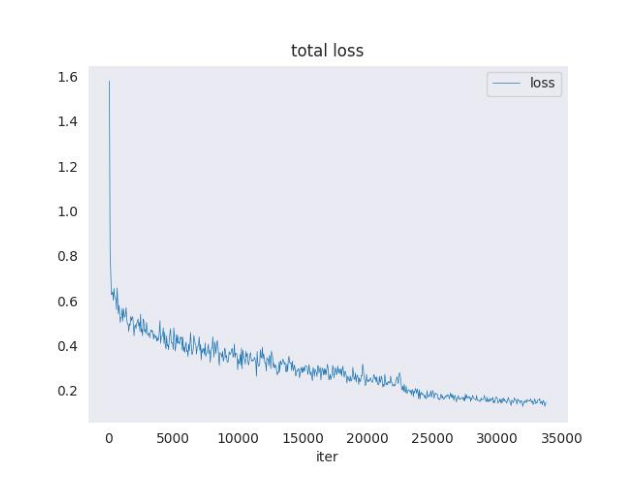

In [ ]:
cm = mmcv.imread('drive/MyDrive/damage_detection/dcn_plus_output/loss.jpg')
cm = mmcv.imconvert(cm, 'bgr', 'rgb')
plt.imshow(cm)
plt.axis('off')
plt.show()

In [ ]:
!python mmdetection/tools/analysis_tools/analyze_logs.py plot_curve drive/MyDrive/damage_detection/dcn_plus_output/20250715_113554/vis_data/scalars.json --keys segm_mAP segm_mAP_50 segm_mAP_75 --out drive/MyDrive/damage_detection/dcn_plus_output/segm_mAP.jpg --legend mAP mAP_50 mAP_75 --title 'segmentation mAP'

plot curve of drive/MyDrive/damage_detection/dcn_plus_output/20250715_113554/vis_data/scalars.json, metric is segm_mAP
plot curve of drive/MyDrive/damage_detection/dcn_plus_output/20250715_113554/vis_data/scalars.json, metric is segm_mAP_50
plot curve of drive/MyDrive/damage_detection/dcn_plus_output/20250715_113554/vis_data/scalars.json, metric is segm_mAP_75
save curve to: drive/MyDrive/damage_detection/dcn_plus_output/segm_mAP.jpg


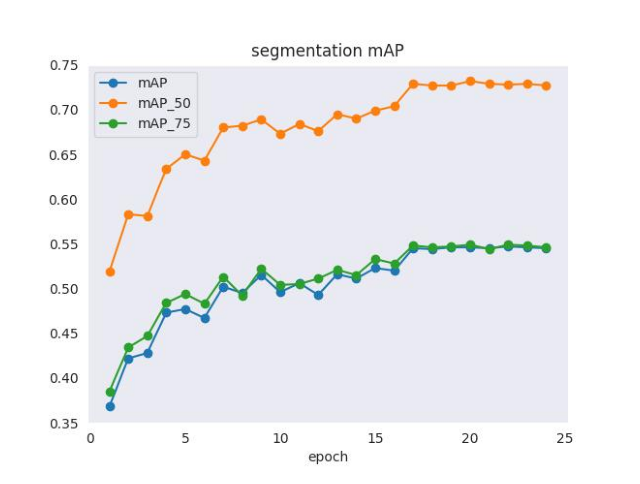

In [ ]:
cm = mmcv.imread('drive/MyDrive/damage_detection/dcn_plus_output/segm_mAP.jpg')
cm = mmcv.imconvert(cm, 'bgr', 'rgb')
plt.imshow(cm)
plt.axis('off')
plt.show()

### test

In [ ]:
from mmengine.runner import load_checkpoint

# Load full checkpoint
checkpoint = torch.load('drive/MyDrive/damage_detection/dcn_plus_output/epoch_24.pth', weights_only=False)

# Save only model weights
torch.save(checkpoint['state_dict'], 'drive/MyDrive/damage_detection/dcn_plus_output/epoch_24_weights_only.pth')


In [ ]:
!python mmdetection/tools/test.py \
 drive/MyDrive/damage_detection/dcn_plus_cfg.py \
 drive/MyDrive/damage_detection/dcn_plus_output/epoch_24_weights_only.pth \
 --out drive/MyDrive/damage_detection/dcn_plus_output/predictions.pkl

2025-07-18 11:30:07.059535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


E0000 00:00:1752838207.080592   53373 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752838207.087040   53373 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


07/18 11:30:10 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1409461128
    GPU 0: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.6.0+cu124
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.5
  - Built with CUDA Runtime 12.4
  - NVCC archi

07/18 11:30:12 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/18 11:30:12 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

Loads checkpoint by local backend from path: drive/MyDrive/damage_detection/dcn_plus_output/epoch_24_weights_only.pth
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer1.0.conv2 is upgraded to version 2.
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer1.1.conv2 is upgraded to version 2.
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer1.2.conv2 is upgraded to version 2.
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer2.1.conv2 is upgraded to version 2.
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer2.2.conv2 is upgraded to version 2.
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer2.3.conv2 is upgraded to version 2.
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer3.0.conv2 is upgraded to version 2.
07/18 11:30:13 - mmengine - INFO - DeformConv2dPack backbone.layer

07/18 11:30:18 - mmengine - INFO - Epoch(test) [ 50/374]    eta: 0:00:30  time: 0.0943  data_time: 0.0064  memory: 603  


07/18 11:30:22 - mmengine - INFO - Epoch(test) [100/374]    eta: 0:00:22  time: 0.0728  data_time: 0.0039  memory: 613  


07/18 11:30:25 - mmengine - INFO - Epoch(test) [150/374]    eta: 0:00:17  time: 0.0706  data_time: 0.0040  memory: 613  


07/18 11:30:29 - mmengine - INFO - Epoch(test) [200/374]    eta: 0:00:13  time: 0.0750  data_time: 0.0043  memory: 638  


07/18 11:30:33 - mmengine - INFO - Epoch(test) [250/374]    eta: 0:00:09  time: 0.0781  data_time: 0.0043  memory: 599  


07/18 11:30:36 - mmengine - INFO - Epoch(test) [300/374]    eta: 0:00:05  time: 0.0655  data_time: 0.0039  memory: 619  


07/18 11:30:40 - mmengine - INFO - Epoch(test) [350/374]    eta: 0:00:01  time: 0.0665  data_time: 0.0040  memory: 599  


07/18 11:30:41 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.774
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.422
 Average Recall     (AR) @[ IoU=0.50:0.95 | a

In [ ]:
# edited the confusion_matrix.py to have "figsize=( num_classes, num_classes ))"" for better image output

!python mmdetection/tools/analysis_tools/confusion_matrix.py drive/MyDrive/damage_detection/dcn_plus_cfg.py drive/MyDrive/damage_detection/dcn_plus_output/predictions.pkl drive/MyDrive/damage_detection/dcn_plus_output --show

2025-07-18 10:12:45.318448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752833565.339536   24065 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752833565.345938   24065 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


[>>>>>>>>>>>>>>>>>>>>>>>>>>> ] 365/374, 2054.9 task/s, elapsed: 0s, ETA:     0s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 374/374, 2057.5 task/s, elapsed: 0s, ETA:     0sFigure(700x700)


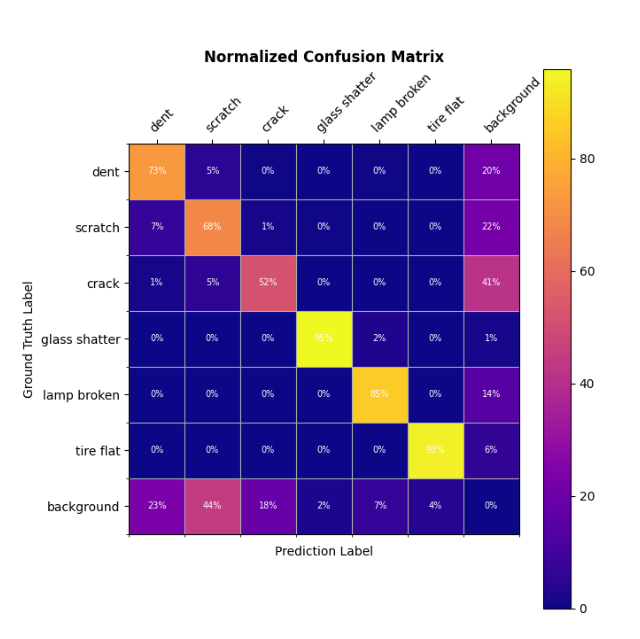

In [ ]:
cm = mmcv.imread('drive/MyDrive/damage_detection/dcn_plus_output/confusion_matrix.png')
cm = mmcv.imconvert(cm, 'bgr', 'rgb')
plt.imshow(cm)
plt.axis('off')
plt.show()

In [ ]:
# Replace this
# per_label_sums = confusion_matrix.sum(axis=1)[:, np.newaxis]
# confusion_matrix = \
#     confusion_matrix.astype(np.float32) / per_label_sums * 100

# With this
# confusion_matrix = confusion_matrix.astype(np.int32)

# And update the annotation text (inside the double for-loop)
# From this
# '{}%'

# To this
# '{}'

# also make  title='Confusion Matrix'

# save image as confusion_matrix2.png

# chnages in onfusion_matrix.py



!python mmdetection/tools/analysis_tools/confusion_matrix.py drive/MyDrive/damage_detection/dcn_plus_cfg.py drive/MyDrive/damage_detection/dcn_plus_output/predictions.pkl drive/MyDrive/damage_detection/dcn_plus_output --show

2025-08-15 12:31:18.995140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755261079.016818   23946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755261079.023465   23946 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755261079.040370   23946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755261079.040405   23946 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755261079.040409   23946 computation_placer.cc:177] computation placer alr

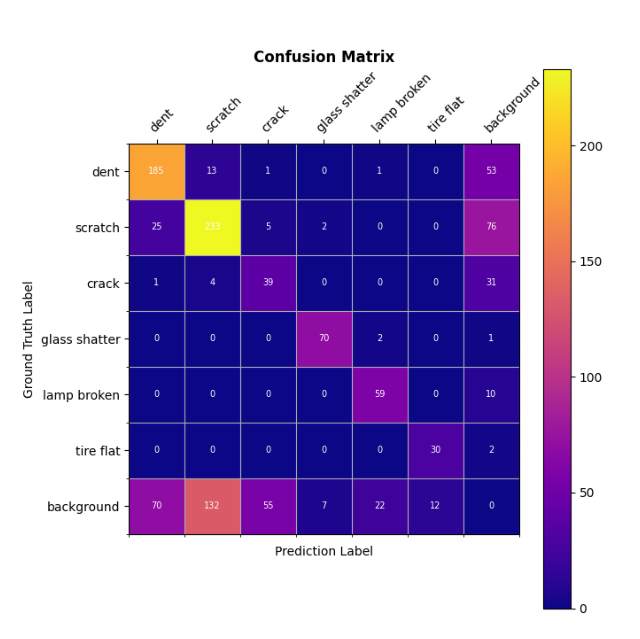

In [ ]:
cm = mmcv.imread('drive/MyDrive/damage_detection/dcn_plus_output/confusion_matrix2.png')
cm = mmcv.imconvert(cm, 'bgr', 'rgb')
plt.imshow(cm)
plt.axis('off')
plt.show()

### Test for time

In [ ]:
!python mmdetection/tools/analysis_tools/benchmark.py \
    drive/MyDrive/damage_detection/dcn_plus_cfg.py \
    --checkpoint drive/MyDrive/damage_detection/dcn_plus_output/epoch_24_weights_only.pth \
    --task inference \
    --log-interval 100 \
    --dataset-type test

07/18 11:14:57 - mmengine - INFO - before build: 
07/18 11:14:58 - mmengine - INFO - (GB) mem_used: 2.76 | uss: 0.43 | pss: 0.57 | total_proc: 1


2025-07-18 11:14:59.293407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752837299.314268   47522 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752837299.321079   47522 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loads checkpoint by local backend from path: drive/MyDrive/damage_detection/dcn_plus_output/epoch_24_weights_only.pth
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer1.0.conv2 is upgraded to version 2.
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer1.1.conv2 is upgraded to version 2.
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer1.2.conv2 is upgraded to version 2.
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer2.1.conv2 is upgraded to version 2.
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer2.2.conv2 is upgraded to version 2.
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer2.3.conv2 is upgraded to version 2.
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer3.0.conv2 is upgraded to version 2.
07/18 11:15:03 - mmengine - INFO - DeformConv2dPack backbone.layer

07/18 11:15:03 - mmengine - INFO - after build: 
07/18 11:15:04 - mmengine - INFO - (GB) mem_used: 3.43 | uss: 1.12 | pss: 1.40 | total_proc: 1


07/18 11:15:11 - mmengine - INFO - ==================================
07/18 11:15:11 - mmengine - INFO - Done image [100/2000], fps: 19.6 img/s, times per image: 51.0 ms/img, cuda memory: 613 MB
07/18 11:15:11 - mmengine - INFO - (GB) mem_used: 3.90 | uss: 1.70 | pss: 1.98 | total_proc: 1


07/18 11:15:18 - mmengine - INFO - ==================================
07/18 11:15:18 - mmengine - INFO - Done image [200/2000], fps: 20.6 img/s, times per image: 48.6 ms/img, cuda memory: 638 MB
07/18 11:15:18 - mmengine - INFO - (GB) mem_used: 3.89 | uss: 1.70 | pss: 1.98 | total_proc: 1


07/18 11:15:25 - mmengine - INFO - ==================================
07/18 11:15:25 - mmengine - INFO - Done image [300/2000], fps: 20.7 img/s, times per image: 48.3 ms/img, cuda memory: 619 MB
07/18 11:15:25 - mmengine - INFO - (GB) mem_used: 3.90 | uss: 1.71 | pss: 1.99 | total_proc: 1


07/18 11:15:30 - mmengine - INFO - ============== Done ==================
07/18 11:15:30 - mmengine - INFO - Overall fps: 20.7 img/s, times per image: 48.3 ms/img
07/18 11:15:30 - mmengine - INFO - cuda memory: 743 MB
07/18 11:15:30 - mmengine - INFO - (GB) mem_used: 3.91 | uss: 1.71 | pss: 2.00 | total_proc: 1


## images test 
- this is used in the "all_models_images" to test all models togather

In [ ]:
def inference_on_image(img_path, model, threshold=0.5):
    # Load and convert image
    img = mmcv.imread(img_path)
    img = mmcv.imconvert(img, 'bgr', 'rgb')

    visualizer = VISUALIZERS.build(model.cfg.visualizer)
    visualizer.dataset_meta = {
        'classes': ('dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat'),
        'palette': [(220, 20, 60), (119, 11, 32), (0, 0, 142),
                    (0, 0, 230), (106, 0, 228), (0, 60, 100)]
    }

    result = inference_detector(model, img)
    predictions = result.pred_instances

    # Filter predictions by threshold
    indices = predictions.scores >= threshold
    filtered_masks = predictions.masks[indices]
    filtered_bboxes = predictions.bboxes[indices]
    filtered_labels = predictions.labels[indices]
    filtered_scores = predictions.scores[indices]

    filtered_predictions = InstanceData(
        masks=filtered_masks,
        bboxes=filtered_bboxes,
        labels=filtered_labels,
        scores=filtered_scores
    )
    result.pred_instances = filtered_predictions

    # visualizer
    visualizer.add_datasample(
        'result',
        img,
        data_sample=result,
        draw_gt=False,
        show=False
    )
    frame = visualizer.get_image()

    # damage info
    classes = visualizer.dataset_meta['classes']
    label_counts = {}
    for label in filtered_labels:
        class_name = classes[label]
        label_counts[class_name] = label_counts.get(class_name, 0) + 1

    print(f"\nTotal Damages Detected: {len(filtered_labels)}")
    for damage_type, count in label_counts.items():
        print(f"- {damage_type}: {count}")

    # original img and result img side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(frame)
    axs[1].set_title("Detected Damages")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
config_file = 'drive/MyDrive/damage_detection/dcn_plus_cfg.py'

checkpoint_file = 'drive/MyDrive/damage_detection/dcn_plus_output/epoch_24_weights_only.pth'
# Build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device= 0)

Loads checkpoint by local backend from path: drive/MyDrive/damage_detection/dcn_plus_output/epoch_24_weights_only.pth
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer1.0.conv2 is upgraded to version 2.
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer1.1.conv2 is upgraded to version 2.
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer1.2.conv2 is upgraded to version 2.
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer2.1.conv2 is upgraded to version 2.
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer2.2.conv2 is upgraded to version 2.
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer2.3.conv2 is upgraded to version 2.
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer3.0.conv2 is upgraded to version 2.
07/15 15:25:23 - mmengine - INFO - DeformConv2dPack backbone.layer

/content/mmdetection/mmdet/apis/inference.py:90: UserWarning: dataset_meta or class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn(


In [ ]:
warnings.filterwarnings("ignore", category=UserWarning) # Hide warning when plotting the prediction